In [1]:
# !pip install transformers==4.51.3

In [1]:
!pip install transformers datasets accelerate --quiet

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
import os
import gc
import math

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
# from transformers import BertTokenizerFast, BertForSequenceClassification

In [4]:
# emotion_to_label_binary = {
#     "neutral": 0,
#     "non-neutral": 1,
#     "happy": 1, "anger": 1, "sad": 1,
#     "surprise": 1, "fear": 1, "disgust": 1
# }

# label_to_binary = {
#     'LABEL_0': "neutral",
#     'LABEL_1': "non-neutral"
# }

# emotion_to_label = {
#     "neutral": 0, "happy": 1, "anger": 2, "sad": 3,
#     "surprise": 4, "fear": 5, "disgust": 6
# }

# label_to_emotion = {
#     'LABEL_0': "neutral",
#     'LABEL_1': "happy",
#     'LABEL_2': "anger",
#     'LABEL_3': "sad",
#     'LABEL_4': "surprise",
#     'LABEL_5': "fear",
#     'LABEL_6': "disgust"
# }

# non_neutral_to_label = {
#     "happy": 0, "anger": 1, "sad": 2,
#     "surprise": 3, "fear": 4, "disgust": 5
# }

# label_to_non_neutral = {
#     'LABEL_0': "happy",
#     'LABEL_1': "anger",
#     'LABEL_2': "sad",
#     'LABEL_3': "surprise",
#     'LABEL_4': "fear",
#     'LABEL_5': "disgust"
# }

### Data loading & preprocessing:

#### Data loading:

In [21]:
folder_name = 'meld-data'

In [22]:
!mkdir -p meld-data

In [8]:
# !rm -r ./meld-data

In [43]:
train_df = pd.read_csv('./meld-data/train_sent_emo.csv')
test_df = pd.read_csv('./meld-data/test_sent_emo.csv')
val_df = pd.read_csv('./meld-data/val_sent_emo.csv')

print("Train DataFrame:")
print(train_df.shape)

print("\nTest DataFrame:")
print(test_df.shape)

print("\nValidation DataFrame:")
print(val_df.shape)

Train DataFrame:
(9989, 11)

Test DataFrame:
(2610, 11)

Validation DataFrame:
(1109, 11)


In [ ]:
train_df.head()

Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my company’s tr...         Chandler   
1       2                   You must’ve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So let’s talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

      StartTime       EndTime  
0  00:16:16,059  00:16:21,731  
1  00:16:21,940  00:16:23,442  
2  00:16:23,442  00:16:26,389  
3  00:16:26,820  00:16:29,572  
4  00:16:34,452  00:16:40,917

In [ ]:
val_df.head()

Sr No.                                          Utterance   Speaker  \
0       1     Oh my God, he’s lost it. He’s totally lost it.    Phoebe   
1       2                                              What?    Monica   
2       3  Or! Or, we could go to the bank, close our acc...      Ross   
3       4                                   You’re a genius!  Chandler   
4       5            Aww, man, now we won’t be bank buddies!      Joey   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   sadness  negative            0             0       4        7   
1  surprise  negative            0             1       4        7   
2   neutral   neutral            1             0       4        4   
3       joy  positive            1             1       4        4   
4   sadness  negative            1             2       4        4   

      StartTime       EndTime  
0  00:20:57,256  00:21:00,049  
1  00:21:01,927  00:21:03,261  
2  00:12:24,660  00:12:30,915  
3  00:12:32,334  00:12:33,960  
4  00:12:34,211  00:12:37,505

In [44]:
train_df.columns = train_df.columns.map(str).str.lower()
val_df.columns = val_df.columns.map(str).str.lower()
test_df.columns = test_df.columns.map(str).str.lower()

#### Data analysis:

In [ ]:
def plot_emotion_distribution(train_df, val_df, test_df):
  datasets = [train_df, test_df, val_df]
  dataset_names = ['Train', 'Test', 'Validation']
  emotion_counts = []

  for dataset in datasets:
    emotion_percent = dataset['emotion'].value_counts(normalize=True) * 100
    emotion_counts.append(emotion_percent.sort_index())

  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

  for i, (counts, name) in enumerate(zip(emotion_counts, dataset_names)):
    emotion_df = pd.DataFrame({'emotion': counts.index, 'percentage': counts.values})
    sns.barplot(data=emotion_df, x='emotion', y='percentage',
                hue='emotion', palette="viridis", ax=axes[i], legend=False)
    axes[i].set_title(f'{name} Dataset')
    axes[i].set_xlabel('Emotion')
    axes[i].set_ylabel('Percentage' if i == 0 else '')
    axes[i].tick_params(axis='x', rotation=45)

  plt.suptitle('Percentage of Emotions in Train, Test, and Validation Datasets')
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

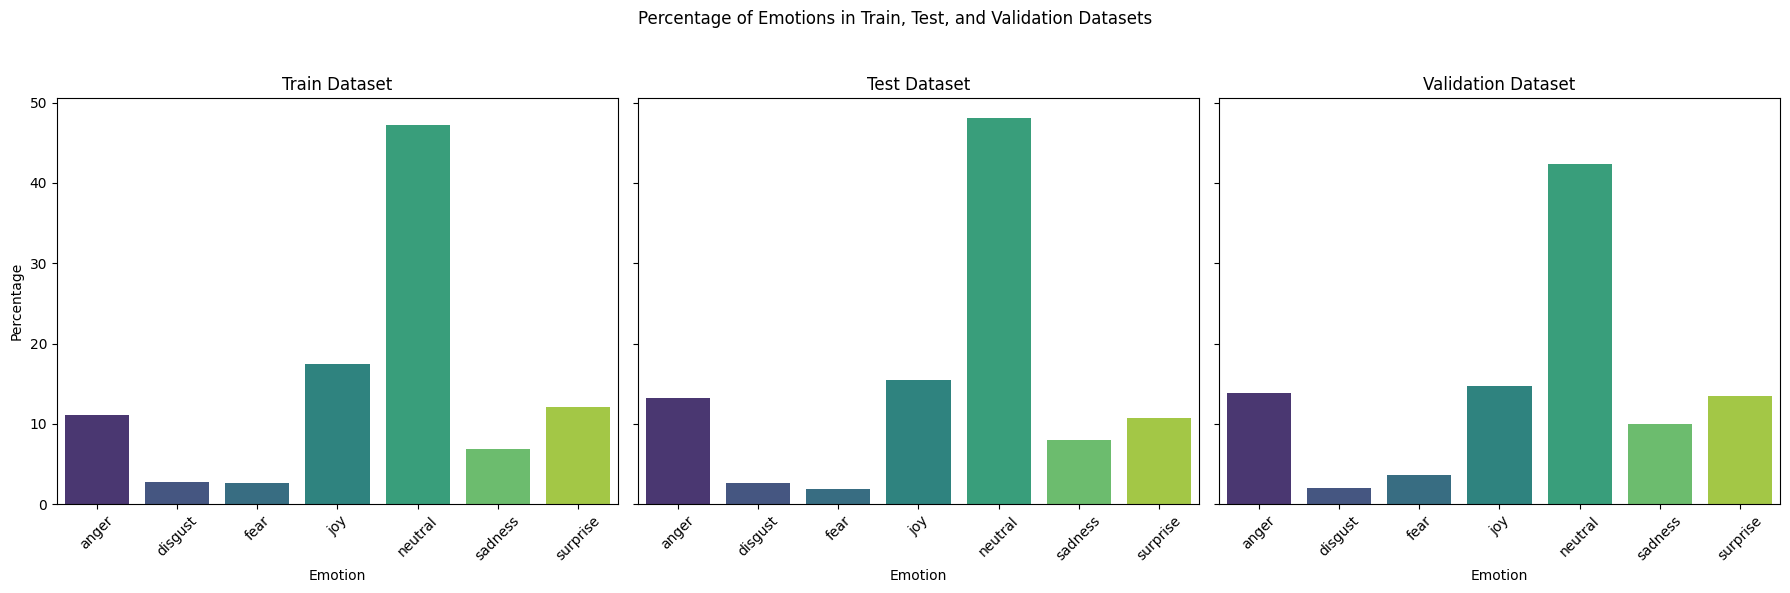

In [ ]:
plot_emotion_distribution(train_df, val_df, test_df)

In [ ]:
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df.head()

sr no.                                          utterance          speaker  \
0       1  also I was the point person on my company’s tr...         Chandler   
1       2                   You must’ve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So let’s talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    emotion sentiment  dialogue_id  utterance_id  season  episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

      starttime       endtime  
0  00:16:16,059  00:16:21,731  
1  00:16:21,940  00:16:23,442  
2  00:16:23,442  00:16:26,389  
3  00:16:26,820  00:16:29,572  
4  00:16:34,452  00:16:40,917

Average word & sentence count per utterance:

In [ ]:
full_df['word_count'] = full_df['utterance'].apply(lambda x: len(str(x).split()))
full_df['sentence_count'] = full_df['utterance'].apply(lambda x: str(x).count('.'))

avg_words = full_df['word_count'].mean()
avg_sentences = full_df['sentence_count'].mean()

print(f"Average number of words per utterance: {avg_words:.2f}")
print(f"Average number of sentences (based on periods) per utterance: {avg_sentences:.2f}")

Average number of words per utterance: 8.00
Average number of sentences (based on periods) per utterance: 0.78


Average word length per emotion:

In [ ]:
def avg_word_length(text):
  words = str(text).split()
  if not words:
    return 0
  return np.mean([len(word) for word in words])

full_df['avg_word_len'] = full_df['utterance'].apply(avg_word_length)
avg_word_len_by_emotion = full_df.groupby('emotion')['avg_word_len'].mean().sort_values(ascending=False)

print("Average word length per emotion:")
print(avg_word_len_by_emotion)

Average word length per emotion:
emotion
surprise    4.611082
fear        4.512184
joy         4.443643
neutral     4.362034
disgust     4.315637
anger       4.298758
sadness     4.223286
Name: avg_word_len, dtype: float64


Emotion distribution per speaker:

In [ ]:
emotion_per_speaker = full_df.groupby(['speaker', 'emotion']).size().unstack(fill_value=0)

print(emotion_per_speaker.shape)
print("Emotion count per speaker (top 10 speakers shown):")
print(emotion_per_speaker.head(10))

Emotion count per speaker (top 10 speakers shown):
(304, 7)
emotion           anger  disgust  fear  joy  neutral  sadness  surprise
speaker                                                                
1st Customer          0        0     0    1        0        0         0
2nd Customer          0        0     0    1        0        0         0
3rd Customer          0        0     0    0        1        1         0
A Female Student      0        0     0    0        1        0         0
A Student             0        0     0    0        0        0         1
A Waiter              0        0     0    0        1        0         0
Airline Employee      0        0     0    0        2        0         0
Alan                  0        0     0    0        2        0         1
Alice                 0        0     0    1        4        0         1
All                   2        5     0   15       19        2         8


In [ ]:
speaker_counts = full_df['speaker'].value_counts()
top_speakers = speaker_counts[speaker_counts >= 20].index
filtered_df = full_df[full_df['speaker'].isin(top_speakers)]

emotion_per_top_speaker = filtered_df.groupby(['speaker', 'emotion']).size().unstack(fill_value=0)

emotion_per_top_speaker['total'] = emotion_per_top_speaker.sum(axis=1)
emotion_per_top_speaker = emotion_per_top_speaker.sort_values(by='total', ascending=False).drop(columns='total')

print("Top speakers with most utterances and their emotion distribution:")
print(emotion_per_top_speaker.head(10))

Top speakers with most utterances and their emotion distribution:
emotion   anger  disgust  fear  joy  neutral  sadness  surprise
speaker                                                        
Joey        238       49    51  370      982      125       255
Ross        256       46    54  342      992      155       203
Rachel      232       49    57  338      795      208       276
Phoebe      233       50    36  300      806      150       222
Monica      243       69    38  319      759      115       239
Chandler    195       59    74  251      876      102       206
Janice       16        4     3    8       26       18        14
Carol         6        1     2   15       32        0         4
Tag           4        0     0   10       35        4         7
Emily        13        0     2    6       27        4         7


Most common words for each emotion:

In [ ]:
from collections import Counter
import re

def tokenize(text):
  return re.findall(r'\b\w+\b', text.lower())

top_words_per_emotion = {}

for emotion in full_df['emotion'].unique():
  words = full_df[full_df['emotion'] == emotion]['utterance'].apply(tokenize)
  flat_words = [word for sublist in words for word in sublist]
  counter = Counter(flat_words)
  top_words_per_emotion[emotion] = counter.most_common(50)

print("Top 10 words for each emotion:")
for emotion, words in top_words_per_emotion.items():
  print(f"\n{emotion.upper()}:")
  for word, count in words:
    print(f"{word}: {count}")

Top 10 words for each emotion:

NEUTRAL:
i: 2690
you: 2197
the: 1251
s: 1207
to: 1085
a: 1038
it: 1037
that: 848
and: 754
t: 662
know: 608
okay: 588
yeah: 562
we: 554
what: 545
no: 500
oh: 489
is: 481
m: 473
just: 465
of: 452
in: 443
well: 430
so: 422
have: 415
this: 409
do: 379
me: 366
right: 359
all: 347
hey: 346
re: 343
for: 339
don: 332
can: 324
on: 312
but: 310
uh: 305
with: 303
my: 301
are: 294
not: 288
he: 284
y: 279
be: 277
was: 274
go: 257
there: 252
your: 250
here: 247

SURPRISE:
you: 625
what: 397
i: 387
oh: 348
that: 225
s: 222
the: 191
my: 180
it: 176
a: 174
t: 163
god: 151
to: 144
are: 140
really: 124
is: 124
this: 118
me: 97
no: 91
re: 91
do: 90
so: 89
and: 82
he: 80
why: 80
was: 76
wow: 76
know: 74
whoa: 71
did: 70
hey: 68
in: 66
how: 66
can: 64
of: 60
with: 57
just: 55
there: 53
m: 52
not: 51
here: 50
like: 50
she: 48
look: 48
have: 46
don: 46
they: 46
yeah: 46
on: 45
who: 44

FEAR:
i: 281
you: 138
t: 106
no: 104
it: 75
to: 72
s: 67
oh: 60
a: 59
m: 58
and: 52
don: 50
t

In [ ]:
from collections import Counter, defaultdict
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
custom_stop_words = {'yeah', 'uh', 'hmm', 'oh', 'okay', 'ok', 'hey', 'um', 'huh', 'right'}
stop_words.update(custom_stop_words)

def tokenize_filtered(text):
  words = re.findall(r'\b\w+\b', str(text).lower())
  return [word for word in words if word not in stop_words]

emotion_word_counts = {}
word_emotion_presence = defaultdict(set)

for emotion in full_df['emotion'].unique():
  all_words = full_df[full_df['emotion'] == emotion]['utterance'].apply(tokenize_filtered)
  flat_words = [word for utter in all_words for word in utter]
  counter = Counter(flat_words)
  emotion_word_counts[emotion] = counter

  for word in set(flat_words):
    word_emotion_presence[word].add(emotion)

too_common_words = {word for word, emotions in word_emotion_presence.items() if len(emotions) >= 4}

top_words_per_emotion = {}

for emotion, counter in emotion_word_counts.items():
  filtered_counter = {word: count for word, count in counter.items() if word not in too_common_words}
  top_words = Counter(filtered_counter).most_common(10)
  top_words_per_emotion[emotion] = top_words

print("Top 10 distinctive words for each emotion:")
for emotion, words in top_words_per_emotion.items():
  print(f"\n{emotion.upper()}:")
  for word, count in words:
    print(f"{word}: {count}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 distinctive words for each emotion:

NEUTRAL:
later: 39
worry: 24
doin: 14
museum: 14
important: 12
clean: 11
grab: 11
decide: 11
point: 10
wondering: 10

SURPRISE:
r: 6
stole: 5
goodacre: 4
oww: 4
wha: 4
insane: 3
sign: 3
kicked: 3
barry: 3
gosh: 3

FEAR:
scary: 2
act: 2
incident: 2
jack: 2
fear: 2
gimme: 2
anywhere: 2
bus: 2
swear: 2
plastic: 2

SADNESS:
died: 7
worry: 5
killing: 4
band: 4
yep: 3
yesterday: 3
town: 3
j: 3
worst: 3
bee: 3

JOY:
glad: 17
yay: 11
dum: 11
hoo: 10
yep: 9
chick: 9
woo: 9
shoes: 9
wonderful: 8
push: 7

DISGUST:
ew: 13
pig: 4
disgusting: 4
eww: 4
ewww: 3
millions: 3
violated: 3
fish: 3
evil: 2
toilet: 2

ANGER:
damnit: 10
gimme: 8
stole: 8
horny: 5
later: 5
soup: 5
plan: 5
calm: 5
wendy: 5
garbage: 4


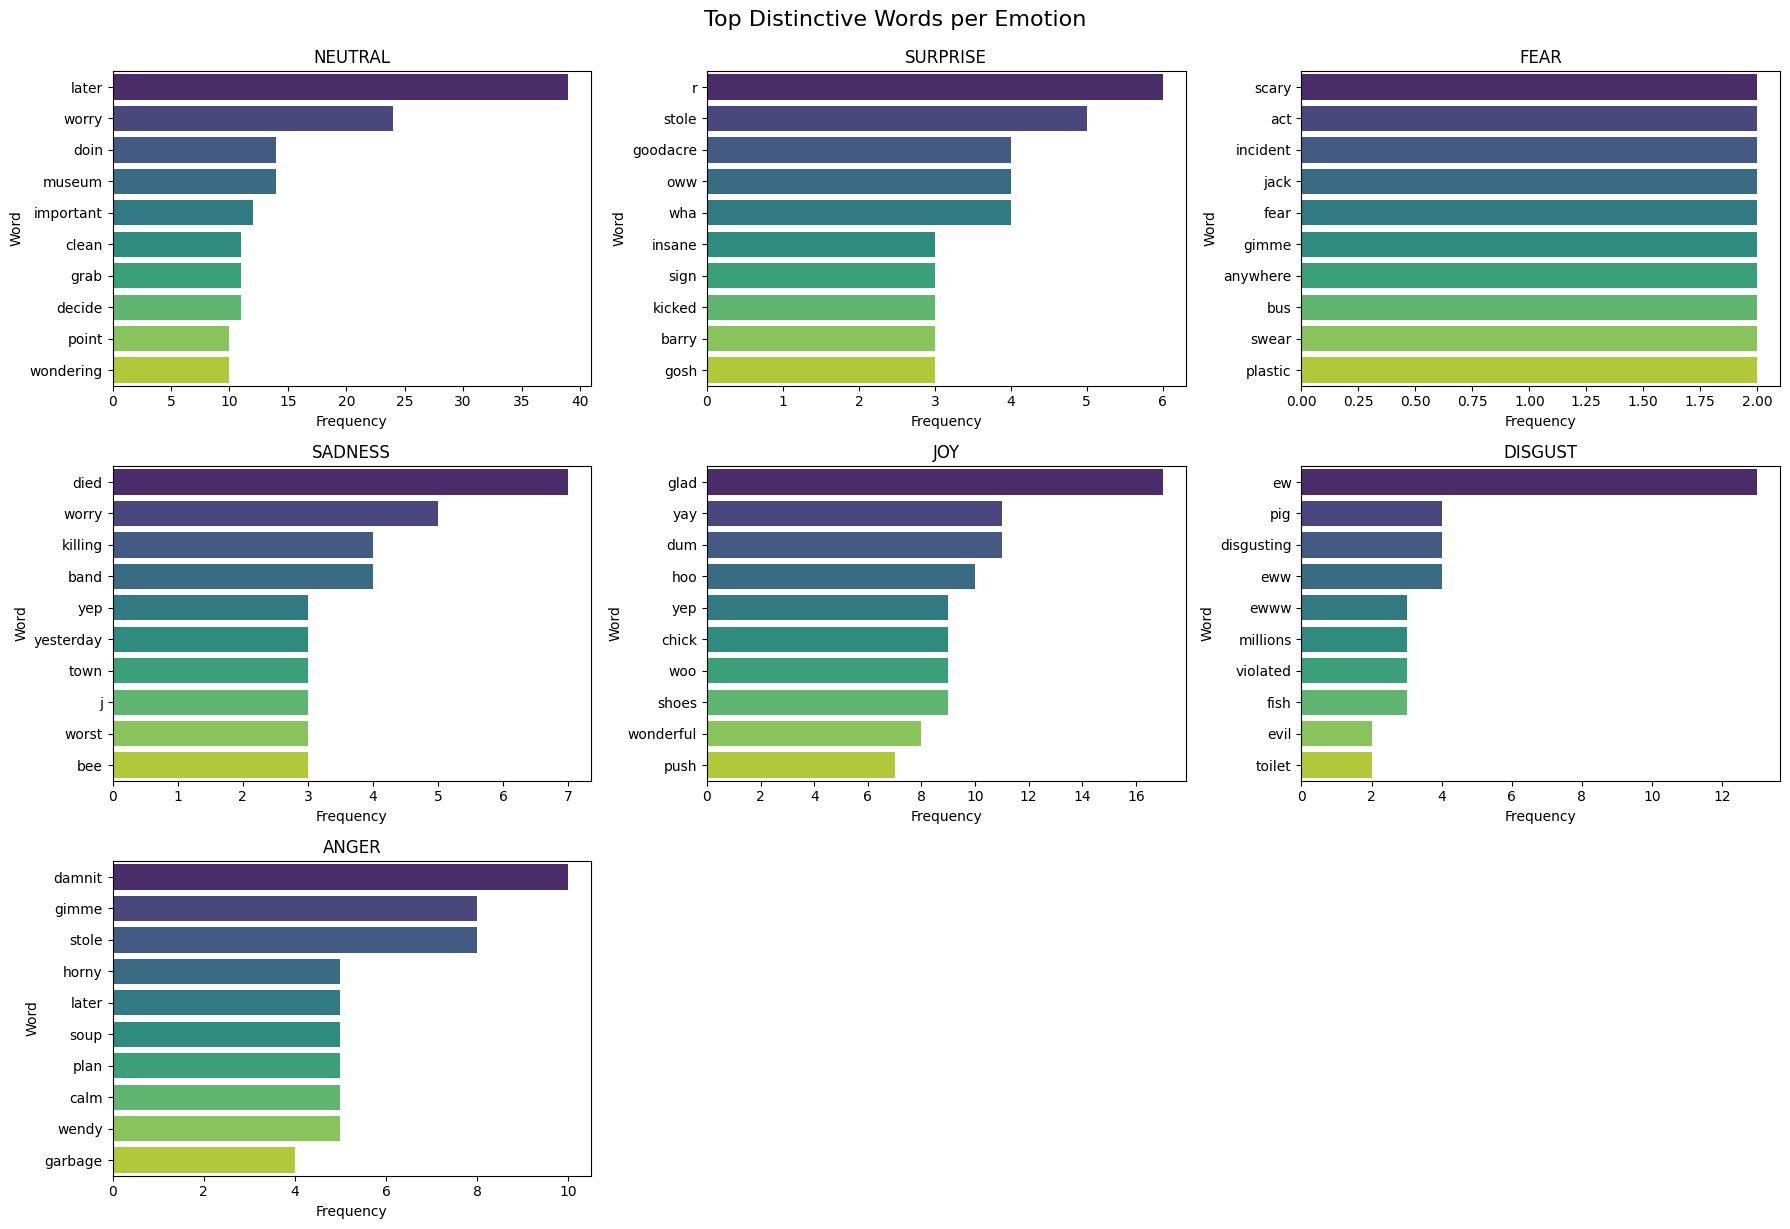

In [ ]:
def plot_top_words_per_emotion(top_words_per_emotion):
  num_emotions = len(top_words_per_emotion)
  cols = 3
  rows = (num_emotions + cols - 1) // cols

  fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
  axes = axes.flatten()

  for i, (emotion, words) in enumerate(top_words_per_emotion.items()):
    word_list, count_list = zip(*words)
    df = pd.DataFrame({'word': word_list, 'count': count_list})

    sns.barplot(data=df, x='count', y='word', hue='word', palette='viridis', ax=axes[i], legend=False)
    axes[i].set_title(emotion.upper())
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("Word")

  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.suptitle("Top Distinctive Words per Emotion", fontsize=16, y=1.02)
  plt.show()

plot_top_words_per_emotion(top_words_per_emotion)

In [ ]:
!pip install wordcloud --quiet

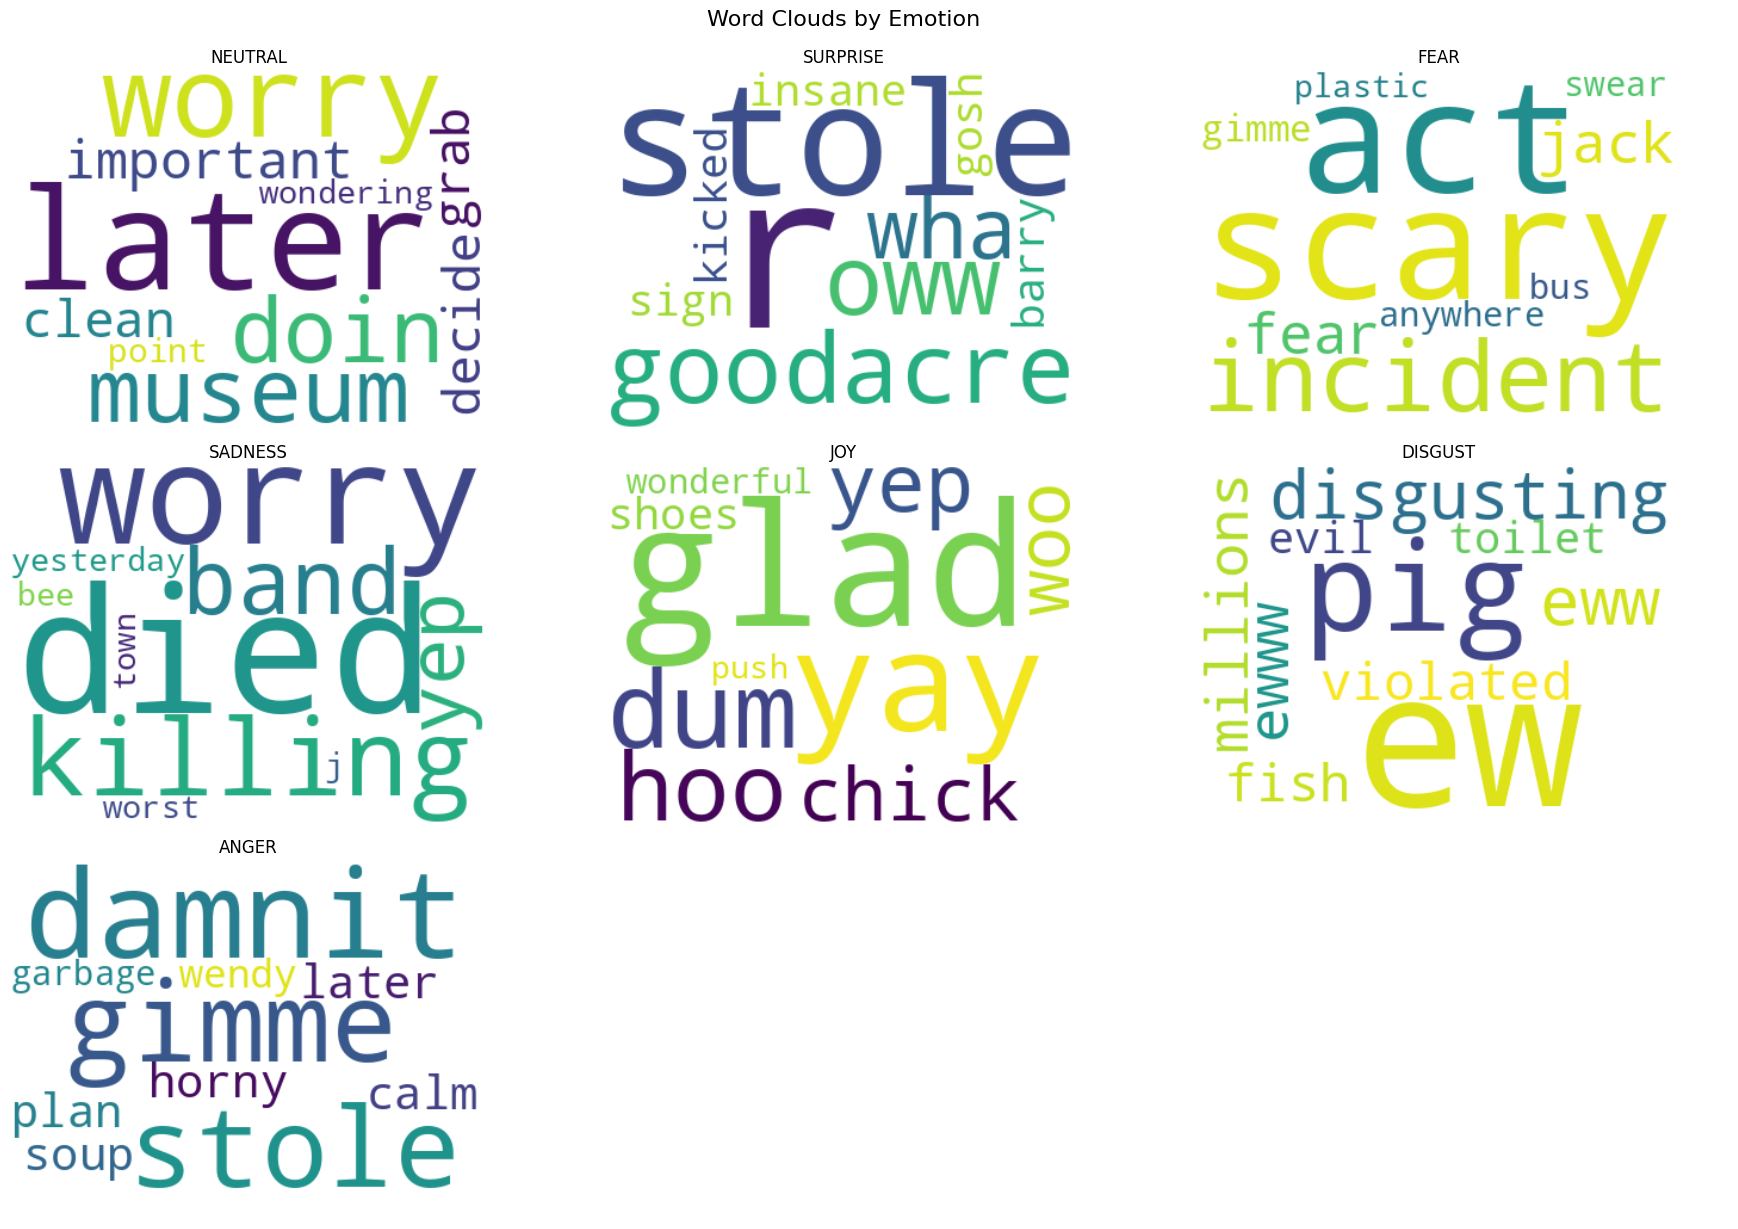

In [ ]:
from wordcloud import WordCloud

def plot_wordclouds_per_emotion(top_words_per_emotion):
  num_emotions = len(top_words_per_emotion)
  cols = 3
  rows = (num_emotions + cols - 1) // cols

  fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
  axes = axes.flatten()

  for i, (emotion, words) in enumerate(top_words_per_emotion.items()):
    word_freq = dict(words)
    wc = WordCloud(width=400, height=300, background_color='white', colormap='viridis')
    wc.generate_from_frequencies(word_freq)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(emotion.upper())

  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  plt.tight_layout()
  plt.suptitle("Word Clouds by Emotion", fontsize=16, y=1.02)
  plt.show()

plot_wordclouds_per_emotion(top_words_per_emotion)

#### Data preprocessing:

In [11]:
train_df['emotion'].value_counts()

emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64

##### Binary data:

In [8]:
def process_binary_df(df):
  df_binary = df.copy()
  df_binary['binary_label'] = (df_binary['emotion'] != 'neutral').astype(int)
  return df_binary

def remove_extra(df, samples_to_remove=0):
  df = df.copy()
  if samples_to_remove > 0:
    joy_indices = df[df['emotion'] == 'joy'].index
    other_non_neutral = df[(df['emotion'] != 'neutral') & (df['emotion'] != 'joy')].index

    drop_from_joy = min(len(joy_indices), samples_to_remove)
    remaining = samples_to_remove - drop_from_joy
    drop_from_others = min(len(other_non_neutral), remaining)

    drop_indices = joy_indices[:drop_from_joy].tolist() + other_non_neutral[:drop_from_others].tolist()
    df = df.drop(index=drop_indices).reset_index(drop=True)
  return df

In [9]:
TOTAL_REMOVE = 569
train_df_balanced = remove_extra(train_df, TOTAL_REMOVE)
train_binary_df = process_binary_df(train_df_balanced)
val_binary_df = process_binary_df(val_df)
test_binary_df = process_binary_df(test_df)

print(f"Train: {len(train_binary_df)}, Val: {len(val_binary_df)}, Test: {len(test_binary_df)}")
print("Class distribution in Train:")
print(train_binary_df['binary_label'].value_counts(normalize=True) * 100)

Train: 9420, Val: 1109, Test: 2610
Class distribution in Train:
binary_label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [10]:
train_binary_df = train_binary_df[['utterance', 'binary_label']]
test_binary_df = test_binary_df[['utterance', 'binary_label']]
val_binary_df = val_binary_df[['utterance', 'binary_label']]

train_binary_df.head()

utterance  binary_label
0  also I was the point person on my company’s tr...             0
1                   You must’ve had your hands full.             0
2                            That I did. That I did.             0
3      So let’s talk a little bit about your duties.             0
4                             My duties?  All right.             1

##### Non-neutral data:

In [ ]:
# def process_non_neutral_df(df):
#   df_non_neutral = df.copy()
#   df_non_neutral['emotion'] = (df_non_neutral['emotion'] != 'neutral').astype(int)
#   return df_non_neutral

##### Full data:

In [7]:
emotion_to_label = {
  "neutral": 0,
  "happy": 1, "joy": 1,
  "anger": 2,
  "sad": 3, "sadness": 3,
  "surprise": 4,
  "fear": 5,
  "disgust": 6
}

def process_full_df(df):
  df_full = df.copy()
  df_full['emotion_label'] = df_full['emotion'].map(emotion_to_label)
  if df_full['emotion_label'].isnull().any():
    print(df_full[df_full['emotion_label'].isnull()]['emotion'].value_counts())
  return df_full

In [8]:
train_full_df = process_full_df(train_df)
val_full_df = process_full_df(val_df)
test_full_df = process_full_df(test_df)

In [9]:
train_full_df = train_full_df[['utterance', 'emotion_label']]
test_full_df = test_full_df[['utterance', 'emotion_label']]
val_full_df = val_full_df[['utterance', 'emotion_label']]

train_full_df.head()

utterance  emotion_label
0  also I was the point person on my company’s tr...              0
1                   You must’ve had your hands full.              0
2                            That I did. That I did.              0
3      So let’s talk a little bit about your duties.              0
4                             My duties?  All right.              4

### Binary twitter-roberta-base-emotion model training:

##### Binary training:

In [24]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

###### * Batches:

In [ ]:
# !rm -r ./batches

In [ ]:
def save_tokenized_encodings(texts, labels, tokenizer, batch_size, prefix, output_dir="./batches"):
  os.makedirs(output_dir, exist_ok=True)
  for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_labels = labels[i:i + batch_size]

    batch_encodings = tokenizer(batch_texts, padding="max_length", truncation=True, return_tensors="pt")
    batch_encodings["labels"] = torch.tensor(batch_labels)

    batch_path = os.path.join(output_dir, f"{prefix}_batch_{i//batch_size}.pt")
    torch.save(batch_encodings, batch_path)

    del batch_texts, batch_labels, batch_encodings, batch_path
    gc.collect()

In [ ]:
save_tokenized_encodings(list(train_binary_df["utterance"]), list(train_binary_df["binary_label"]), tokenizer, 256, prefix="train")
save_tokenized_encodings(list(val_binary_df["utterance"]), list(val_binary_df["binary_label"]), tokenizer, 256, prefix="val")
save_tokenized_encodings(list(test_binary_df["utterance"]), list(test_binary_df["binary_label"]), tokenizer, 256, prefix="test")

In [ ]:
del train_binary_df, val_binary_df, test_binary_df, train_df, val_df, test_df, train_df_balanced, tokenizer
gc.collect()

0

In [ ]:
def collate_fn(batch):
  input_ids = torch.stack([item["input_ids"] for item in batch])
  attention_mask = torch.stack([item["attention_mask"] for item in batch])
  labels = torch.stack([item["labels"] for item in batch])
  return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

def load_batches(prefix, batch_size=32, batch_dir="./batches"):
  paths = sorted([os.path.join(batch_dir, f) for f in os.listdir(batch_dir) if f.startswith(prefix)])
  batches = [torch.load(p, weights_only=False) for p in paths]
  return DataLoader(batches, batch_size=batch_size, shuffle=(prefix == "train"), collate_fn=collate_fn)

In [ ]:
train_loader = load_batches("train")
val_loader = load_batches("val")
test_loader = load_batches("test")

###### Whole data:

In [25]:
train_labels = list(map(int, train_binary_df["binary_label"]))
val_labels = list(map(int, val_binary_df["binary_label"]))
test_labels = list(map(int, test_binary_df["binary_label"]))

In [28]:
set(train_binary_df["binary_label"])

{0, 1}

In [29]:
train_binary_df["binary_label"].value_counts()

binary_label
0    4710
1    4710
Name: count, dtype: int64

In [31]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [32]:
train_dataset = TextDataset(train_binary_df["utterance"].tolist(), train_binary_df["binary_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_binary_df["utterance"].tolist(), val_binary_df["binary_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_binary_df["utterance"].tolist(), test_binary_df["binary_label"].tolist(), tokenizer)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
num_training_steps = len(train_loader) * 10
lr_scheduler = get_scheduler(
  "linear", optimizer=optimizer,
  num_warmup_steps=0, num_training_steps=num_training_steps
)

In [38]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    logits = outputs.logits

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      logits = outputs.logits

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  print("Classification Report:")
  print(classification_report(all_labels, all_preds, digits=4))
  print("Confusion Matrix:")
  cm = confusion_matrix(all_labels, all_preds)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  return total_loss / len(dataloader), correct / total

In [39]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7036    0.8787    0.7815       470
           1     0.8908    0.7277    0.8010       639

    accuracy                         0.7917      1109
   macro avg     0.7972    0.8032    0.7912      1109
weighted avg     0.8115    0.7917    0.7927      1109

Confusion Matrix:


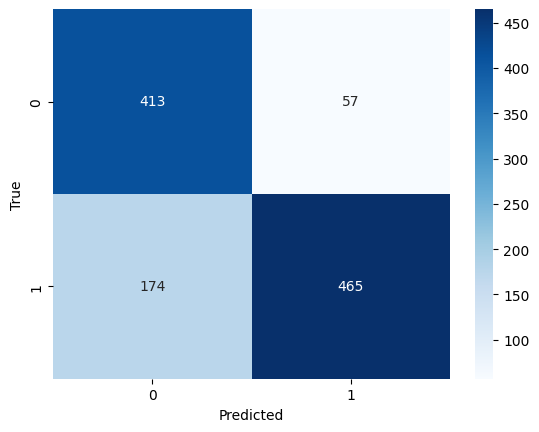

Train Loss: 0.4985, Accuracy: 0.7639
Val   Loss: 0.4642, Accuracy: 0.7917
Model saved.

Epoch 2/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7559    0.8170    0.7853       470
           1     0.8569    0.8059    0.8306       639

    accuracy                         0.8106      1109
   macro avg     0.8064    0.8115    0.8080      1109
weighted avg     0.8141    0.8106    0.8114      1109

Confusion Matrix:


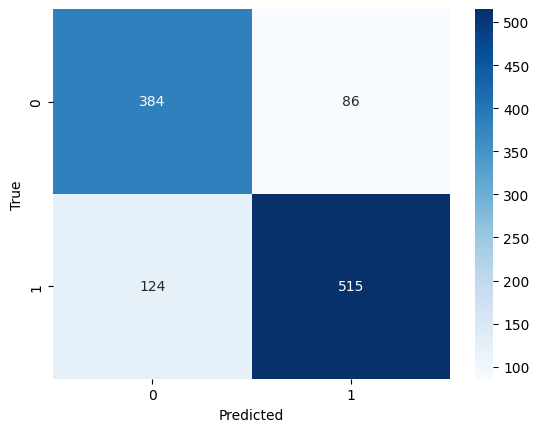

Train Loss: 0.4033, Accuracy: 0.8221
Val   Loss: 0.4631, Accuracy: 0.8106
Model saved.

Epoch 3/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7786    0.7106    0.7430       470
           1     0.8000    0.8513    0.8249       639

    accuracy                         0.7917      1109
   macro avg     0.7893    0.7810    0.7840      1109
weighted avg     0.7909    0.7917    0.7902      1109

Confusion Matrix:


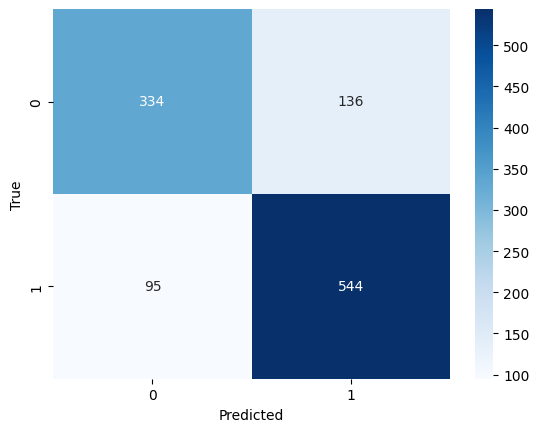

Train Loss: 0.3086, Accuracy: 0.8756
Val   Loss: 0.5080, Accuracy: 0.7917
No improvement. Patience: 1/2

Epoch 4/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7663    0.7745    0.7704       470
           1     0.8328    0.8263    0.8295       639

    accuracy                         0.8043      1109
   macro avg     0.7996    0.8004    0.8000      1109
weighted avg     0.8046    0.8043    0.8045      1109

Confusion Matrix:


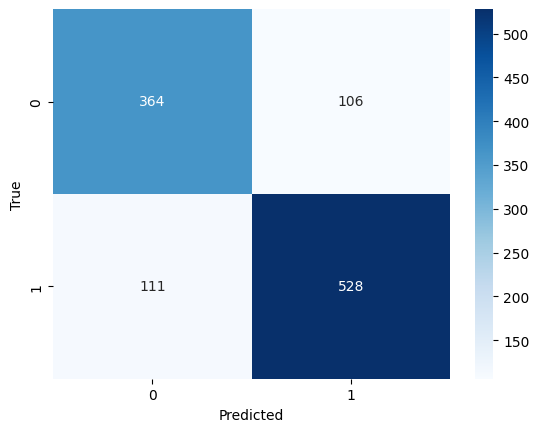

Train Loss: 0.2050, Accuracy: 0.9251
Val   Loss: 0.6013, Accuracy: 0.8043
No improvement. Patience: 2/2
Early stopping.


In [40]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 2
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_model.pt")
    print("Model saved.")
  else:
    patience_counter += 1
    print(f"No improvement. Patience: {patience_counter}/{patience}")
    if patience_counter >= patience:
      print("Early stopping.")
      break

##### Results analysis:

In [41]:
# model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs.logits, dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.772


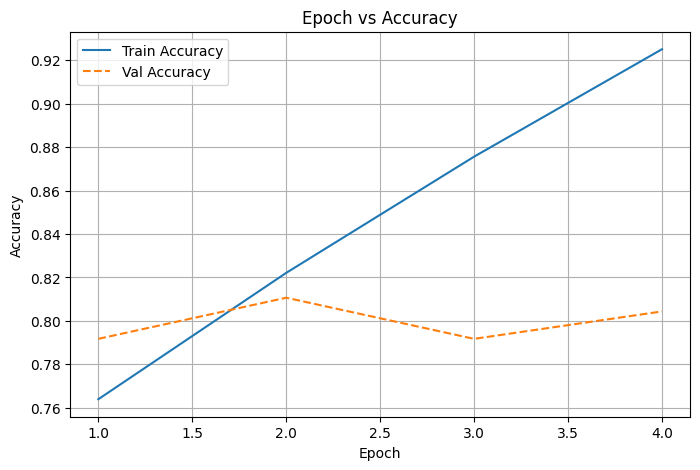

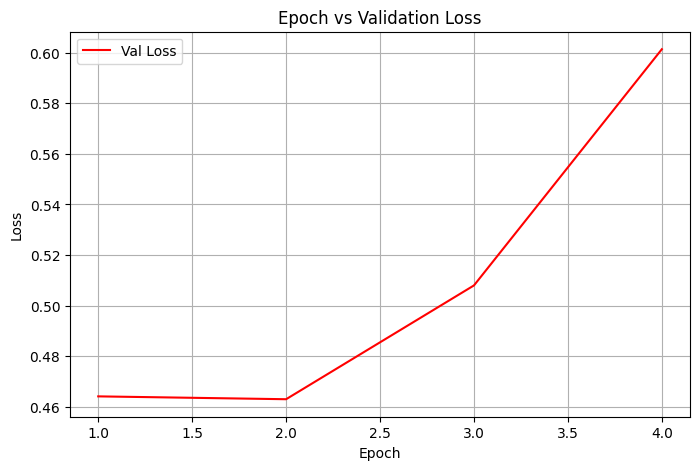

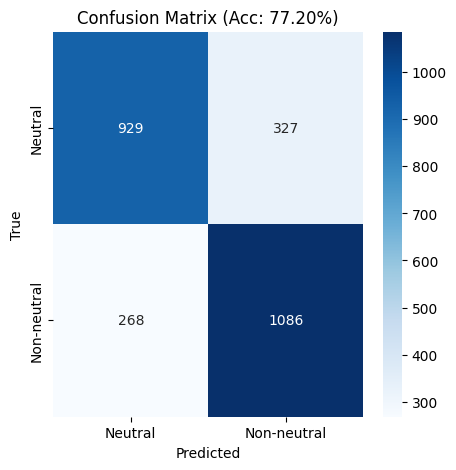

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Non-neutral"], yticklabels=["Neutral", "Non-neutral"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [43]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Neutral", "Non-neutral"]))


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.78      0.74      0.76      1256
 Non-neutral       0.77      0.80      0.78      1354

    accuracy                           0.77      2610
   macro avg       0.77      0.77      0.77      2610
weighted avg       0.77      0.77      0.77      2610



In [44]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     1          0
1     1          0
2     0          0
3     0          0
4     1          1

### Binary bhadresh-savani/distilbert-base-uncased-emotion model training:

##### Binary training:

In [45]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

###### Whole data:

In [ ]:
train_labels = list(map(int, train_binary_df["binary_label"]))
val_labels = list(map(int, val_binary_df["binary_label"]))
test_labels = list(map(int, test_binary_df["binary_label"]))

In [ ]:
set(train_binary_df["binary_label"])

{0, 1}

In [ ]:
train_binary_df["binary_label"].value_counts()

binary_label
0    4710
1    4710
Name: count, dtype: int64

In [47]:
max_len_chars = train_binary_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 327


In [48]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=256):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [49]:
train_dataset = TextDataset(train_binary_df["utterance"].tolist(), train_binary_df["binary_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_binary_df["utterance"].tolist(), val_binary_df["binary_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_binary_df["utterance"].tolist(), test_binary_df["binary_label"].tolist(), tokenizer)

In [50]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/distilbert-base-uncased-emotion and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
num_training_steps = len(train_loader) * 10
lr_scheduler = get_scheduler(
  "linear", optimizer=optimizer,
  num_warmup_steps=0, num_training_steps=num_training_steps
)

In [53]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    logits = outputs.logits

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      logits = outputs.logits

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  print("Classification Report:")
  print(classification_report(all_labels, all_preds, digits=4))
  print("Confusion Matrix:")
  cm = confusion_matrix(all_labels, all_preds)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  return total_loss / len(dataloader), correct / total

In [54]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7005    0.8660    0.7745       470
           1     0.8807    0.7277    0.7969       639

    accuracy                         0.7863      1109
   macro avg     0.7906    0.7968    0.7857      1109
weighted avg     0.8043    0.7863    0.7874      1109

Confusion Matrix:


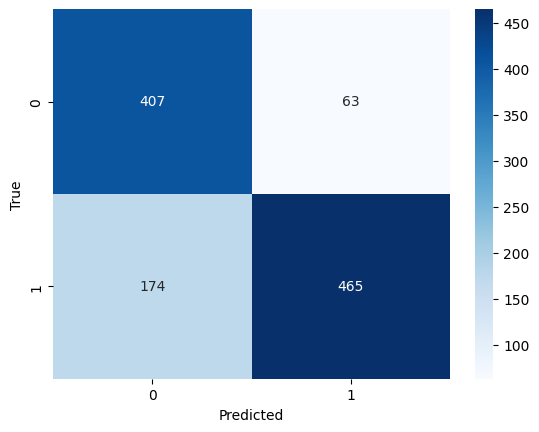

Train Loss: 0.5051, Accuracy: 0.7520
Val   Loss: 0.4661, Accuracy: 0.7863
Model saved.

Epoch 2/10


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7034    0.8277    0.7605       470
           1     0.8543    0.7433    0.7950       639

    accuracy                         0.7791      1109
   macro avg     0.7789    0.7855    0.7777      1109
weighted avg     0.7904    0.7791    0.7804      1109

Confusion Matrix:


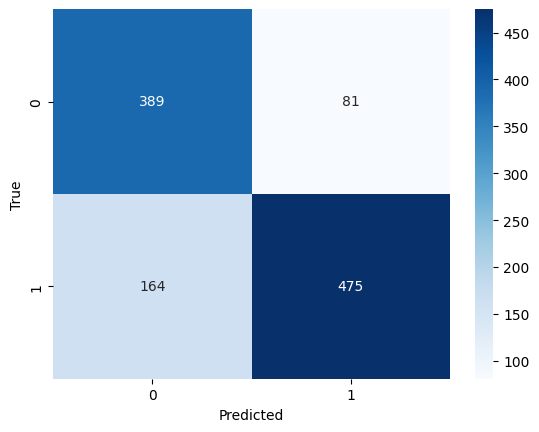

Train Loss: 0.4332, Accuracy: 0.8051
Val   Loss: 0.4673, Accuracy: 0.7791
No improvement. Patience: 1/2

Epoch 3/10


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7489    0.7553    0.7521       470
           1     0.8189    0.8138    0.8163       639

    accuracy                         0.7890      1109
   macro avg     0.7839    0.7845    0.7842      1109
weighted avg     0.7893    0.7890    0.7891      1109

Confusion Matrix:


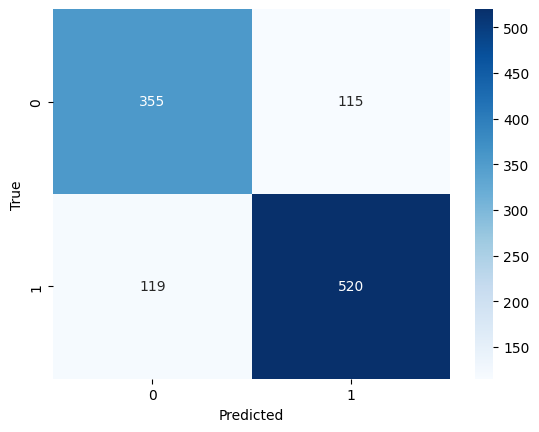

Train Loss: 0.3574, Accuracy: 0.8528
Val   Loss: 0.4968, Accuracy: 0.7890
No improvement. Patience: 2/2
Early stopping.


In [55]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 2
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_model.pt")
    print("Model saved.")
  else:
    patience_counter += 1
    print(f"No improvement. Patience: {patience_counter}/{patience}")
    if patience_counter >= patience:
      print("Early stopping.")
      break

##### Results analysis:

In [56]:
# model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs.logits, dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.775


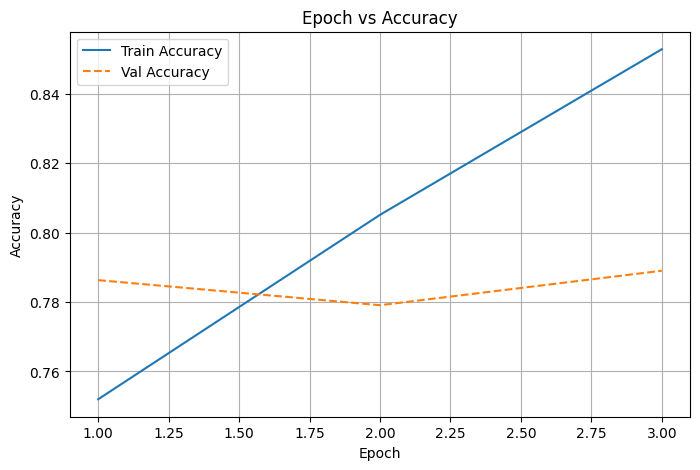

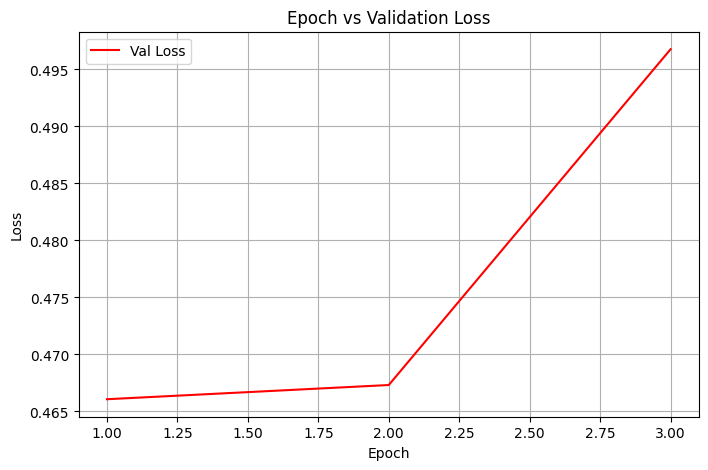

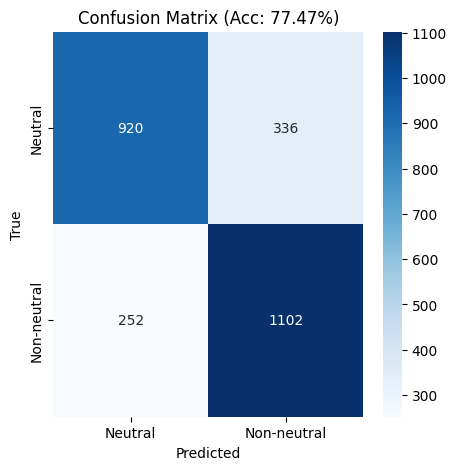

In [57]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Non-neutral"], yticklabels=["Neutral", "Non-neutral"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [58]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Neutral", "Non-neutral"]))


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.78      0.73      0.76      1256
 Non-neutral       0.77      0.81      0.79      1354

    accuracy                           0.77      2610
   macro avg       0.78      0.77      0.77      2610
weighted avg       0.78      0.77      0.77      2610



In [59]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     1          0
1     1          1
2     0          0
3     0          0
4     1          1

### Binary ... model training:

##### Binary training:

In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

###### Whole data:

In [ ]:
train_labels = list(map(int, train_binary_df["binary_label"]))
val_labels = list(map(int, val_binary_df["binary_label"]))
test_labels = list(map(int, test_binary_df["binary_label"]))

In [ ]:
set(train_binary_df["binary_label"])

{0, 1}

In [ ]:
train_binary_df["binary_label"].value_counts()

binary_label
0    4710
1    4710
Name: count, dtype: int64

In [ ]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [ ]:
train_dataset = TextDataset(train_binary_df["utterance"].tolist(), train_binary_df["binary_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_binary_df["utterance"].tolist(), val_binary_df["binary_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_binary_df["utterance"].tolist(), test_binary_df["binary_label"].tolist(), tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_training_steps = len(train_loader) * 10
lr_scheduler = get_scheduler(
  "linear", optimizer=optimizer,
  num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    logits = outputs.logits

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      logits = outputs.logits

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  print("Classification Report:")
  print(classification_report(all_labels, all_preds, digits=4))
  print("Confusion Matrix:")
  cm = confusion_matrix(all_labels, all_preds)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  return total_loss / len(dataloader), correct / total

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7036    0.8787    0.7815       470
           1     0.8908    0.7277    0.8010       639

    accuracy                         0.7917      1109
   macro avg     0.7972    0.8032    0.7912      1109
weighted avg     0.8115    0.7917    0.7927      1109

Confusion Matrix:


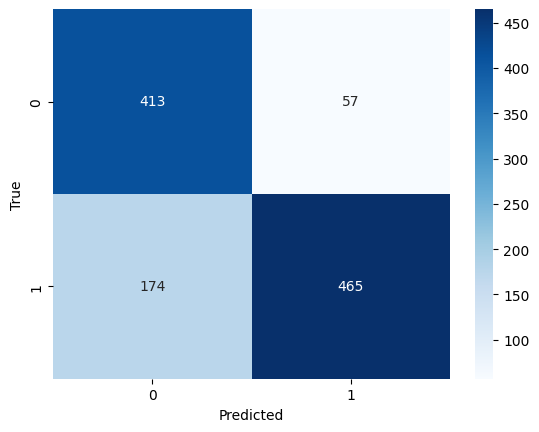

Train Loss: 0.4985, Accuracy: 0.7639
Val   Loss: 0.4642, Accuracy: 0.7917
Model saved.

Epoch 2/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7559    0.8170    0.7853       470
           1     0.8569    0.8059    0.8306       639

    accuracy                         0.8106      1109
   macro avg     0.8064    0.8115    0.8080      1109
weighted avg     0.8141    0.8106    0.8114      1109

Confusion Matrix:


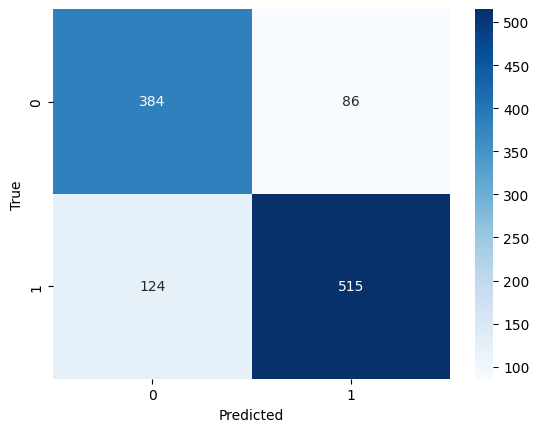

Train Loss: 0.4033, Accuracy: 0.8221
Val   Loss: 0.4631, Accuracy: 0.8106
Model saved.

Epoch 3/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7786    0.7106    0.7430       470
           1     0.8000    0.8513    0.8249       639

    accuracy                         0.7917      1109
   macro avg     0.7893    0.7810    0.7840      1109
weighted avg     0.7909    0.7917    0.7902      1109

Confusion Matrix:


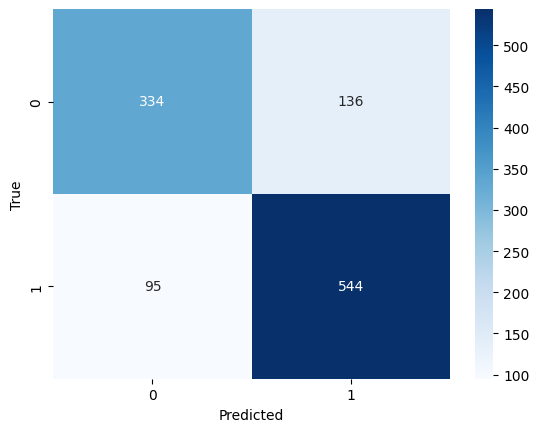

Train Loss: 0.3086, Accuracy: 0.8756
Val   Loss: 0.5080, Accuracy: 0.7917
No improvement. Patience: 1/2

Epoch 4/10


100%|██████████| 35/35 [00:06<00:00,  5.49it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7663    0.7745    0.7704       470
           1     0.8328    0.8263    0.8295       639

    accuracy                         0.8043      1109
   macro avg     0.7996    0.8004    0.8000      1109
weighted avg     0.8046    0.8043    0.8045      1109

Confusion Matrix:


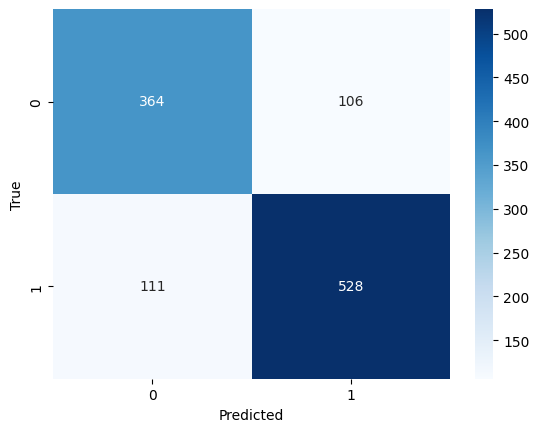

Train Loss: 0.2050, Accuracy: 0.9251
Val   Loss: 0.6013, Accuracy: 0.8043
No improvement. Patience: 2/2
Early stopping.


In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 2
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_model.pt")
    print("Model saved.")
  else:
    patience_counter += 1
    print(f"No improvement. Patience: {patience_counter}/{patience}")
    if patience_counter >= patience:
      print("Early stopping.")
      break

##### Results analysis:

In [ ]:
# model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs.logits, dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.772


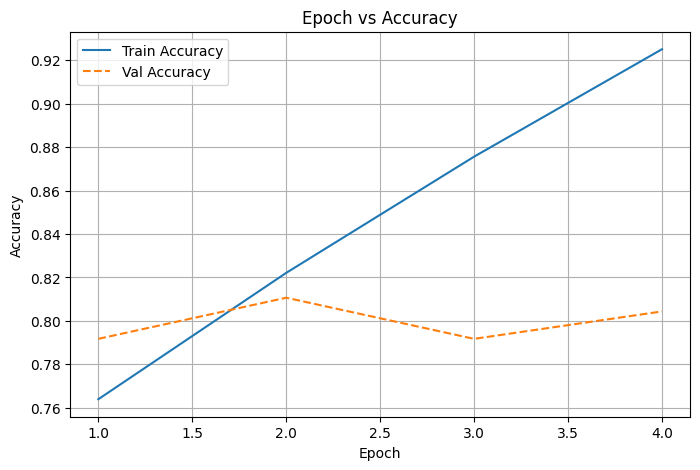

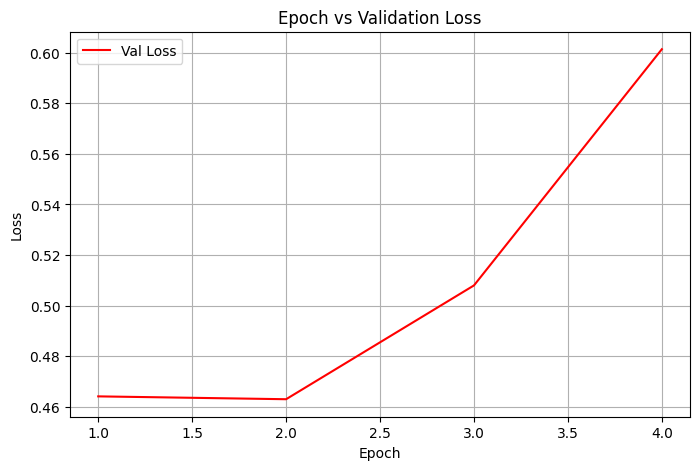

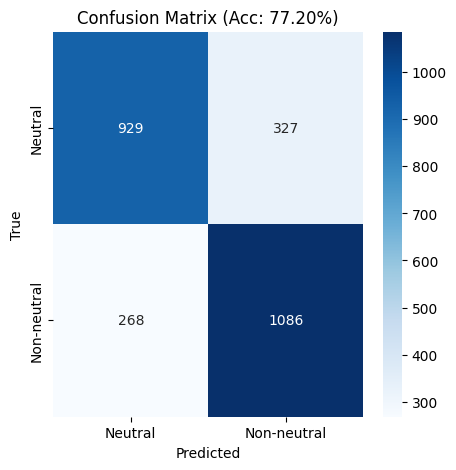

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Non-neutral"], yticklabels=["Neutral", "Non-neutral"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Neutral", "Non-neutral"]))


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.78      0.74      0.76      1256
 Non-neutral       0.77      0.80      0.78      1354

    accuracy                           0.77      2610
   macro avg       0.77      0.77      0.77      2610
weighted avg       0.77      0.77      0.77      2610



In [ ]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     1          0
1     1          0
2     0          0
3     0          0
4     1          1

### Non-neutral model training:

In [ ]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

###### Whole data:

In [ ]:
train_labels = list(map(int, train_binary_df["binary_label"]))
val_labels = list(map(int, val_binary_df["binary_label"]))
test_labels = list(map(int, test_binary_df["binary_label"]))

In [ ]:
set(train_binary_df["binary_label"])

{0, 1}

In [ ]:
train_binary_df["binary_label"].value_counts()

binary_label
0    4710
1    4710
Name: count, dtype: int64

In [ ]:
max_len_chars = train_binary_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 327


In [ ]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=256):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [ ]:
train_dataset = TextDataset(train_binary_df["utterance"].tolist(), train_binary_df["binary_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_binary_df["utterance"].tolist(), val_binary_df["binary_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_binary_df["utterance"].tolist(), test_binary_df["binary_label"].tolist(), tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/distilbert-base-uncased-emotion and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_training_steps = len(train_loader) * 10
lr_scheduler = get_scheduler(
  "linear", optimizer=optimizer,
  num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    logits = outputs.logits

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      logits = outputs.logits

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  print("Classification Report:")
  print(classification_report(all_labels, all_preds, digits=4))
  print("Confusion Matrix:")
  cm = confusion_matrix(all_labels, all_preds)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  return total_loss / len(dataloader), correct / total

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7005    0.8660    0.7745       470
           1     0.8807    0.7277    0.7969       639

    accuracy                         0.7863      1109
   macro avg     0.7906    0.7968    0.7857      1109
weighted avg     0.8043    0.7863    0.7874      1109

Confusion Matrix:


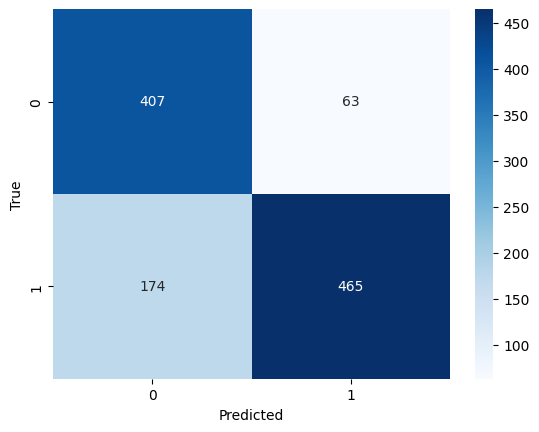

Train Loss: 0.5051, Accuracy: 0.7520
Val   Loss: 0.4661, Accuracy: 0.7863
Model saved.

Epoch 2/10


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7034    0.8277    0.7605       470
           1     0.8543    0.7433    0.7950       639

    accuracy                         0.7791      1109
   macro avg     0.7789    0.7855    0.7777      1109
weighted avg     0.7904    0.7791    0.7804      1109

Confusion Matrix:


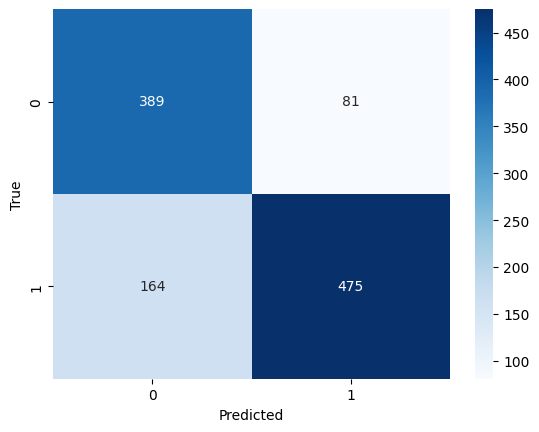

Train Loss: 0.4332, Accuracy: 0.8051
Val   Loss: 0.4673, Accuracy: 0.7791
No improvement. Patience: 1/2

Epoch 3/10


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.7489    0.7553    0.7521       470
           1     0.8189    0.8138    0.8163       639

    accuracy                         0.7890      1109
   macro avg     0.7839    0.7845    0.7842      1109
weighted avg     0.7893    0.7890    0.7891      1109

Confusion Matrix:


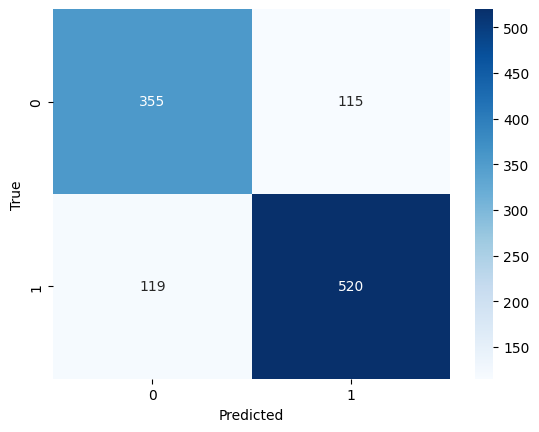

Train Loss: 0.3574, Accuracy: 0.8528
Val   Loss: 0.4968, Accuracy: 0.7890
No improvement. Patience: 2/2
Early stopping.


In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 2
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_model.pt")
    print("Model saved.")
  else:
    patience_counter += 1
    print(f"No improvement. Patience: {patience_counter}/{patience}")
    if patience_counter >= patience:
      print("Early stopping.")
      break

##### Results analysis:

In [ ]:
# model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs.logits, dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.775


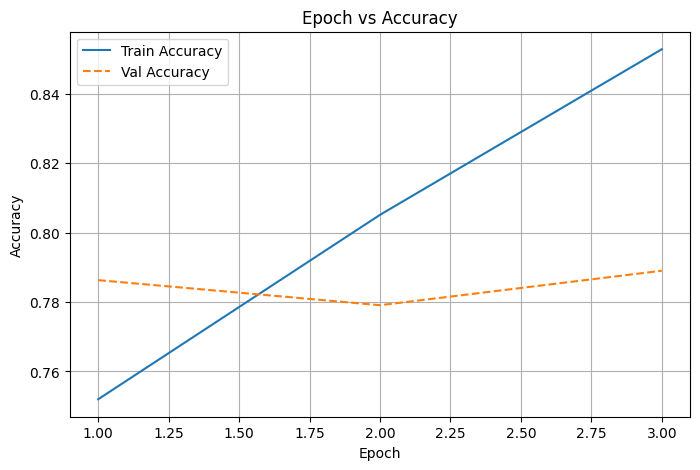

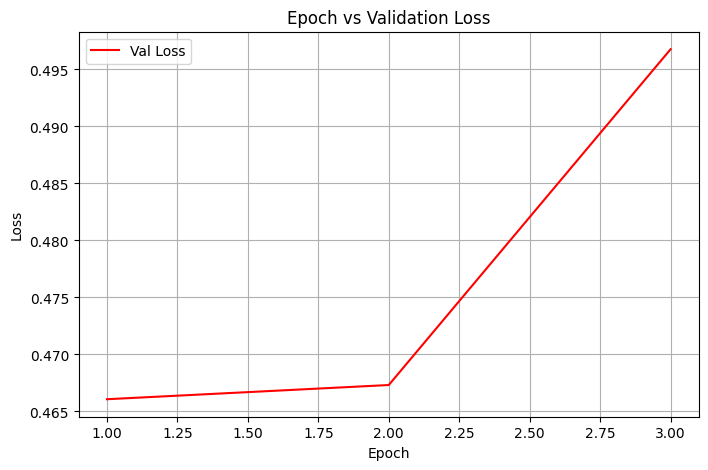

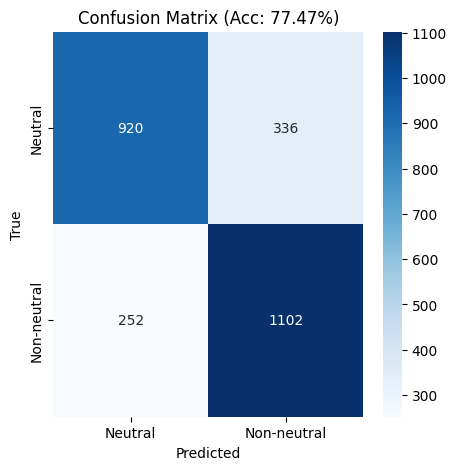

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Non-neutral"], yticklabels=["Neutral", "Non-neutral"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Neutral", "Non-neutral"]))


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.78      0.73      0.76      1256
 Non-neutral       0.77      0.81      0.79      1354

    accuracy                           0.77      2610
   macro avg       0.78      0.77      0.77      2610
weighted avg       0.78      0.77      0.77      2610



In [ ]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     1          0
1     1          1
2     0          0
3     0          0
4     1          1

##### Results analysis:

### Full model training:

In [10]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


###### Whole data:

In [11]:
train_labels = list(map(int, train_full_df["emotion_label"]))
val_labels = list(map(int, val_full_df["emotion_label"]))
test_labels = list(map(int, test_full_df["emotion_label"]))

In [69]:
set(train_full_df["emotion_label"])

{0, 1, 2, 3, 4, 5, 6}

In [70]:
train_full_df["emotion_label"].value_counts()

emotion_label
0    4710
1    1743
4    1205
2    1109
3     683
6     271
5     268
Name: count, dtype: int64

In [12]:
max_len_chars = train_full_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 327


In [13]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [14]:
train_dataset = TextDataset(train_full_df["utterance"].tolist(), train_full_df["emotion_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_full_df["utterance"].tolist(), val_full_df["emotion_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_full_df["utterance"].tolist(), test_full_df["emotion_label"].tolist(), tokenizer)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

###### Training:

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
  class_weight="balanced",
  classes=np.unique(train_labels),
  y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [17]:
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

In [18]:
from transformers import AutoModel, AutoConfig

class CustomClassifier(nn.Module):
  def __init__(self, model_name, num_labels, dropout_prob=0.3):
    super().__init__()
    self.base = AutoModel.from_pretrained(model_name)
    self.base.gradient_checkpointing_enable()
    hidden_size = self.base.config.hidden_size
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

  def forward(self, input_ids, attention_mask, labels=None):
    outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return {'logits': logits}

In [19]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7, ignore_mismatched_sizes=True)
model = CustomClassifier(MODEL_NAME, num_labels=7).to(device)
# config = AutoConfig.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, num_labels=7, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

In [21]:
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
  "cosine",
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_training_steps
)

In [25]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs["logits"]
    loss = loss_fn(logits, batch["labels"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      # logits = outputs.logits
      logits = outputs['logits']
      loss = loss_fn(logits, batch["labels"])

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  class_names = ["neutral", "happy", "anger", "sad", "surprise", "fear", "disgust"]
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix (Acc: {correct / total*100:.2f}%)")
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  return total_loss / len(dataloader), correct / total

In [26]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 70/70 [00:03<00:00, 18.25it/s]


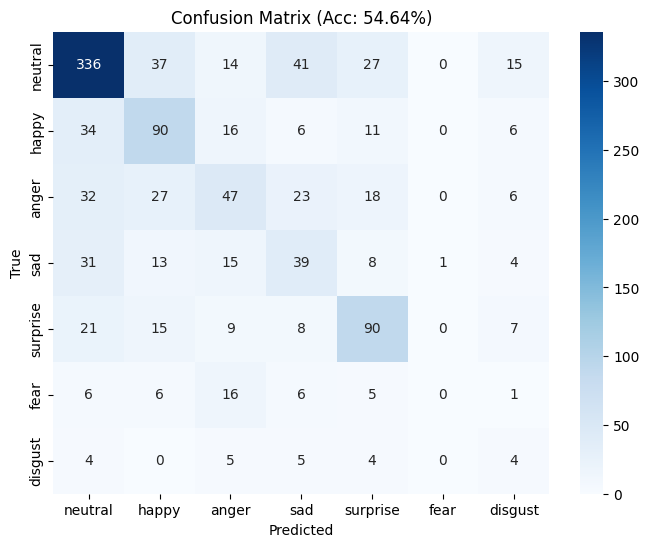


Classification Report:
              precision    recall  f1-score   support

     neutral       0.72      0.71      0.72       470
       happy       0.48      0.55      0.51       163
       anger       0.39      0.31      0.34       153
         sad       0.30      0.35      0.33       111
    surprise       0.55      0.60      0.58       150
        fear       0.00      0.00      0.00        40
     disgust       0.09      0.18      0.12        22

    accuracy                           0.55      1109
   macro avg       0.36      0.39      0.37      1109
weighted avg       0.54      0.55      0.54      1109

Train Loss: 1.7406, Accuracy: 0.4130
Val Loss: 1.6233, Accuracy: 0.5464
Model saved.

Epoch 2/10


100%|██████████| 70/70 [00:03<00:00, 18.57it/s]


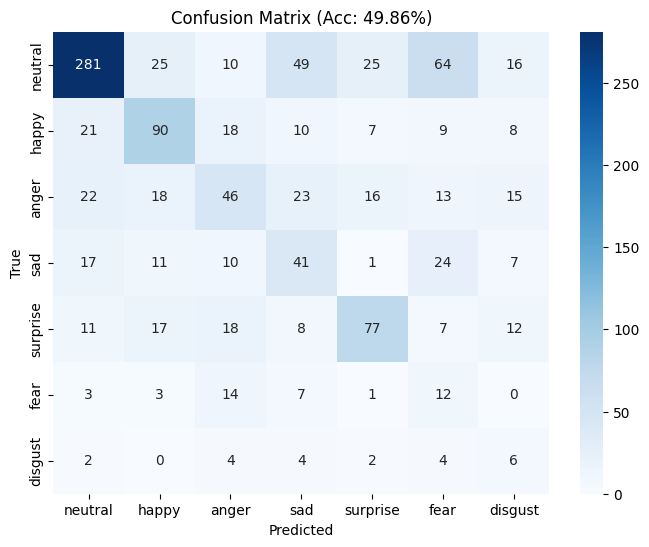


Classification Report:
              precision    recall  f1-score   support

     neutral       0.79      0.60      0.68       470
       happy       0.55      0.55      0.55       163
       anger       0.38      0.30      0.34       153
         sad       0.29      0.37      0.32       111
    surprise       0.60      0.51      0.55       150
        fear       0.09      0.30      0.14        40
     disgust       0.09      0.27      0.14        22

    accuracy                           0.50      1109
   macro avg       0.40      0.42      0.39      1109
weighted avg       0.58      0.50      0.53      1109

Train Loss: 1.4642, Accuracy: 0.5455
Val Loss: 1.4891, Accuracy: 0.4986
Model saved.

Epoch 3/10


100%|██████████| 70/70 [00:03<00:00, 18.51it/s]


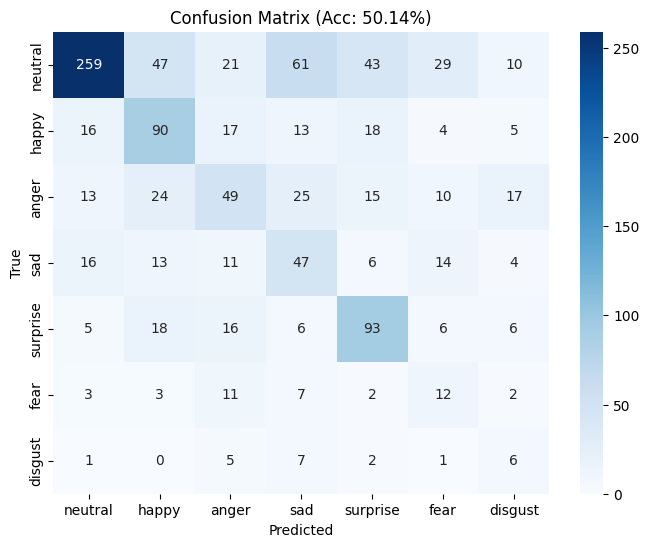


Classification Report:
              precision    recall  f1-score   support

     neutral       0.83      0.55      0.66       470
       happy       0.46      0.55      0.50       163
       anger       0.38      0.32      0.35       153
         sad       0.28      0.42      0.34       111
    surprise       0.52      0.62      0.57       150
        fear       0.16      0.30      0.21        40
     disgust       0.12      0.27      0.17        22

    accuracy                           0.50      1109
   macro avg       0.39      0.43      0.40      1109
weighted avg       0.58      0.50      0.52      1109

Train Loss: 1.1692, Accuracy: 0.6140
Val Loss: 1.5472, Accuracy: 0.5014
No improvement. Patience: 1/4

Epoch 4/10


100%|██████████| 70/70 [00:03<00:00, 18.48it/s]


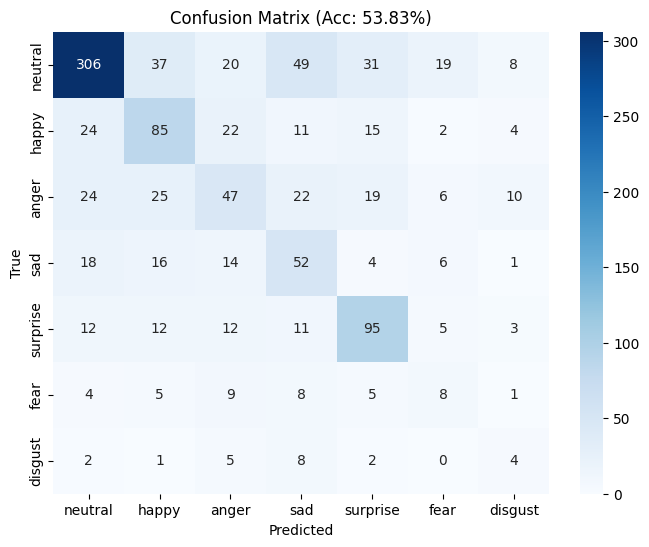


Classification Report:
              precision    recall  f1-score   support

     neutral       0.78      0.65      0.71       470
       happy       0.47      0.52      0.49       163
       anger       0.36      0.31      0.33       153
         sad       0.32      0.47      0.38       111
    surprise       0.56      0.63      0.59       150
        fear       0.17      0.20      0.19        40
     disgust       0.13      0.18      0.15        22

    accuracy                           0.54      1109
   macro avg       0.40      0.42      0.41      1109
weighted avg       0.57      0.54      0.55      1109

Train Loss: 0.8779, Accuracy: 0.6869
Val Loss: 1.6577, Accuracy: 0.5383
No improvement. Patience: 2/4

Epoch 5/10


100%|██████████| 70/70 [00:03<00:00, 18.50it/s]


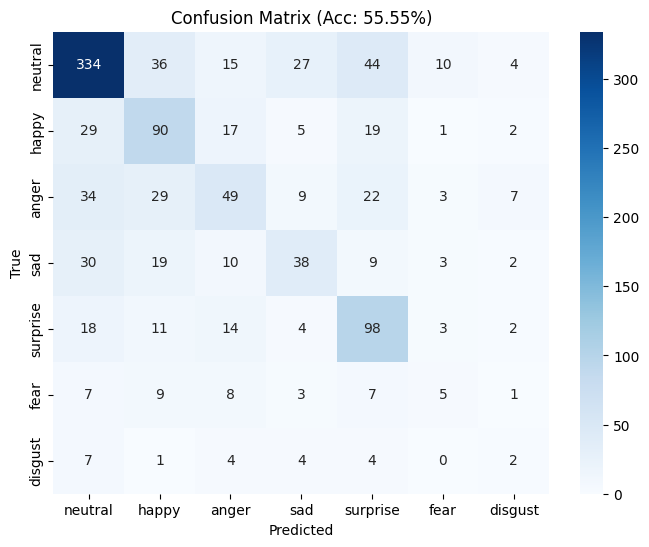


Classification Report:
              precision    recall  f1-score   support

     neutral       0.73      0.71      0.72       470
       happy       0.46      0.55      0.50       163
       anger       0.42      0.32      0.36       153
         sad       0.42      0.34      0.38       111
    surprise       0.48      0.65      0.56       150
        fear       0.20      0.12      0.15        40
     disgust       0.10      0.09      0.10        22

    accuracy                           0.56      1109
   macro avg       0.40      0.40      0.40      1109
weighted avg       0.55      0.56      0.55      1109

Train Loss: 0.6396, Accuracy: 0.7601
Val Loss: 1.9389, Accuracy: 0.5555
No improvement. Patience: 3/4

Epoch 6/10


100%|██████████| 70/70 [00:03<00:00, 18.50it/s]


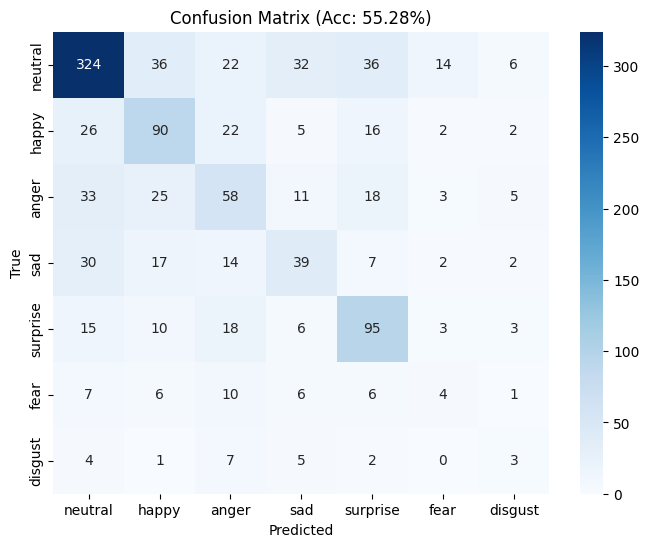


Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.69      0.71       470
       happy       0.49      0.55      0.52       163
       anger       0.38      0.38      0.38       153
         sad       0.38      0.35      0.36       111
    surprise       0.53      0.63      0.58       150
        fear       0.14      0.10      0.12        40
     disgust       0.14      0.14      0.14        22

    accuracy                           0.55      1109
   macro avg       0.40      0.41      0.40      1109
weighted avg       0.55      0.55      0.55      1109

Train Loss: 0.4753, Accuracy: 0.8078
Val Loss: 2.0852, Accuracy: 0.5528
No improvement. Patience: 4/4
Early stopping.


In [27]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 4
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_full_model.pt")
    print("Model saved.")
  else:
    patience_counter += 1
    print(f"No improvement. Patience: {patience_counter}/{patience}")
    if patience_counter >= patience:
      print("Early stopping.")
      break

##### Results analysis:

In [29]:
# model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs['logits'], dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.586


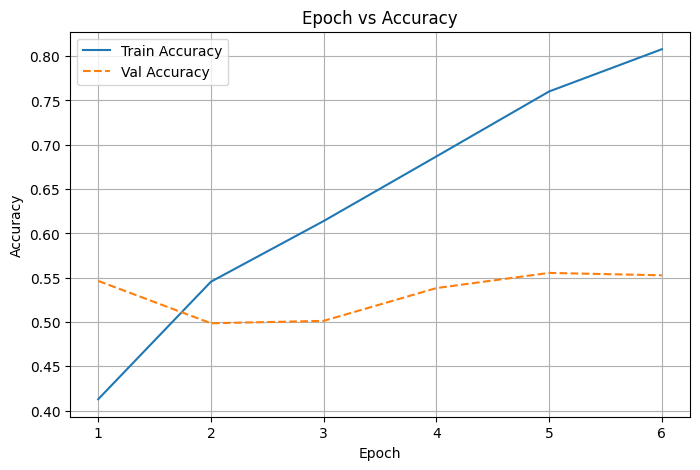

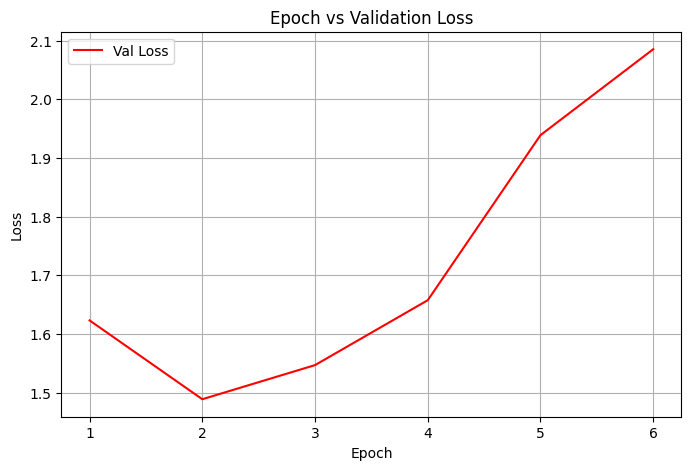

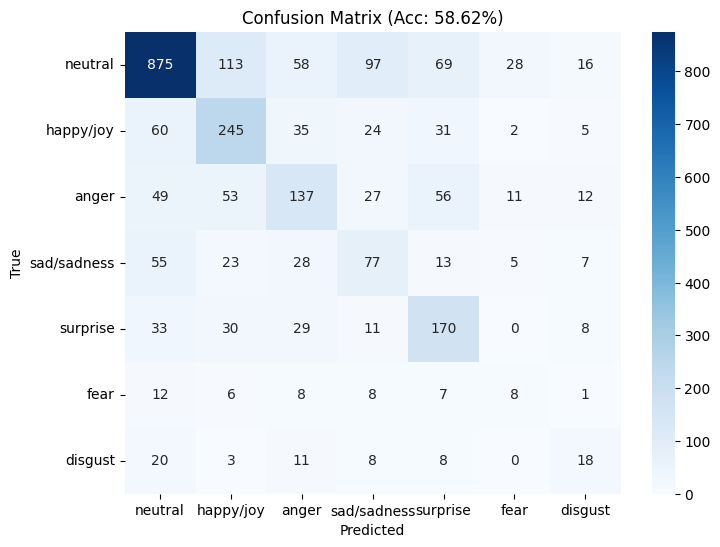

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

class_names = ["neutral", "happy/joy", "anger", "sad/sadness", "surprise", "fear", "disgust"]
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [31]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     neutral       0.79      0.70      0.74      1256
   happy/joy       0.52      0.61      0.56       402
       anger       0.45      0.40      0.42       345
 sad/sadness       0.31      0.37      0.33       208
    surprise       0.48      0.60      0.54       281
        fear       0.15      0.16      0.15        50
     disgust       0.27      0.26      0.27        68

    accuracy                           0.59      2610
   macro avg       0.42      0.44      0.43      2610
weighted avg       0.61      0.59      0.59      2610



In [32]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     4          0
1     2          3
2     0          0
3     0          0
4     1          2

##### Results analysis:

### Full + MC-EIU model training:

ADD CODE FROM DRAFT!!!!!

In [49]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

###### Whole data:

In [50]:
emotion_to_label = {
  "neutral": 0,
  "happy": 1, "joy": 1,
  "anger": 2,
  "sad": 3, "sadness": 3,
  "surprise": 4,
  "fear": 5,
  "disgust": 6
}

def process_full_df(df):
  df_full = df.copy()
  df_full['emotion_label'] = df_full['emotion'].map(emotion_to_label)
  if df_full['emotion_label'].isnull().any():
    print(df_full[df_full['emotion_label'].isnull()]['emotion'].value_counts())
  return df_full

In [51]:
train_full_df = process_full_df(train_df)
val_full_df = process_full_df(val_df)
test_full_df = process_full_df(test_df)

In [52]:
train_full_df = train_full_df[['utterance', 'emotion_label']]
test_full_df = test_full_df[['utterance', 'emotion_label']]
val_full_df = val_full_df[['utterance', 'emotion_label']]

train_full_df.head()

utterance  emotion_label
0  also I was the point person on my company’s tr...              0
1                   You must’ve had your hands full.              0
2                            That I did. That I did.              0
3      So let’s talk a little bit about your duties.              0
4                             My duties?  All right.              4

In [53]:
train_labels = list(map(int, train_full_df["emotion_label"]))
val_labels = list(map(int, val_full_df["emotion_label"]))
test_labels = list(map(int, test_full_df["emotion_label"]))

In [54]:
set(train_full_df["emotion_label"])

{0, 1, 2, 3, 4, 5, 6}

In [55]:
train_full_df["emotion_label"].value_counts()

emotion_label
0    4710
1    1743
4    1205
2    1109
5     976
3     683
6     599
Name: count, dtype: int64

In [56]:
max_len_chars = train_full_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 432


In [57]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [58]:
train_dataset = TextDataset(train_full_df["utterance"].tolist(), train_full_df["emotion_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_full_df["utterance"].tolist(), val_full_df["emotion_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_full_df["utterance"].tolist(), test_full_df["emotion_label"].tolist(), tokenizer)

In [59]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

###### Training:

In [62]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
  class_weight="balanced",
  classes=np.unique(train_labels),
  y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [63]:
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

In [64]:
from transformers import AutoModel, AutoConfig

class CustomClassifier(nn.Module):
  def __init__(self, model_name, num_labels, dropout_prob=0.3):
    super().__init__()
    self.base = AutoModel.from_pretrained(model_name)
    self.base.gradient_checkpointing_enable()
    hidden_size = self.base.config.hidden_size
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

  def forward(self, input_ids, attention_mask, labels=None):
    outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return {'logits': logits}

In [65]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7, ignore_mismatched_sizes=True)
model = CustomClassifier(MODEL_NAME, num_labels=7).to(device)
# config = AutoConfig.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, num_labels=7, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [66]:
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
  "cosine",
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_training_steps
)

In [67]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs["logits"]
    loss = loss_fn(logits, batch["labels"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      # logits = outputs.logits
      logits = outputs['logits']
      loss = loss_fn(logits, batch["labels"])

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  class_names = ["neutral", "happy", "anger", "sad", "surprise", "fear", "disgust"]
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix (Acc: {correct / total*100:.2f}%)")
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  return total_loss / len(dataloader), correct / total

In [68]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 70/70 [00:03<00:00, 17.81it/s]


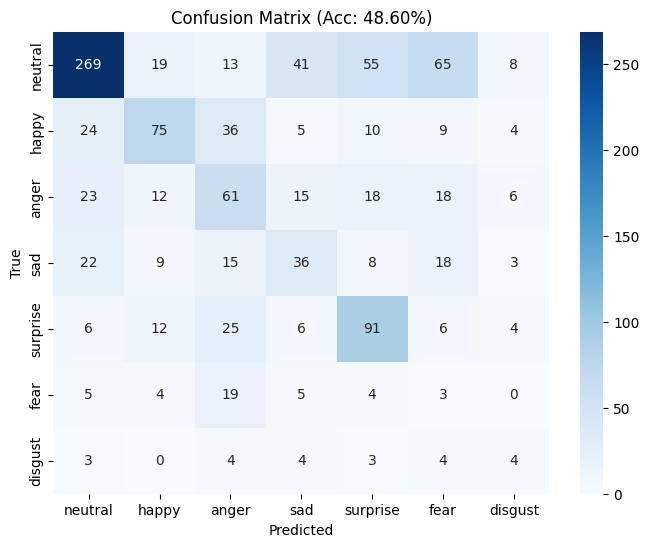


Classification Report:
              precision    recall  f1-score   support

     neutral       0.76      0.57      0.65       470
       happy       0.57      0.46      0.51       163
       anger       0.35      0.40      0.37       153
         sad       0.32      0.32      0.32       111
    surprise       0.48      0.61      0.54       150
        fear       0.02      0.07      0.04        40
     disgust       0.14      0.18      0.16        22

    accuracy                           0.49      1109
   macro avg       0.38      0.37      0.37      1109
weighted avg       0.56      0.49      0.51      1109

Train Loss: 1.7438, Accuracy: 0.3853
Val Loss: 1.5326, Accuracy: 0.4860
Model saved.

Epoch 2/10


100%|██████████| 70/70 [00:03<00:00, 17.81it/s]


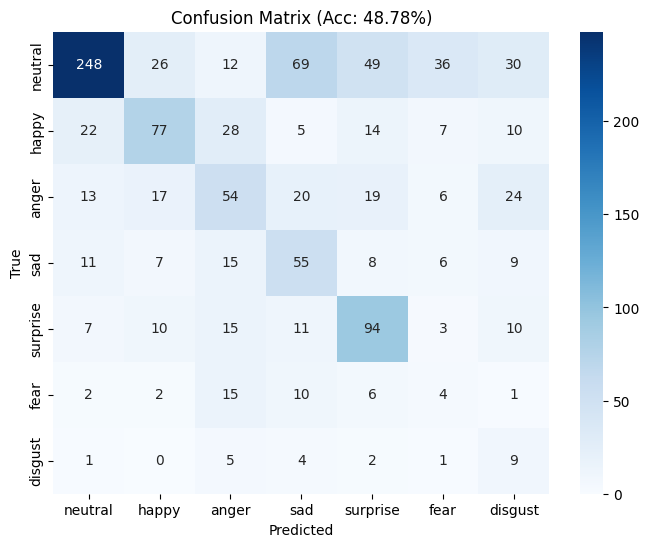


Classification Report:
              precision    recall  f1-score   support

     neutral       0.82      0.53      0.64       470
       happy       0.55      0.47      0.51       163
       anger       0.38      0.35      0.36       153
         sad       0.32      0.50      0.39       111
    surprise       0.49      0.63      0.55       150
        fear       0.06      0.10      0.08        40
     disgust       0.10      0.41      0.16        22

    accuracy                           0.49      1109
   macro avg       0.39      0.43      0.38      1109
weighted avg       0.58      0.49      0.52      1109

Train Loss: 1.4937, Accuracy: 0.5132
Val Loss: 1.4574, Accuracy: 0.4878
Model saved.

Epoch 3/10


100%|██████████| 70/70 [00:03<00:00, 17.77it/s]


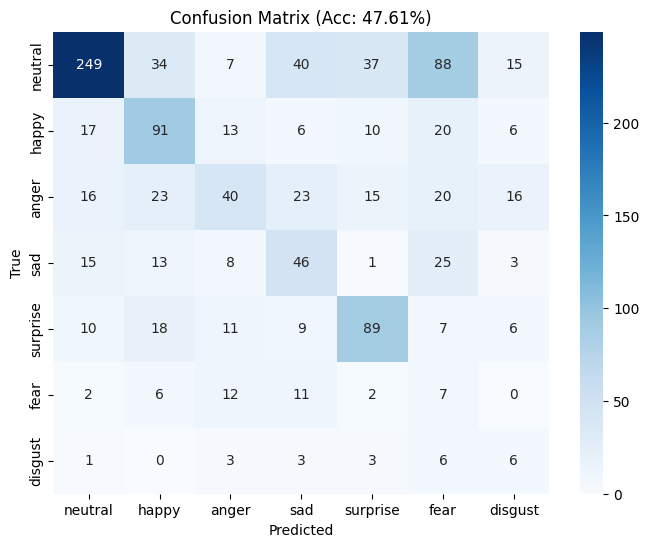


Classification Report:
              precision    recall  f1-score   support

     neutral       0.80      0.53      0.64       470
       happy       0.49      0.56      0.52       163
       anger       0.43      0.26      0.32       153
         sad       0.33      0.41      0.37       111
    surprise       0.57      0.59      0.58       150
        fear       0.04      0.17      0.07        40
     disgust       0.12      0.27      0.16        22

    accuracy                           0.48      1109
   macro avg       0.40      0.40      0.38      1109
weighted avg       0.59      0.48      0.51      1109

Train Loss: 1.2612, Accuracy: 0.5859
Val Loss: 1.5514, Accuracy: 0.4761

Epoch 4/10


100%|██████████| 70/70 [00:03<00:00, 17.71it/s]


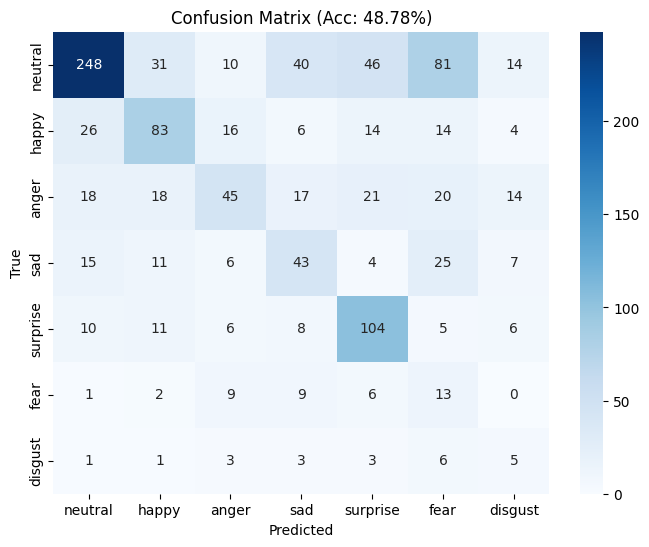


Classification Report:
              precision    recall  f1-score   support

     neutral       0.78      0.53      0.63       470
       happy       0.53      0.51      0.52       163
       anger       0.47      0.29      0.36       153
         sad       0.34      0.39      0.36       111
    surprise       0.53      0.69      0.60       150
        fear       0.08      0.33      0.13        40
     disgust       0.10      0.23      0.14        22

    accuracy                           0.49      1109
   macro avg       0.40      0.42      0.39      1109
weighted avg       0.58      0.49      0.52      1109

Train Loss: 0.9680, Accuracy: 0.6672
Val Loss: 1.6049, Accuracy: 0.4878

Epoch 5/10


100%|██████████| 70/70 [00:03<00:00, 17.74it/s]


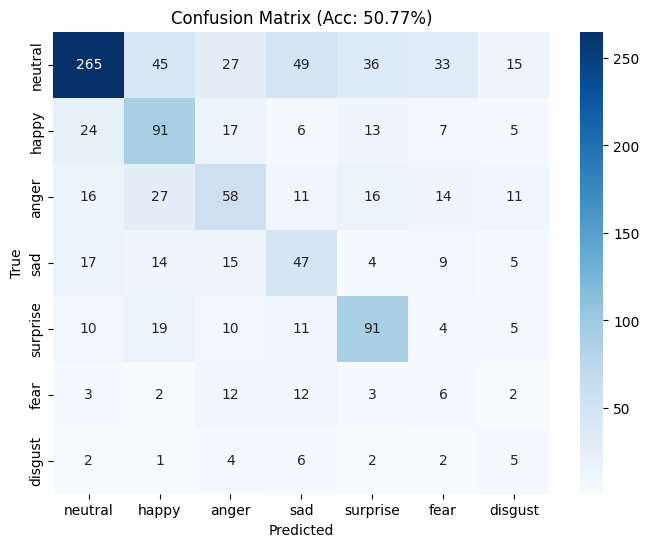


Classification Report:
              precision    recall  f1-score   support

     neutral       0.79      0.56      0.66       470
       happy       0.46      0.56      0.50       163
       anger       0.41      0.38      0.39       153
         sad       0.33      0.42      0.37       111
    surprise       0.55      0.61      0.58       150
        fear       0.08      0.15      0.10        40
     disgust       0.10      0.23      0.14        22

    accuracy                           0.51      1109
   macro avg       0.39      0.42      0.39      1109
weighted avg       0.57      0.51      0.53      1109

Train Loss: 0.6842, Accuracy: 0.7517
Val Loss: 1.7383, Accuracy: 0.5077

Epoch 6/10


100%|██████████| 70/70 [00:03<00:00, 17.71it/s]


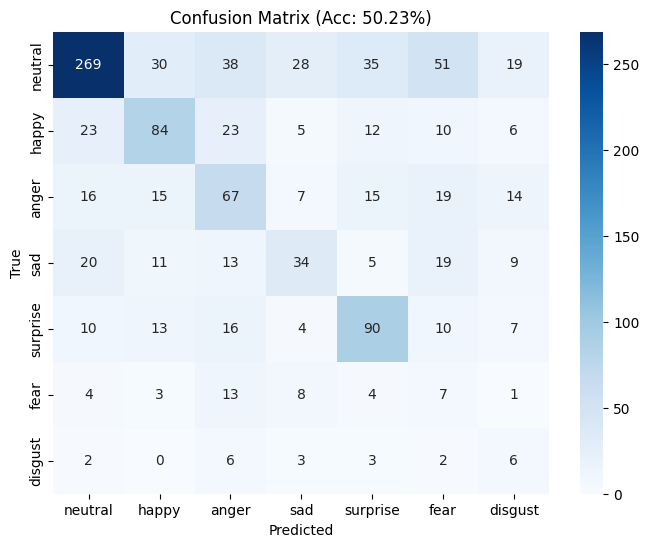


Classification Report:
              precision    recall  f1-score   support

     neutral       0.78      0.57      0.66       470
       happy       0.54      0.52      0.53       163
       anger       0.38      0.44      0.41       153
         sad       0.38      0.31      0.34       111
    surprise       0.55      0.60      0.57       150
        fear       0.06      0.17      0.09        40
     disgust       0.10      0.27      0.14        22

    accuracy                           0.50      1109
   macro avg       0.40      0.41      0.39      1109
weighted avg       0.58      0.50      0.53      1109

Train Loss: 0.4886, Accuracy: 0.8208
Val Loss: 1.9526, Accuracy: 0.5023

Epoch 7/10


100%|██████████| 70/70 [00:03<00:00, 17.67it/s]


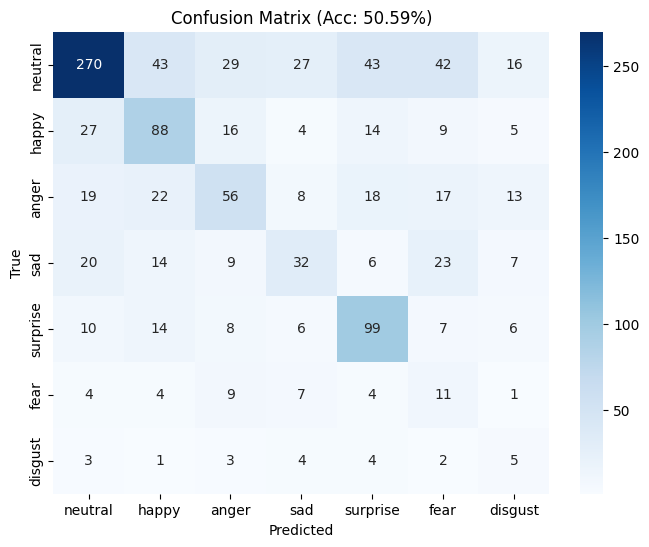


Classification Report:
              precision    recall  f1-score   support

     neutral       0.76      0.57      0.66       470
       happy       0.47      0.54      0.50       163
       anger       0.43      0.37      0.40       153
         sad       0.36      0.29      0.32       111
    surprise       0.53      0.66      0.59       150
        fear       0.10      0.28      0.15        40
     disgust       0.09      0.23      0.13        22

    accuracy                           0.51      1109
   macro avg       0.39      0.42      0.39      1109
weighted avg       0.57      0.51      0.53      1109

Train Loss: 0.3749, Accuracy: 0.8555
Val Loss: 2.0927, Accuracy: 0.5059

Epoch 8/10


100%|██████████| 70/70 [00:03<00:00, 17.69it/s]


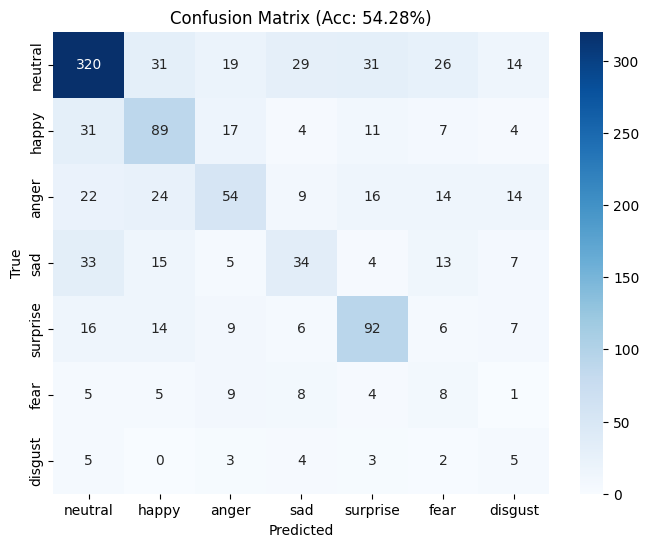


Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.68      0.71       470
       happy       0.50      0.55      0.52       163
       anger       0.47      0.35      0.40       153
         sad       0.36      0.31      0.33       111
    surprise       0.57      0.61      0.59       150
        fear       0.11      0.20      0.14        40
     disgust       0.10      0.23      0.14        22

    accuracy                           0.54      1109
   macro avg       0.41      0.42      0.40      1109
weighted avg       0.57      0.54      0.55      1109

Train Loss: 0.3108, Accuracy: 0.8771
Val Loss: 2.1790, Accuracy: 0.5428

Epoch 9/10


100%|██████████| 70/70 [00:03<00:00, 17.72it/s]


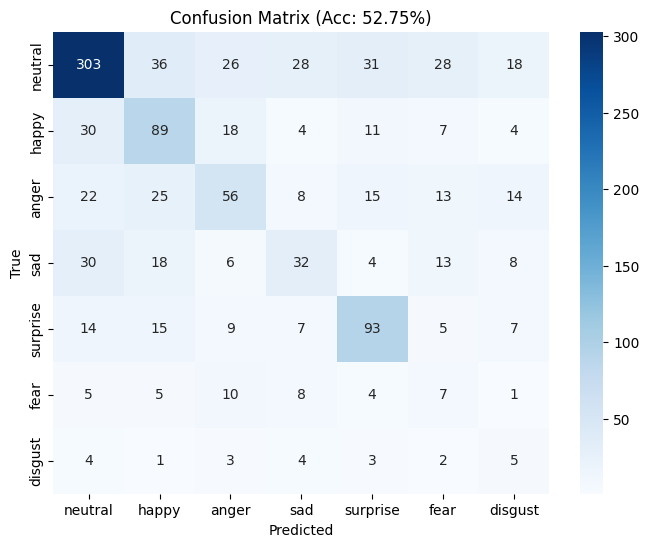


Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.64      0.69       470
       happy       0.47      0.55      0.51       163
       anger       0.44      0.37      0.40       153
         sad       0.35      0.29      0.32       111
    surprise       0.58      0.62      0.60       150
        fear       0.09      0.17      0.12        40
     disgust       0.09      0.23      0.13        22

    accuracy                           0.53      1109
   macro avg       0.39      0.41      0.39      1109
weighted avg       0.56      0.53      0.54      1109

Train Loss: 0.2680, Accuracy: 0.8924
Val Loss: 2.2172, Accuracy: 0.5275

Epoch 10/10


100%|██████████| 70/70 [00:03<00:00, 17.77it/s]


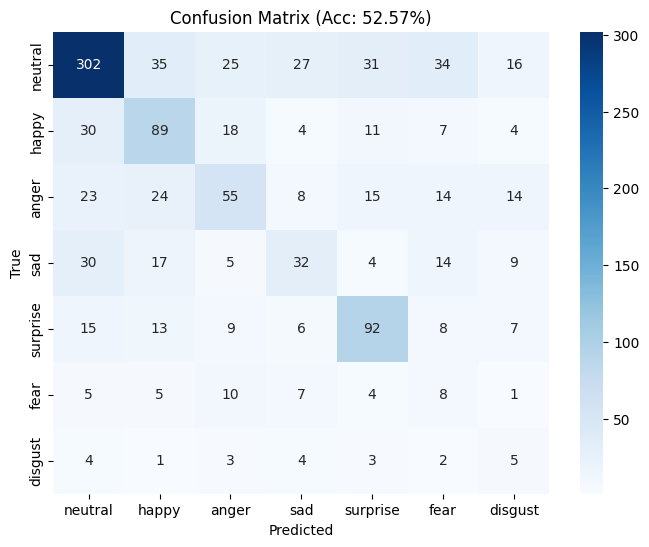


Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.64      0.69       470
       happy       0.48      0.55      0.51       163
       anger       0.44      0.36      0.40       153
         sad       0.36      0.29      0.32       111
    surprise       0.57      0.61      0.59       150
        fear       0.09      0.20      0.13        40
     disgust       0.09      0.23      0.13        22

    accuracy                           0.53      1109
   macro avg       0.40      0.41      0.40      1109
weighted avg       0.56      0.53      0.54      1109

Train Loss: 0.2518, Accuracy: 0.8968
Val Loss: 2.2434, Accuracy: 0.5257


In [69]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 4
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_full_model.pt")
    print("Model saved.")
  # else:
  #   patience_counter += 1
  #   print(f"No improvement. Patience: {patience_counter}/{patience}")
  #   if patience_counter >= patience:
  #     print("Early stopping.")
  #     break

##### Results analysis:

In [70]:
# model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs['logits'], dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.538


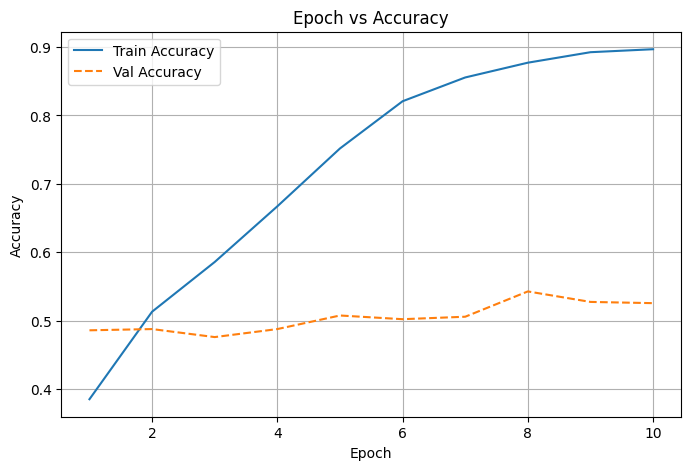

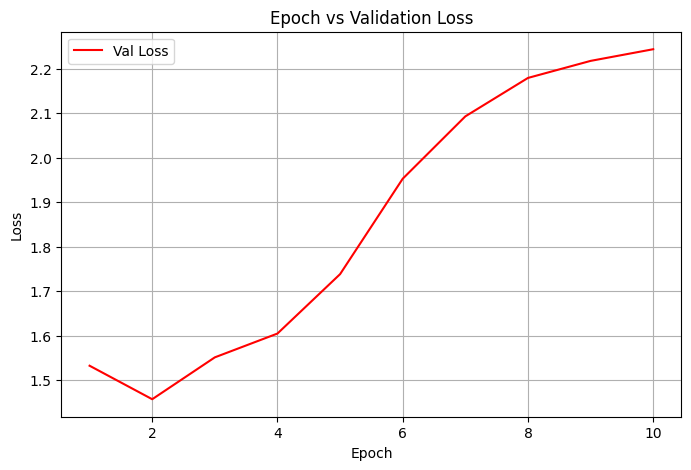

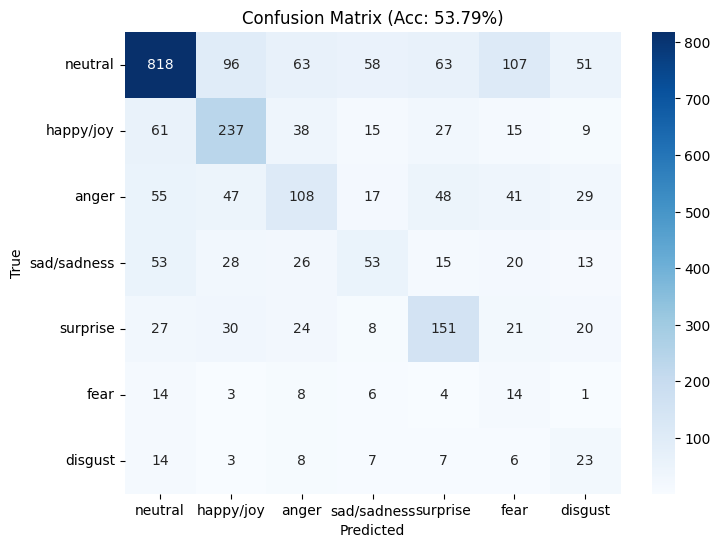

In [71]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

class_names = ["neutral", "happy/joy", "anger", "sad/sadness", "surprise", "fear", "disgust"]
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [72]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     neutral       0.79      0.65      0.71      1256
   happy/joy       0.53      0.59      0.56       402
       anger       0.39      0.31      0.35       345
 sad/sadness       0.32      0.25      0.28       208
    surprise       0.48      0.54      0.51       281
        fear       0.06      0.28      0.10        50
     disgust       0.16      0.34      0.21        68

    accuracy                           0.54      2610
   macro avg       0.39      0.42      0.39      2610
weighted avg       0.59      0.54      0.56      2610



In [73]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     4          0
1     2          0
2     0          0
3     0          0
4     1          2

##### Results analysis:

### Non-neutral + MC-EIU model training:

ADD CODE FROM DRAFT!!!!!

In [74]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

###### Whole data:

In [77]:
emotion_to_label = {
  "happy": 0, "joy": 0,
  "anger": 1,
  "sad": 2, "sadness": 2,
  "surprise": 3,
  "fear": 4,
  "disgust": 5
}

def process_full_df(df):
  df_full = df.copy()
  df_full = df_full[df_full['emotion'].isin(emotion_to_label.keys())]
  df_full['emotion_label'] = df_full['emotion'].map(emotion_to_label)
  if df_full['emotion_label'].isnull().any():
    print(df_full[df_full['emotion_label'].isnull()]['emotion'].value_counts())
  return df_full

In [78]:
train_full_df = process_full_df(train_df)
val_full_df = process_full_df(val_df)
test_full_df = process_full_df(test_df)

In [79]:
train_full_df = train_full_df[['utterance', 'emotion_label']]
test_full_df = test_full_df[['utterance', 'emotion_label']]
val_full_df = val_full_df[['utterance', 'emotion_label']]

train_full_df.head()

utterance  emotion_label
4                              My duties?  All right.              3
10                             No don’t I beg of you!              4
12                                           Really?!              3
14  But then who? The waitress I went out with las...              3
15                               You know? Forget it!              2

In [80]:
train_labels = list(map(int, train_full_df["emotion_label"]))
val_labels = list(map(int, val_full_df["emotion_label"]))
test_labels = list(map(int, test_full_df["emotion_label"]))

In [81]:
set(train_full_df["emotion_label"])

{0, 1, 2, 3, 4, 5}

In [82]:
train_full_df["emotion_label"].value_counts()

emotion_label
0    1743
3    1205
1    1109
4     976
2     683
5     599
Name: count, dtype: int64

In [83]:
max_len_chars = train_full_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 432


In [84]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [85]:
train_dataset = TextDataset(train_full_df["utterance"].tolist(), train_full_df["emotion_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_full_df["utterance"].tolist(), val_full_df["emotion_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_full_df["utterance"].tolist(), test_full_df["emotion_label"].tolist(), tokenizer)

In [86]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

###### Training:

In [87]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
  class_weight="balanced",
  classes=np.unique(train_labels),
  y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [88]:
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

In [89]:
from transformers import AutoModel, AutoConfig

class CustomClassifier(nn.Module):
  def __init__(self, model_name, num_labels, dropout_prob=0.3):
    super().__init__()
    self.base = AutoModel.from_pretrained(model_name)
    self.base.gradient_checkpointing_enable()
    hidden_size = self.base.config.hidden_size
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

  def forward(self, input_ids, attention_mask, labels=None):
    outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return {'logits': logits}

In [90]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7, ignore_mismatched_sizes=True)
model = CustomClassifier(MODEL_NAME, num_labels=6).to(device)
# config = AutoConfig.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, num_labels=7, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

In [91]:
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
  "cosine",
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_training_steps
)

In [95]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs["logits"]
    loss = loss_fn(logits, batch["labels"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      # logits = outputs.logits
      logits = outputs['logits']
      loss = loss_fn(logits, batch["labels"])

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  class_names = ["happy", "anger", "sad", "surprise", "fear", "disgust"]
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix (Acc: {correct / total*100:.2f}%)")
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  return total_loss / len(dataloader), correct / total

In [96]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 40/40 [00:02<00:00, 17.81it/s]


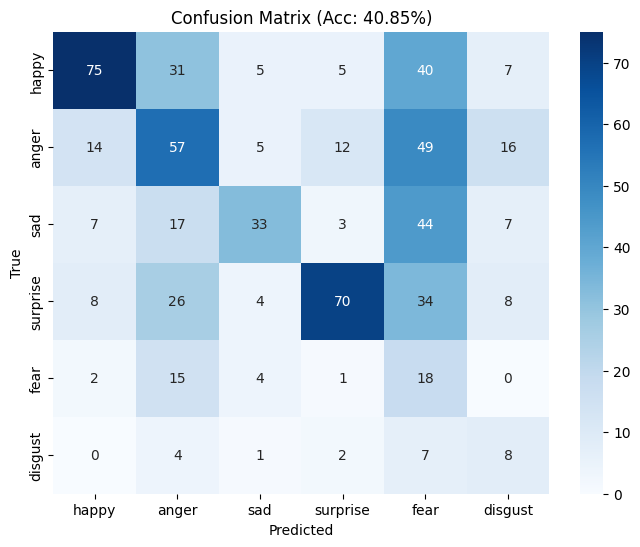


Classification Report:
              precision    recall  f1-score   support

       happy       0.71      0.46      0.56       163
       anger       0.38      0.37      0.38       153
         sad       0.63      0.30      0.40       111
    surprise       0.75      0.47      0.58       150
        fear       0.09      0.45      0.16        40
     disgust       0.17      0.36      0.24        22

    accuracy                           0.41       639
   macro avg       0.46      0.40      0.38       639
weighted avg       0.57      0.41      0.46       639

Train Loss: 1.4102, Accuracy: 0.4964
Val Loss: 1.5053, Accuracy: 0.4085
Model saved.

Epoch 2/10


100%|██████████| 40/40 [00:02<00:00, 17.64it/s]


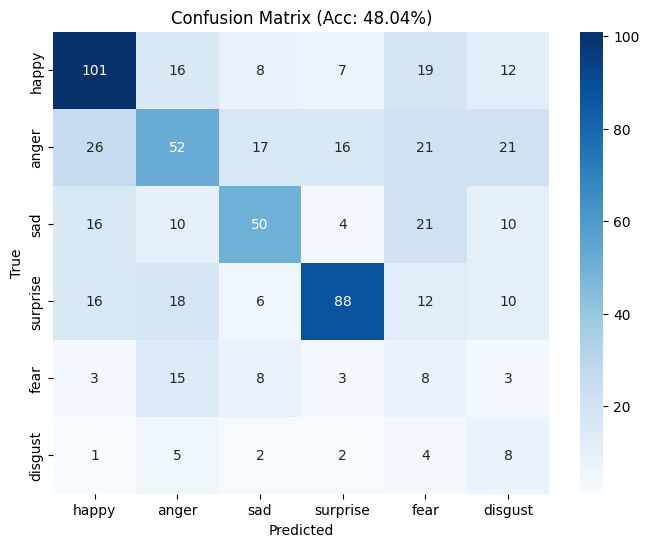


Classification Report:
              precision    recall  f1-score   support

       happy       0.62      0.62      0.62       163
       anger       0.45      0.34      0.39       153
         sad       0.55      0.45      0.50       111
    surprise       0.73      0.59      0.65       150
        fear       0.09      0.20      0.13        40
     disgust       0.12      0.36      0.19        22

    accuracy                           0.48       639
   macro avg       0.43      0.43      0.41       639
weighted avg       0.54      0.48      0.50       639

Train Loss: 1.1824, Accuracy: 0.5867
Val Loss: 1.4328, Accuracy: 0.4804
Model saved.

Epoch 3/10


100%|██████████| 40/40 [00:02<00:00, 17.64it/s]


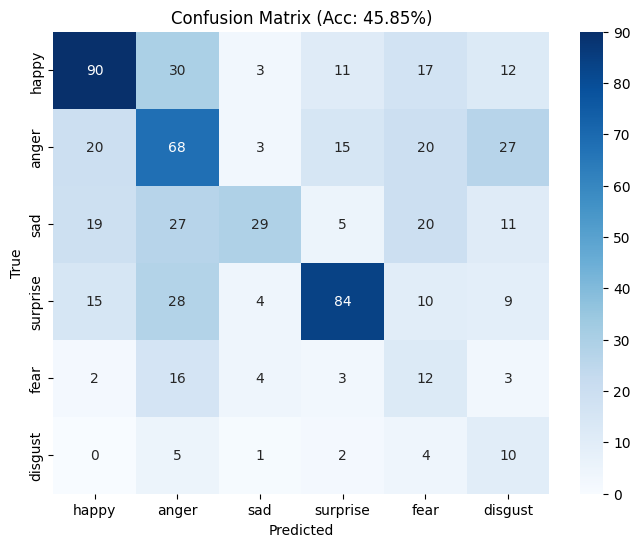


Classification Report:
              precision    recall  f1-score   support

       happy       0.62      0.55      0.58       163
       anger       0.39      0.44      0.42       153
         sad       0.66      0.26      0.37       111
    surprise       0.70      0.56      0.62       150
        fear       0.14      0.30      0.20        40
     disgust       0.14      0.45      0.21        22

    accuracy                           0.46       639
   macro avg       0.44      0.43      0.40       639
weighted avg       0.54      0.46      0.48       639

Train Loss: 0.9052, Accuracy: 0.7023
Val Loss: 1.6192, Accuracy: 0.4585

Epoch 4/10


100%|██████████| 40/40 [00:02<00:00, 17.62it/s]


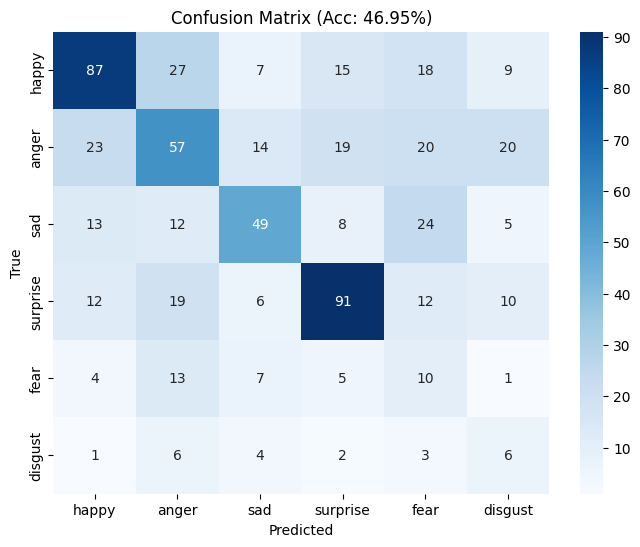


Classification Report:
              precision    recall  f1-score   support

       happy       0.62      0.53      0.57       163
       anger       0.43      0.37      0.40       153
         sad       0.56      0.44      0.49       111
    surprise       0.65      0.61      0.63       150
        fear       0.11      0.25      0.16        40
     disgust       0.12      0.27      0.16        22

    accuracy                           0.47       639
   macro avg       0.42      0.41      0.40       639
weighted avg       0.52      0.47      0.49       639

Train Loss: 0.6268, Accuracy: 0.7927
Val Loss: 1.6663, Accuracy: 0.4695

Epoch 5/10


100%|██████████| 40/40 [00:02<00:00, 17.54it/s]


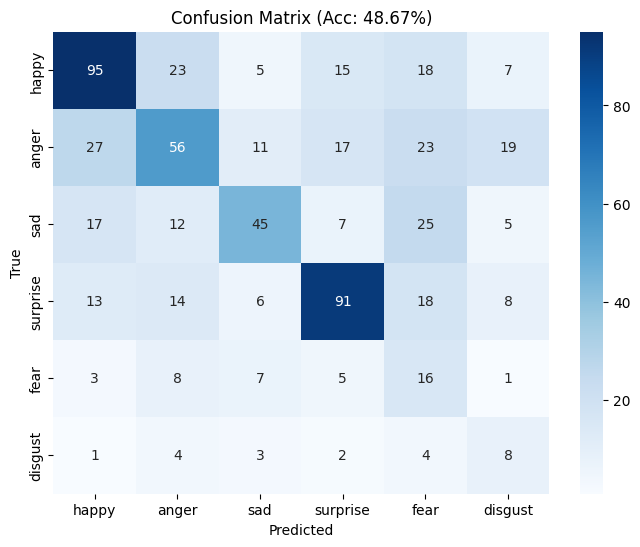


Classification Report:
              precision    recall  f1-score   support

       happy       0.61      0.58      0.60       163
       anger       0.48      0.37      0.41       153
         sad       0.58      0.41      0.48       111
    surprise       0.66      0.61      0.63       150
        fear       0.15      0.40      0.22        40
     disgust       0.17      0.36      0.23        22

    accuracy                           0.49       639
   macro avg       0.44      0.45      0.43       639
weighted avg       0.54      0.49      0.51       639

Train Loss: 0.4294, Accuracy: 0.8605
Val Loss: 1.8598, Accuracy: 0.4867

Epoch 6/10


100%|██████████| 40/40 [00:02<00:00, 17.71it/s]


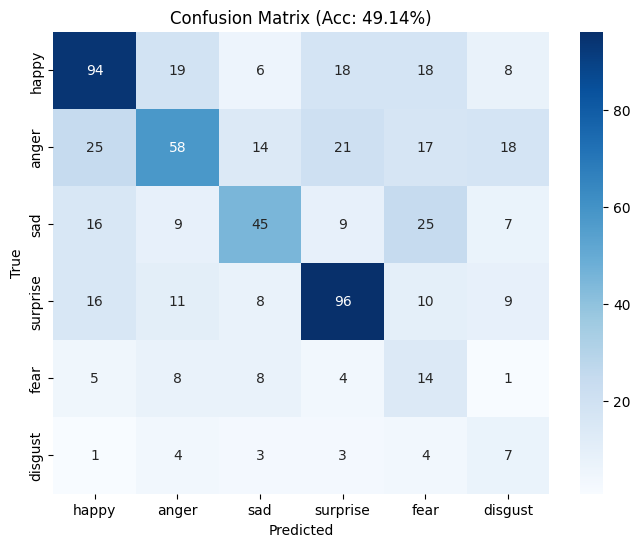


Classification Report:
              precision    recall  f1-score   support

       happy       0.60      0.58      0.59       163
       anger       0.53      0.38      0.44       153
         sad       0.54      0.41      0.46       111
    surprise       0.64      0.64      0.64       150
        fear       0.16      0.35      0.22        40
     disgust       0.14      0.32      0.19        22

    accuracy                           0.49       639
   macro avg       0.43      0.44      0.42       639
weighted avg       0.54      0.49      0.51       639

Train Loss: 0.3203, Accuracy: 0.8994
Val Loss: 2.0076, Accuracy: 0.4914

Epoch 7/10


100%|██████████| 40/40 [00:02<00:00, 17.62it/s]


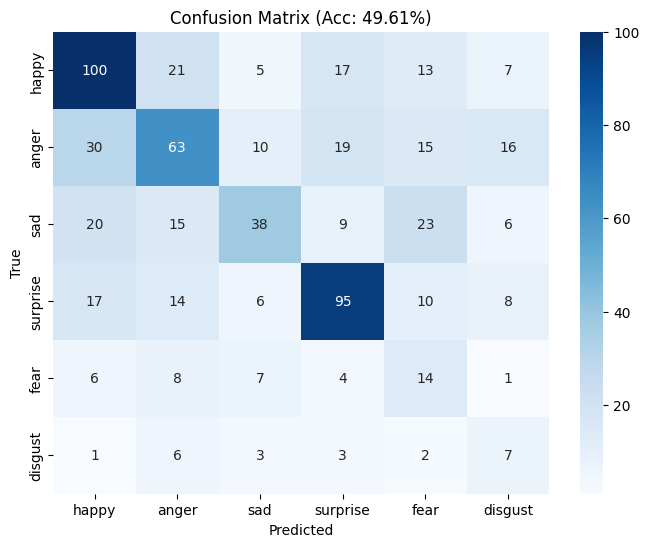


Classification Report:
              precision    recall  f1-score   support

       happy       0.57      0.61      0.59       163
       anger       0.50      0.41      0.45       153
         sad       0.55      0.34      0.42       111
    surprise       0.65      0.63      0.64       150
        fear       0.18      0.35      0.24        40
     disgust       0.16      0.32      0.21        22

    accuracy                           0.50       639
   macro avg       0.43      0.44      0.43       639
weighted avg       0.53      0.50      0.50       639

Train Loss: 0.2563, Accuracy: 0.9215
Val Loss: 2.0977, Accuracy: 0.4961

Epoch 8/10


100%|██████████| 40/40 [00:02<00:00, 17.69it/s]


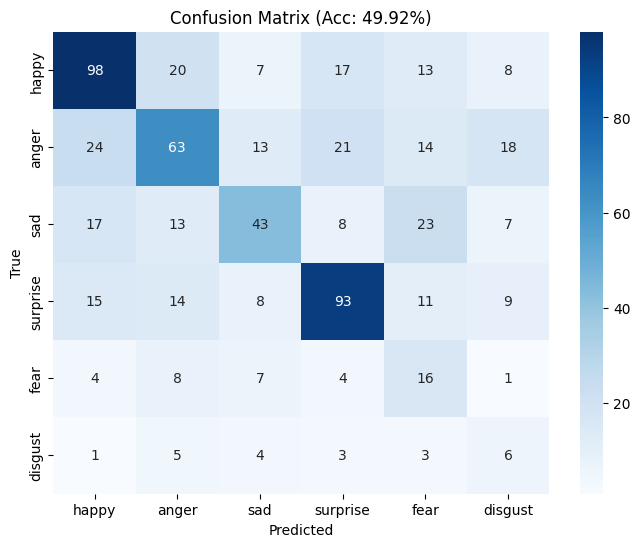


Classification Report:
              precision    recall  f1-score   support

       happy       0.62      0.60      0.61       163
       anger       0.51      0.41      0.46       153
         sad       0.52      0.39      0.45       111
    surprise       0.64      0.62      0.63       150
        fear       0.20      0.40      0.27        40
     disgust       0.12      0.27      0.17        22

    accuracy                           0.50       639
   macro avg       0.44      0.45      0.43       639
weighted avg       0.54      0.50      0.51       639

Train Loss: 0.2274, Accuracy: 0.9295
Val Loss: 2.0950, Accuracy: 0.4992

Epoch 9/10


100%|██████████| 40/40 [00:02<00:00, 17.57it/s]


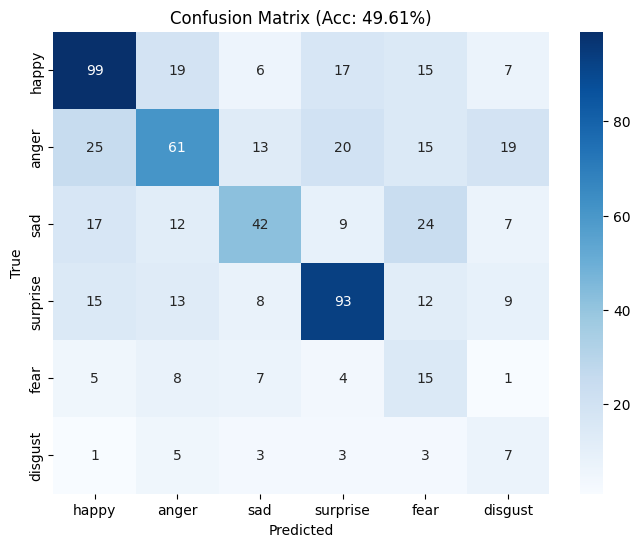


Classification Report:
              precision    recall  f1-score   support

       happy       0.61      0.61      0.61       163
       anger       0.52      0.40      0.45       153
         sad       0.53      0.38      0.44       111
    surprise       0.64      0.62      0.63       150
        fear       0.18      0.38      0.24        40
     disgust       0.14      0.32      0.19        22

    accuracy                           0.50       639
   macro avg       0.44      0.45      0.43       639
weighted avg       0.54      0.50      0.51       639

Train Loss: 0.2141, Accuracy: 0.9316
Val Loss: 2.1190, Accuracy: 0.4961

Epoch 10/10


100%|██████████| 40/40 [00:02<00:00, 17.65it/s]


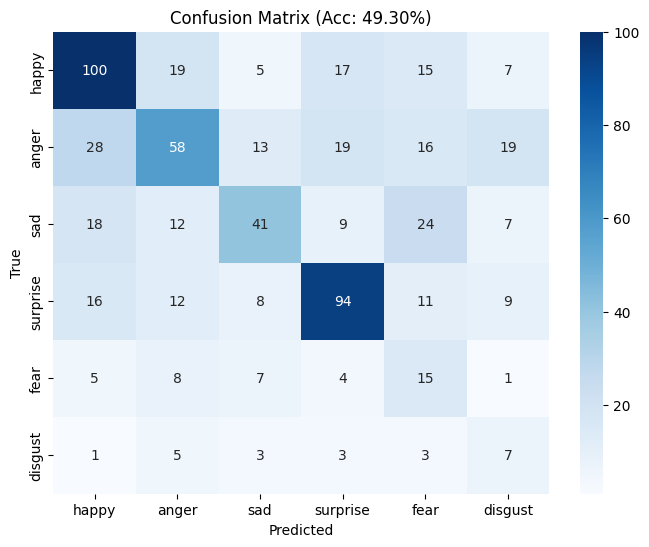


Classification Report:
              precision    recall  f1-score   support

       happy       0.60      0.61      0.60       163
       anger       0.51      0.38      0.43       153
         sad       0.53      0.37      0.44       111
    surprise       0.64      0.63      0.64       150
        fear       0.18      0.38      0.24        40
     disgust       0.14      0.32      0.19        22

    accuracy                           0.49       639
   macro avg       0.43      0.45      0.42       639
weighted avg       0.53      0.49      0.50       639

Train Loss: 0.2104, Accuracy: 0.9327
Val Loss: 2.1544, Accuracy: 0.4930


In [97]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 4
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_full_model.pt")
    print("Model saved.")
  # else:
  #   patience_counter += 1
  #   print(f"No improvement. Patience: {patience_counter}/{patience}")
  #   if patience_counter >= patience:
  #     print("Early stopping.")
  #     break

##### Results analysis:

In [98]:
# model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs['logits'], dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.509


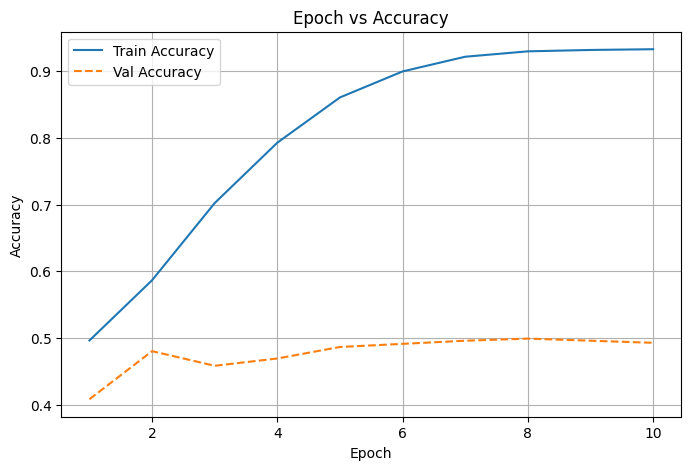

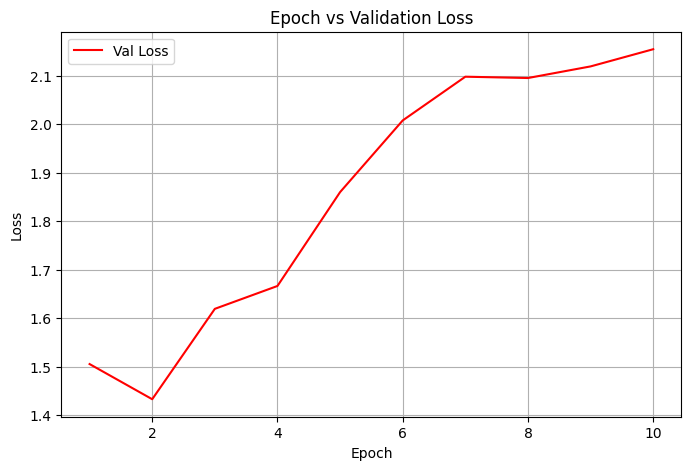

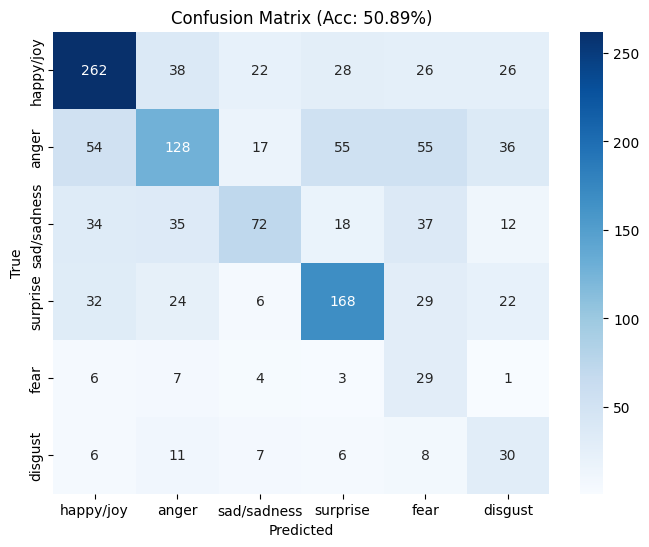

In [99]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

class_names = ["happy/joy", "anger", "sad/sadness", "surprise", "fear", "disgust"]
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [100]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   happy/joy       0.66      0.65      0.66       402
       anger       0.53      0.37      0.44       345
 sad/sadness       0.56      0.35      0.43       208
    surprise       0.60      0.60      0.60       281
        fear       0.16      0.58      0.25        50
     disgust       0.24      0.44      0.31        68

    accuracy                           0.51      1354
   macro avg       0.46      0.50      0.45      1354
weighted avg       0.56      0.51      0.52      1354



In [101]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     3          3
1     1          2
2     0          1
3     0          1
4     0          0

### Non-neutral + MC-EIU normalized model training:

ADD CODE FROM DRAFT!!!!!

In [ ]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

###### Whole data:

In [102]:
emotion_to_label = {
  "happy": 0, "joy": 0,
  "anger": 1,
  "sad": 2, "sadness": 2,
  "surprise": 3,
  "fear": 4,
  "disgust": 5
}

def process_full_df(df):
  df_full = df.copy()
  df_full = df_full[df_full['emotion'].isin(emotion_to_label.keys())]
  df_full['emotion_label'] = df_full['emotion'].map(emotion_to_label)
  if df_full['emotion_label'].isnull().any():
    print(df_full[df_full['emotion_label'].isnull()]['emotion'].value_counts())
  return df_full

In [103]:
train_full_df = process_full_df(train_df)
val_full_df = process_full_df(val_df)
test_full_df = process_full_df(test_df)

In [104]:
train_full_df = train_full_df[['utterance', 'emotion_label']]
test_full_df = test_full_df[['utterance', 'emotion_label']]
val_full_df = val_full_df[['utterance', 'emotion_label']]

train_full_df.head()

utterance  emotion_label
4                              My duties?  All right.              3
10                             No don’t I beg of you!              4
12                                           Really?!              3
14  But then who? The waitress I went out with las...              3
15                               You know? Forget it!              2

In [106]:
train_full_df['emotion_label'].value_counts()

emotion_label
0    1743
3    1205
1    1109
4     976
2     683
5     599
Name: count, dtype: int64

In [108]:
def balance_to_least_class(df, label_col='emotion_label'):
  min_count = df[label_col].value_counts().min()

  balanced_df = (
    df.groupby(label_col, group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
  )

  return balanced_df

In [109]:
train_full_df = balance_to_least_class(train_full_df)

<ipython-input-108-d41488550ab5>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


In [110]:
train_full_df['emotion_label'].value_counts()

emotion_label
0    599
1    599
2    599
3    599
4    599
5    599
Name: count, dtype: int64

In [111]:
train_labels = list(map(int, train_full_df["emotion_label"]))
val_labels = list(map(int, val_full_df["emotion_label"]))
test_labels = list(map(int, test_full_df["emotion_label"]))

In [112]:
set(train_full_df["emotion_label"])

{0, 1, 2, 3, 4, 5}

In [113]:
train_full_df["emotion_label"].value_counts()

emotion_label
0    599
1    599
2    599
3    599
4    599
5    599
Name: count, dtype: int64

In [114]:
max_len_chars = train_full_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 412


In [115]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [116]:
train_dataset = TextDataset(train_full_df["utterance"].tolist(), train_full_df["emotion_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_full_df["utterance"].tolist(), val_full_df["emotion_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_full_df["utterance"].tolist(), test_full_df["emotion_label"].tolist(), tokenizer)

In [118]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [119]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
  class_weight="balanced",
  classes=np.unique(train_labels),
  y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [120]:
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

In [121]:
from transformers import AutoModel, AutoConfig

class CustomClassifier(nn.Module):
  def __init__(self, model_name, num_labels, dropout_prob=0.3):
    super().__init__()
    self.base = AutoModel.from_pretrained(model_name)
    self.base.gradient_checkpointing_enable()
    hidden_size = self.base.config.hidden_size
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

  def forward(self, input_ids, attention_mask, labels=None):
    outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return {'logits': logits}

In [122]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7, ignore_mismatched_sizes=True)
model = CustomClassifier(MODEL_NAME, num_labels=6).to(device)
# config = AutoConfig.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, num_labels=7, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

In [123]:
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
  "cosine",
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_training_steps
)

In [124]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs["logits"]
    loss = loss_fn(logits, batch["labels"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      # logits = outputs.logits
      logits = outputs['logits']
      loss = loss_fn(logits, batch["labels"])

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  class_names = ["happy", "anger", "sad", "surprise", "fear", "disgust"]
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix (Acc: {correct / total*100:.2f}%)")
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  return total_loss / len(dataloader), correct / total

In [125]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


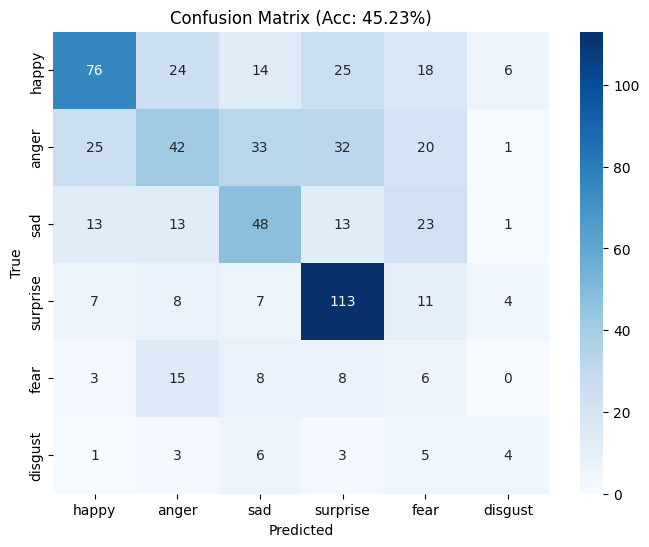


Classification Report:
              precision    recall  f1-score   support

       happy       0.61      0.47      0.53       163
       anger       0.40      0.27      0.33       153
         sad       0.41      0.43      0.42       111
    surprise       0.58      0.75      0.66       150
        fear       0.07      0.15      0.10        40
     disgust       0.25      0.18      0.21        22

    accuracy                           0.45       639
   macro avg       0.39      0.38      0.37       639
weighted avg       0.47      0.45      0.45       639

Train Loss: 1.7228, Accuracy: 0.2741
Val Loss: 1.4572, Accuracy: 0.4523
Model saved.

Epoch 2/10


100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


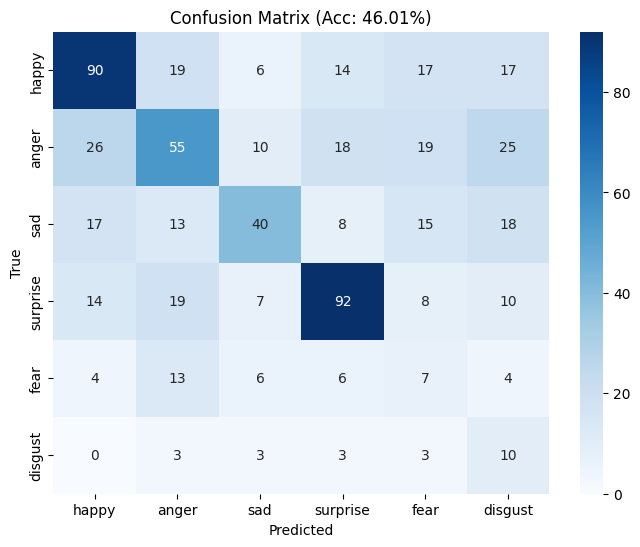


Classification Report:
              precision    recall  f1-score   support

       happy       0.60      0.55      0.57       163
       anger       0.45      0.36      0.40       153
         sad       0.56      0.36      0.44       111
    surprise       0.65      0.61      0.63       150
        fear       0.10      0.17      0.13        40
     disgust       0.12      0.45      0.19        22

    accuracy                           0.46       639
   macro avg       0.41      0.42      0.39       639
weighted avg       0.52      0.46      0.48       639

Train Loss: 1.4623, Accuracy: 0.4391
Val Loss: 1.4120, Accuracy: 0.4601
Model saved.

Epoch 3/10


100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


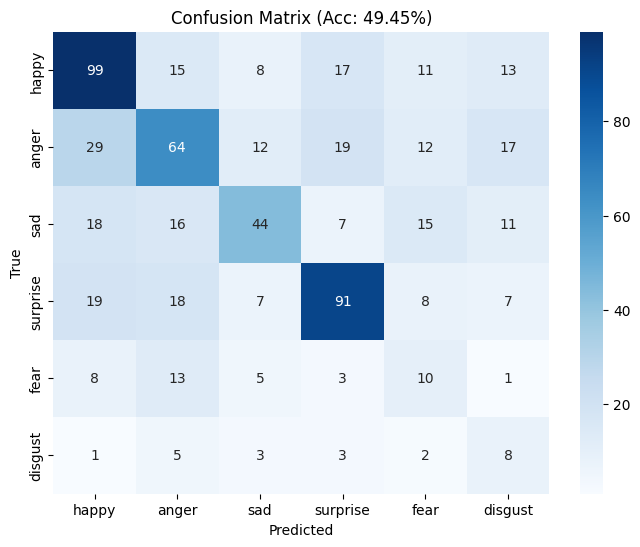


Classification Report:
              precision    recall  f1-score   support

       happy       0.57      0.61      0.59       163
       anger       0.49      0.42      0.45       153
         sad       0.56      0.40      0.46       111
    surprise       0.65      0.61      0.63       150
        fear       0.17      0.25      0.20        40
     disgust       0.14      0.36      0.20        22

    accuracy                           0.49       639
   macro avg       0.43      0.44      0.42       639
weighted avg       0.53      0.49      0.51       639

Train Loss: 1.2757, Accuracy: 0.5250
Val Loss: 1.3886, Accuracy: 0.4945
Model saved.

Epoch 4/10


100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


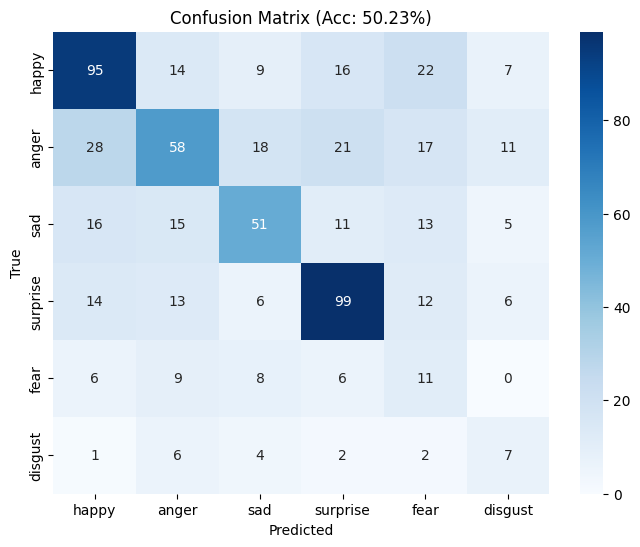


Classification Report:
              precision    recall  f1-score   support

       happy       0.59      0.58      0.59       163
       anger       0.50      0.38      0.43       153
         sad       0.53      0.46      0.49       111
    surprise       0.64      0.66      0.65       150
        fear       0.14      0.28      0.19        40
     disgust       0.19      0.32      0.24        22

    accuracy                           0.50       639
   macro avg       0.43      0.45      0.43       639
weighted avg       0.53      0.50      0.51       639

Train Loss: 1.0773, Accuracy: 0.6141
Val Loss: 1.4083, Accuracy: 0.5023

Epoch 5/10


100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


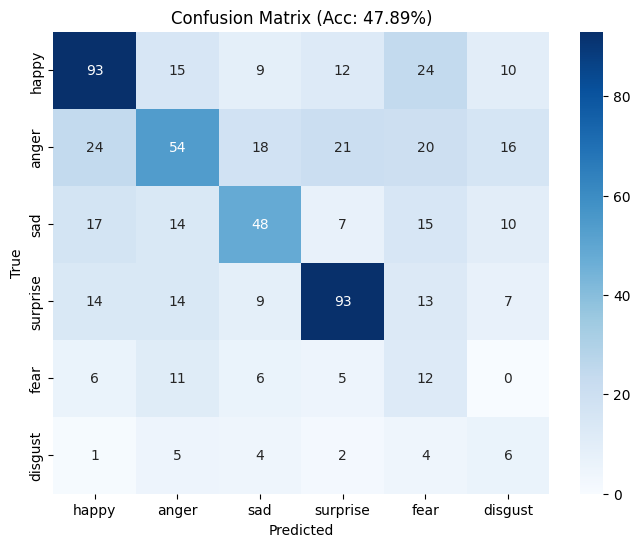


Classification Report:
              precision    recall  f1-score   support

       happy       0.60      0.57      0.58       163
       anger       0.48      0.35      0.41       153
         sad       0.51      0.43      0.47       111
    surprise       0.66      0.62      0.64       150
        fear       0.14      0.30      0.19        40
     disgust       0.12      0.27      0.17        22

    accuracy                           0.48       639
   macro avg       0.42      0.42      0.41       639
weighted avg       0.52      0.48      0.50       639

Train Loss: 0.8581, Accuracy: 0.7084
Val Loss: 1.5129, Accuracy: 0.4789

Epoch 6/10


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


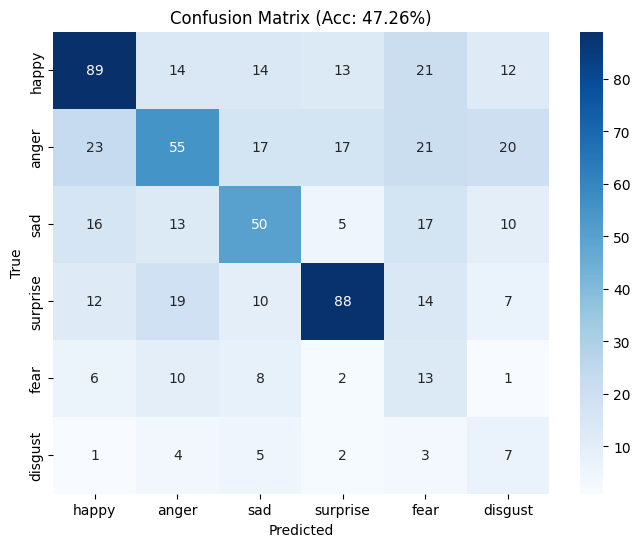


Classification Report:
              precision    recall  f1-score   support

       happy       0.61      0.55      0.57       163
       anger       0.48      0.36      0.41       153
         sad       0.48      0.45      0.47       111
    surprise       0.69      0.59      0.64       150
        fear       0.15      0.33      0.20        40
     disgust       0.12      0.32      0.18        22

    accuracy                           0.47       639
   macro avg       0.42      0.43      0.41       639
weighted avg       0.53      0.47      0.49       639

Train Loss: 0.6574, Accuracy: 0.7899
Val Loss: 1.6394, Accuracy: 0.4726

Epoch 7/10


100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


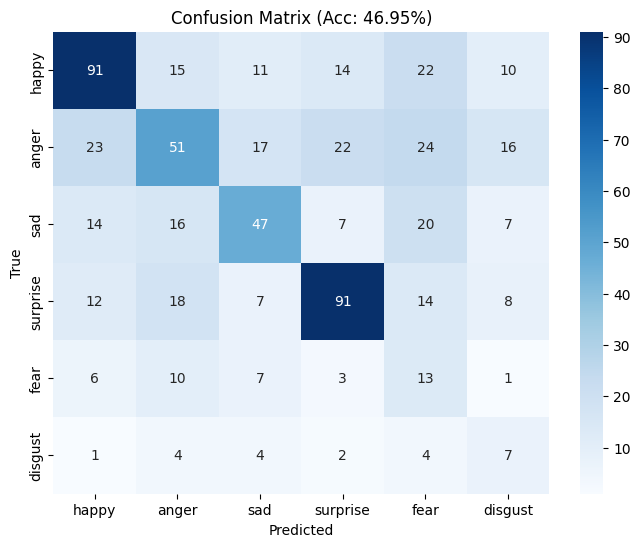


Classification Report:
              precision    recall  f1-score   support

       happy       0.62      0.56      0.59       163
       anger       0.45      0.33      0.38       153
         sad       0.51      0.42      0.46       111
    surprise       0.65      0.61      0.63       150
        fear       0.13      0.33      0.19        40
     disgust       0.14      0.32      0.20        22

    accuracy                           0.47       639
   macro avg       0.42      0.43      0.41       639
weighted avg       0.52      0.47      0.49       639

Train Loss: 0.5191, Accuracy: 0.8400
Val Loss: 1.7095, Accuracy: 0.4695

Epoch 8/10


100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


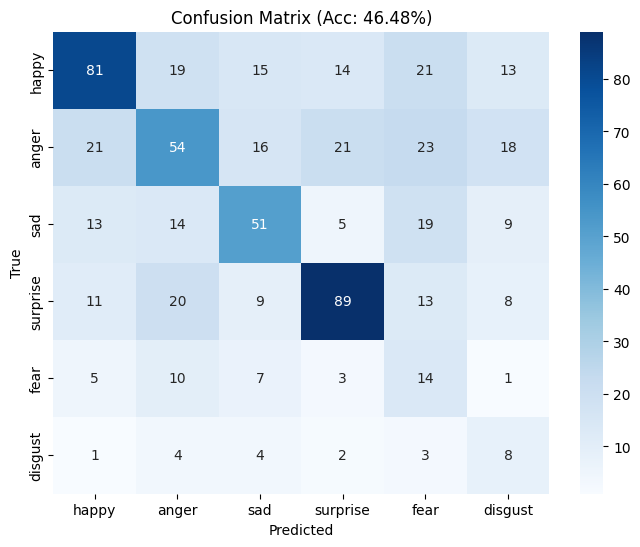


Classification Report:
              precision    recall  f1-score   support

       happy       0.61      0.50      0.55       163
       anger       0.45      0.35      0.39       153
         sad       0.50      0.46      0.48       111
    surprise       0.66      0.59      0.63       150
        fear       0.15      0.35      0.21        40
     disgust       0.14      0.36      0.20        22

    accuracy                           0.46       639
   macro avg       0.42      0.44      0.41       639
weighted avg       0.52      0.46      0.48       639

Train Loss: 0.4422, Accuracy: 0.8715
Val Loss: 1.7709, Accuracy: 0.4648

Epoch 9/10


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


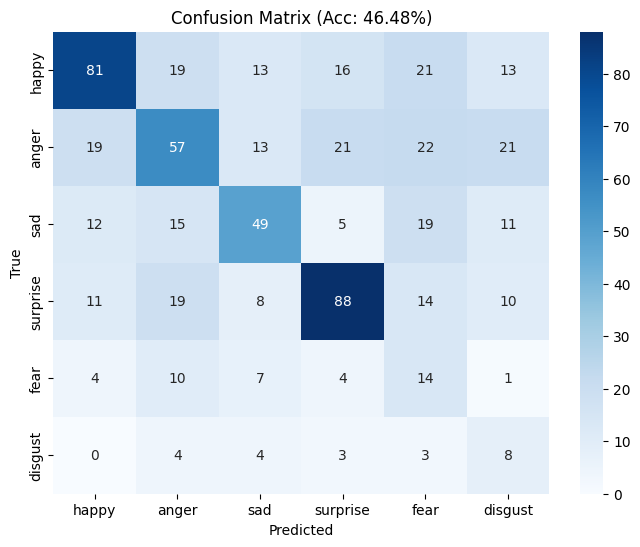


Classification Report:
              precision    recall  f1-score   support

       happy       0.64      0.50      0.56       163
       anger       0.46      0.37      0.41       153
         sad       0.52      0.44      0.48       111
    surprise       0.64      0.59      0.61       150
        fear       0.15      0.35      0.21        40
     disgust       0.12      0.36      0.19        22

    accuracy                           0.46       639
   macro avg       0.42      0.44      0.41       639
weighted avg       0.53      0.46      0.49       639

Train Loss: 0.3847, Accuracy: 0.8971
Val Loss: 1.8036, Accuracy: 0.4648

Epoch 10/10


100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


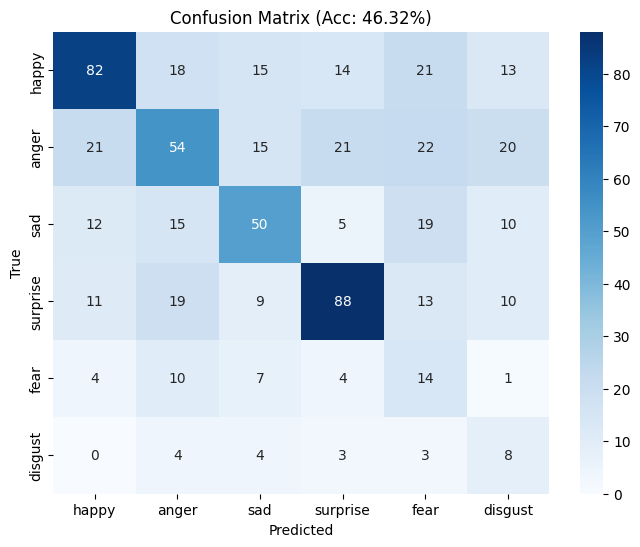


Classification Report:
              precision    recall  f1-score   support

       happy       0.63      0.50      0.56       163
       anger       0.45      0.35      0.40       153
         sad       0.50      0.45      0.47       111
    surprise       0.65      0.59      0.62       150
        fear       0.15      0.35      0.21        40
     disgust       0.13      0.36      0.19        22

    accuracy                           0.46       639
   macro avg       0.42      0.43      0.41       639
weighted avg       0.52      0.46      0.48       639

Train Loss: 0.3813, Accuracy: 0.8957
Val Loss: 1.7969, Accuracy: 0.4632


In [126]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 4
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_full_model.pt")
    print("Model saved.")
  # else:
  #   patience_counter += 1
  #   print(f"No improvement. Patience: {patience_counter}/{patience}")
  #   if patience_counter >= patience:
  #     print("Early stopping.")
  #     break

##### Results analysis:

In [128]:
model.load_state_dict(torch.load("best_full_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs['logits'], dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.518


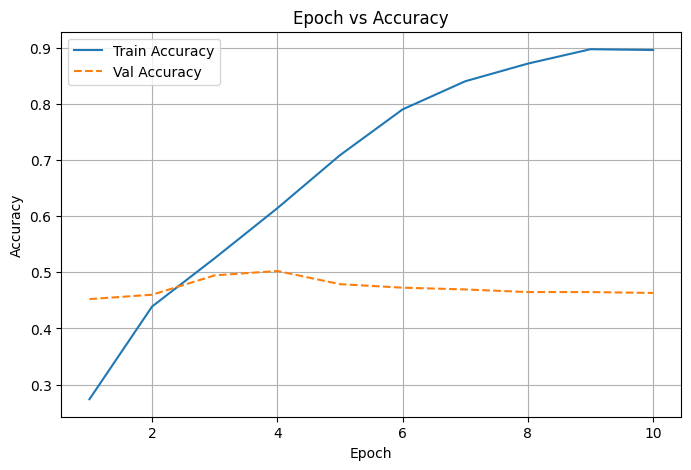

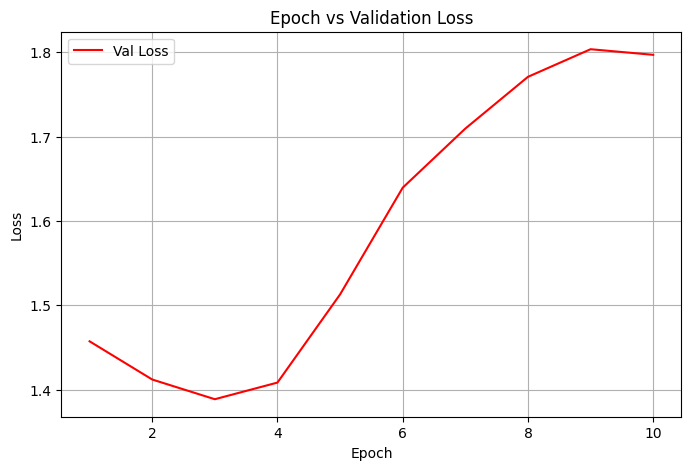

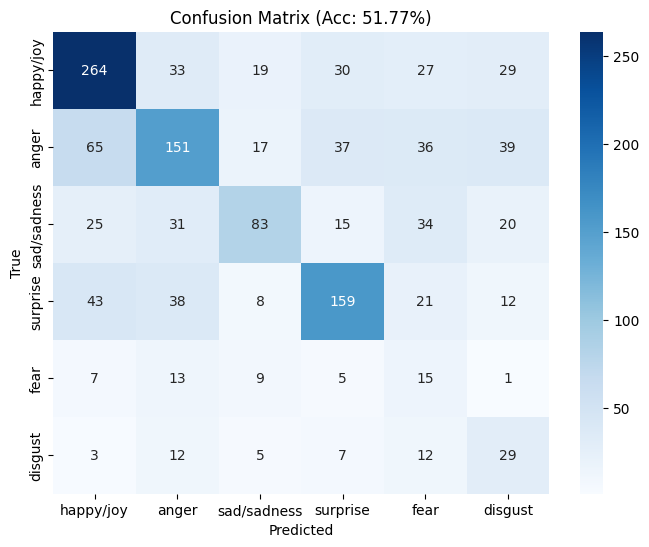

In [129]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

class_names = ["happy/joy", "anger", "sad/sadness", "surprise", "fear", "disgust"]
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [130]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   happy/joy       0.65      0.66      0.65       402
       anger       0.54      0.44      0.48       345
 sad/sadness       0.59      0.40      0.48       208
    surprise       0.63      0.57      0.60       281
        fear       0.10      0.30      0.15        50
     disgust       0.22      0.43      0.29        68

    accuracy                           0.52      1354
   macro avg       0.46      0.46      0.44      1354
weighted avg       0.57      0.52      0.53      1354



In [ ]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     3          3
1     1          2
2     0          1
3     0          1
4     0          0

### Go-emotions normalized:

In [ ]:
!pip install -U datasets fsspec --quiet

In [ ]:
# rm -r ~/.cache/huggingface/datasets/go_emotions

rm: cannot remove '/root/.cache/huggingface/datasets/go_emotions': No such file or directory


In [ ]:
from datasets import load_dataset

dataset = load_dataset("go_emotions", name="raw", cache_dir="./hf_cache")

emotion_labels = [
  'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
  'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
  'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
  'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
  'remorse', 'sadness', 'surprise', 'neutral'
]

def convert_row(row):
  return {
    "text": row["text"],
    "labels": [emotion for emotion in emotion_labels if row[emotion] == 1]
  }

converted_dataset = dataset["train"].map(convert_row)
converted_dataset[0]

Map:   0%|          | 0/211225 [00:00<?, ? examples/s]

{'text': 'That game hurt.',
 'id': 'eew5j0j',
 'author': 'Brdd9',
 'subreddit': 'nrl',
 'link_id': 't3_ajis4z',
 'parent_id': 't1_eew18eq',
 'created_utc': 1548381056.0,
 'rater_id': 1,
 'example_very_unclear': False,
 'admiration': 0,
 'amusement': 0,
 'anger': 0,
 'annoyance': 0,
 'approval': 0,
 'caring': 0,
 'confusion': 0,
 'curiosity': 0,
 'desire': 0,
 'disappointment': 0,
 'disapproval': 0,
 'disgust': 0,
 'embarrassment': 0,
 'excitement': 0,
 'fear': 0,
 'gratitude': 0,
 'grief': 0,
 'joy': 0,
 'love': 0,
 'nervousness': 0,
 'optimism': 0,
 'pride': 0,
 'realization': 0,
 'relief': 0,
 'remorse': 0,
 'sadness': 1,
 'surprise': 0,
 'neutral': 0,
 'labels': ['sadness']}

In [44]:
target_classes = ['neutral', 'joy', 'anger', 'sadness', 'surprise', 'fear', 'disgust']

df = pd.DataFrame(dataset['train'])

def get_active_labels(row):
  return [label for label in emotion_labels if row[label] == 1]

df['labels'] = df.apply(get_active_labels, axis=1)
filtered_df = df[df['labels'].apply(lambda x: len(x) == 1 and x[0] in target_classes)].copy()

filtered_df['emotion'] = filtered_df['labels'].apply(lambda x: x[0])
filtered_df = filtered_df[['text', 'emotion']].rename(columns={"text": "utterance"})

print(filtered_df['emotion'].value_counts())
filtered_df.head()

emotion
neutral     55298
anger        5202
joy          4329
sadness      3827
surprise     3472
disgust      2914
fear         1778
Name: count, dtype: int64


utterance  emotion
0                                     That game hurt.  sadness
2      You do right, if you don't care then fuck 'em!  neutral
4   [NAME] was nowhere near them, he was by the Fa...  neutral
10  I have, and now that you mention it, I think t...  neutral
12                              BUT IT'S HER TURN! /s  neutral

In [45]:
neutral_df = filtered_df[filtered_df['emotion'] == 'neutral']
other_df = filtered_df[filtered_df['emotion'] != 'neutral']

neutral_downsampled = neutral_df.sample(n=8000, random_state=42)
balanced_df = pd.concat([neutral_downsampled, other_df], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['emotion'].value_counts()

emotion
neutral     8000
anger       5202
joy         4329
sadness     3827
surprise    3472
disgust     2914
fear        1778
Name: count, dtype: int64

In [48]:
emotion_to_label = {
  "neutral": 0,
  "happy": 1,
  "joy": 1,
  "anger": 2,
  "sad": 3,
  "sadness": 3,
  "surprise": 4,
  "fear": 5,
  "disgust": 6
}

balanced_df['emotion_label'] = balanced_df['emotion'].map(emotion_to_label)
# filtered_df = filtered_df.dropna(subset=['emotion_label'])
balanced_df['emotion_label'] = balanced_df['emotion_label'].astype(int)

balanced_df = balanced_df.drop(columns=['emotion'])

print(balanced_df.dtypes)
balanced_df.head()

utterance        object
emotion_label     int64
dtype: object


utterance  emotion_label
0                 > Corporate Media I like this one.              1
1  So that means the Vikings are the Purple Cobra...              0
2      Lets spare him his life from this monstrosity              0
3                                            #ERROR!              0
4                  Well that was strangely majestic.              4

In [50]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
  balanced_df, test_size=0.2, stratify=balanced_df['emotion_label'], random_state=42
)

val_df, test_df = train_test_split(
  temp_df, test_size=0.5, stratify=temp_df['emotion_label'], random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 23617
Validation size: 2952
Test size: 2953


In [51]:
print(train_df['emotion_label'].value_counts())
print(val_df['emotion_label'].value_counts())
print(test_df['emotion_label'].value_counts())

emotion_label
0    6400
2    4161
1    3463
3    3062
4    2778
6    2331
5    1422
Name: count, dtype: int64
emotion_label
0    800
2    520
1    433
3    382
4    347
6    292
5    178
Name: count, dtype: int64
emotion_label
0    800
2    521
1    433
3    383
4    347
6    291
5    178
Name: count, dtype: int64


#### Full model training:

In [52]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

###### Whole data:

In [53]:
train_labels = list(map(int, train_df["emotion_label"]))
val_labels = list(map(int, val_df["emotion_label"]))
test_labels = list(map(int, test_df["emotion_label"]))

In [54]:
set(filtered_df["emotion_label"])

{0, 1, 2, 3, 4, 5, 6}

In [55]:
train_df["emotion_label"].value_counts()

emotion_label
0    6400
2    4161
1    3463
3    3062
4    2778
6    2331
5    1422
Name: count, dtype: int64

In [56]:
max_len_chars = train_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 542


In [57]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [58]:
train_dataset = TextDataset(train_df["utterance"].tolist(), train_df["emotion_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_df["utterance"].tolist(), val_df["emotion_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["utterance"].tolist(), test_df["emotion_label"].tolist(), tokenizer)

In [59]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [60]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
  class_weight="balanced",
  classes=np.unique(train_labels),
  y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [61]:
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

In [62]:
from transformers import AutoModel, AutoConfig

class CustomClassifier(nn.Module):
  def __init__(self, model_name, num_labels, dropout_prob=0.3):
    super().__init__()
    self.base = AutoModel.from_pretrained(model_name)
    self.base.gradient_checkpointing_enable()
    hidden_size = self.base.config.hidden_size
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

  def forward(self, input_ids, attention_mask, labels=None):
    outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return {'logits': logits}

In [63]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7, ignore_mismatched_sizes=True)
model = CustomClassifier(MODEL_NAME, num_labels=7).to(device)
# config = AutoConfig.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, num_labels=7, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

In [64]:
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
  "cosine",
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_training_steps
)

In [65]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs["logits"]
    loss = loss_fn(logits, batch["labels"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      # logits = outputs.logits
      logits = outputs['logits']
      loss = loss_fn(logits, batch["labels"])

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  class_names = ["neutral", "happy", "anger", "sad", "surprise", "fear", "disgust"]
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix (Acc: {correct / total*100:.2f}%)")
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  return total_loss / len(dataloader), correct / total

In [66]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 93/93 [00:09<00:00,  9.73it/s]


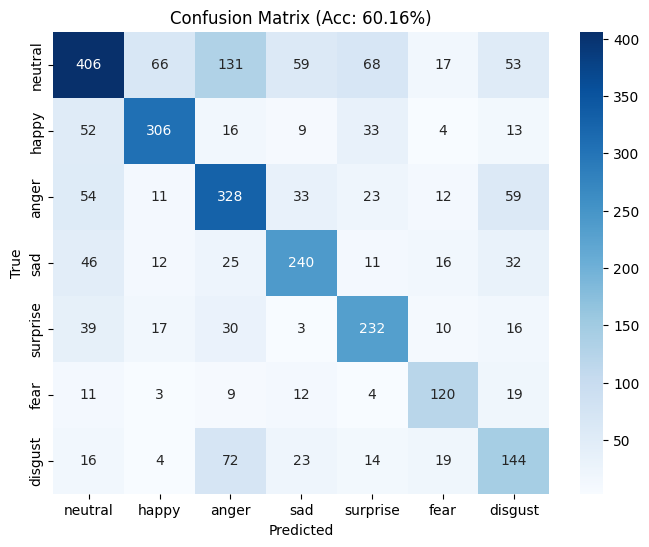


Classification Report:
              precision    recall  f1-score   support

     neutral       0.65      0.51      0.57       800
       happy       0.73      0.71      0.72       433
       anger       0.54      0.63      0.58       520
         sad       0.63      0.63      0.63       382
    surprise       0.60      0.67      0.63       347
        fear       0.61      0.67      0.64       178
     disgust       0.43      0.49      0.46       292

    accuracy                           0.60      2952
   macro avg       0.60      0.62      0.60      2952
weighted avg       0.61      0.60      0.60      2952

Train Loss: 1.3904, Accuracy: 0.4769
Val Loss: 1.1269, Accuracy: 0.6016
Model saved.

Epoch 2/10


100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


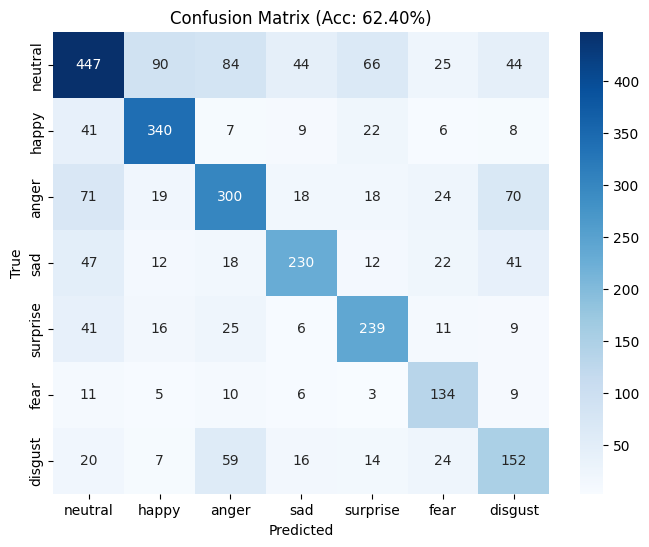


Classification Report:
              precision    recall  f1-score   support

     neutral       0.66      0.56      0.60       800
       happy       0.70      0.79      0.74       433
       anger       0.60      0.58      0.59       520
         sad       0.70      0.60      0.65       382
    surprise       0.64      0.69      0.66       347
        fear       0.54      0.75      0.63       178
     disgust       0.46      0.52      0.49       292

    accuracy                           0.62      2952
   macro avg       0.61      0.64      0.62      2952
weighted avg       0.63      0.62      0.62      2952

Train Loss: 1.0313, Accuracy: 0.6267
Val Loss: 1.0633, Accuracy: 0.6240
Model saved.

Epoch 3/10


100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


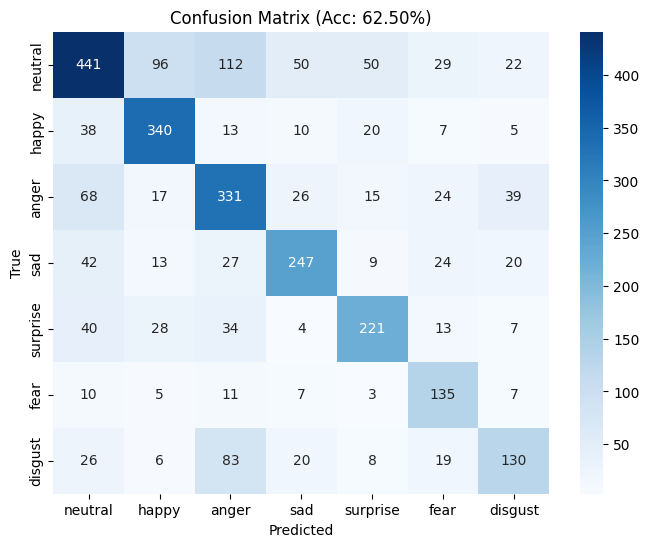


Classification Report:
              precision    recall  f1-score   support

     neutral       0.66      0.55      0.60       800
       happy       0.67      0.79      0.72       433
       anger       0.54      0.64      0.59       520
         sad       0.68      0.65      0.66       382
    surprise       0.68      0.64      0.66       347
        fear       0.54      0.76      0.63       178
     disgust       0.57      0.45      0.50       292

    accuracy                           0.62      2952
   macro avg       0.62      0.64      0.62      2952
weighted avg       0.63      0.62      0.62      2952

Train Loss: 0.8780, Accuracy: 0.6746
Val Loss: 1.0963, Accuracy: 0.6250

Epoch 4/10


100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


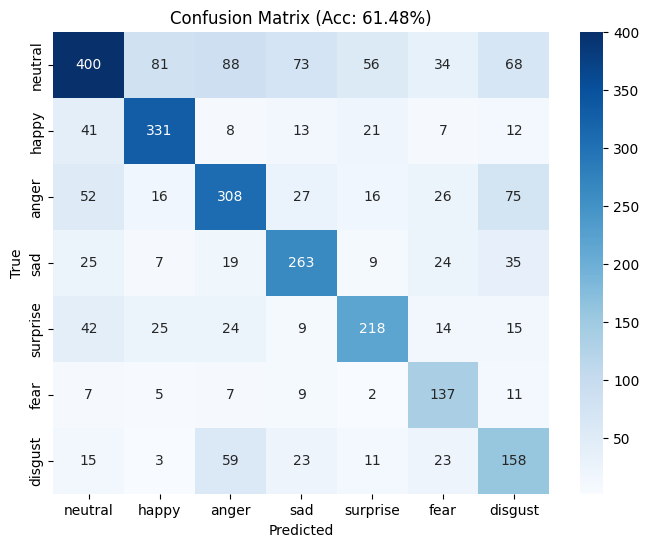


Classification Report:
              precision    recall  f1-score   support

     neutral       0.69      0.50      0.58       800
       happy       0.71      0.76      0.73       433
       anger       0.60      0.59      0.60       520
         sad       0.63      0.69      0.66       382
    surprise       0.65      0.63      0.64       347
        fear       0.52      0.77      0.62       178
     disgust       0.42      0.54      0.47       292

    accuracy                           0.61      2952
   macro avg       0.60      0.64      0.61      2952
weighted avg       0.63      0.61      0.61      2952

Train Loss: 0.7433, Accuracy: 0.7197
Val Loss: 1.1281, Accuracy: 0.6148

Epoch 5/10


100%|██████████| 93/93 [00:09<00:00,  9.71it/s]


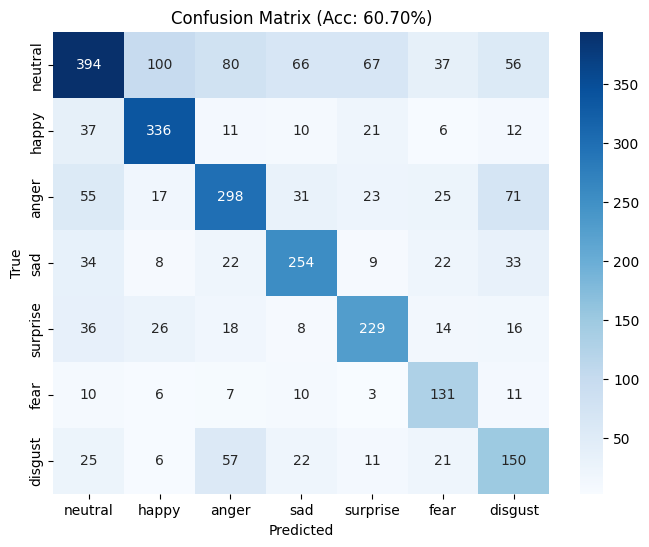


Classification Report:
              precision    recall  f1-score   support

     neutral       0.67      0.49      0.57       800
       happy       0.67      0.78      0.72       433
       anger       0.60      0.57      0.59       520
         sad       0.63      0.66      0.65       382
    surprise       0.63      0.66      0.65       347
        fear       0.51      0.74      0.60       178
     disgust       0.43      0.51      0.47       292

    accuracy                           0.61      2952
   macro avg       0.59      0.63      0.61      2952
weighted avg       0.62      0.61      0.61      2952

Train Loss: 0.6181, Accuracy: 0.7615
Val Loss: 1.2219, Accuracy: 0.6070

Epoch 6/10


100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


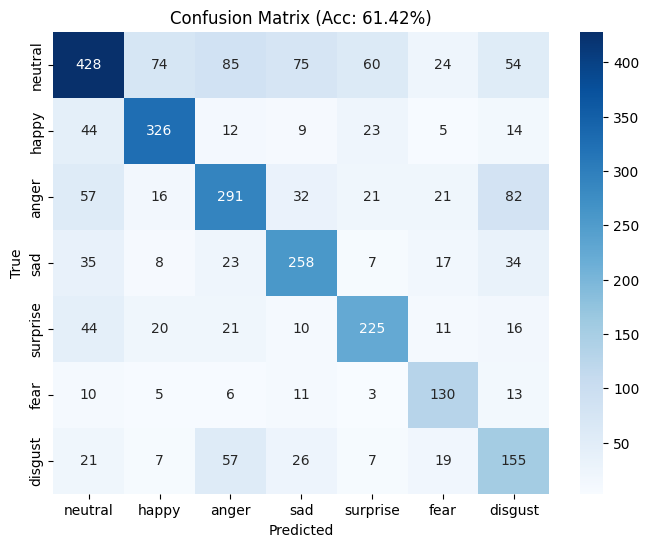


Classification Report:
              precision    recall  f1-score   support

     neutral       0.67      0.54      0.59       800
       happy       0.71      0.75      0.73       433
       anger       0.59      0.56      0.57       520
         sad       0.61      0.68      0.64       382
    surprise       0.65      0.65      0.65       347
        fear       0.57      0.73      0.64       178
     disgust       0.42      0.53      0.47       292

    accuracy                           0.61      2952
   macro avg       0.60      0.63      0.62      2952
weighted avg       0.62      0.61      0.61      2952

Train Loss: 0.5193, Accuracy: 0.8000
Val Loss: 1.3064, Accuracy: 0.6142

Epoch 7/10


100%|██████████| 93/93 [00:09<00:00,  9.65it/s]


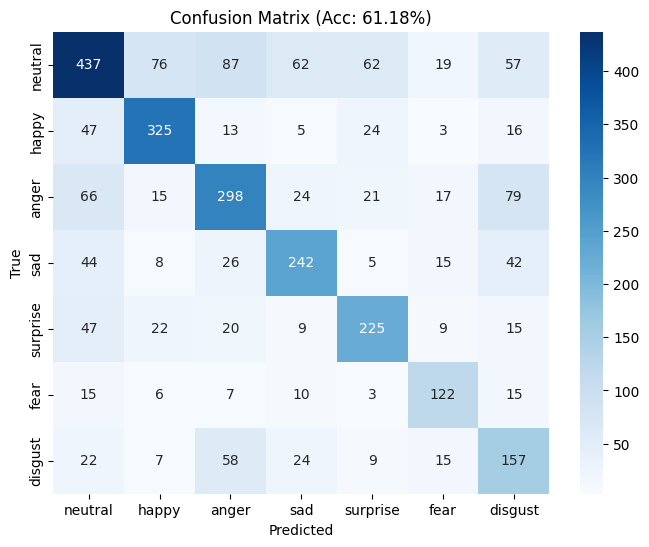


Classification Report:
              precision    recall  f1-score   support

     neutral       0.64      0.55      0.59       800
       happy       0.71      0.75      0.73       433
       anger       0.59      0.57      0.58       520
         sad       0.64      0.63      0.64       382
    surprise       0.64      0.65      0.65       347
        fear       0.61      0.69      0.65       178
     disgust       0.41      0.54      0.47       292

    accuracy                           0.61      2952
   macro avg       0.61      0.62      0.61      2952
weighted avg       0.62      0.61      0.61      2952

Train Loss: 0.4496, Accuracy: 0.8229
Val Loss: 1.3899, Accuracy: 0.6118

Epoch 8/10


100%|██████████| 93/93 [00:09<00:00,  9.70it/s]


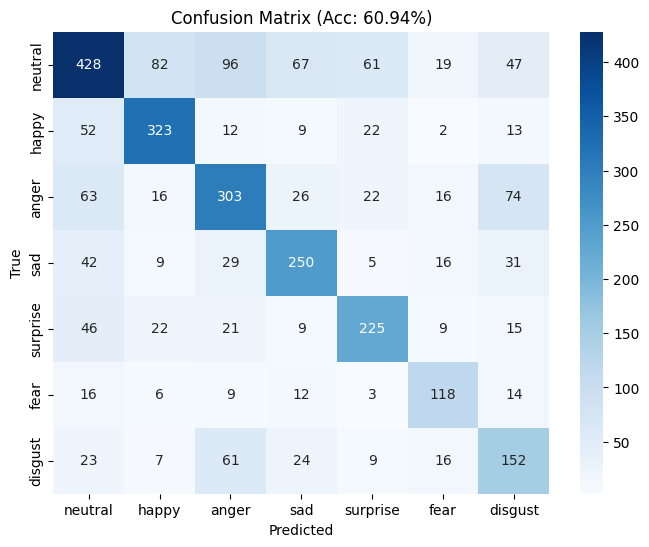


Classification Report:
              precision    recall  f1-score   support

     neutral       0.64      0.54      0.58       800
       happy       0.69      0.75      0.72       433
       anger       0.57      0.58      0.58       520
         sad       0.63      0.65      0.64       382
    surprise       0.65      0.65      0.65       347
        fear       0.60      0.66      0.63       178
     disgust       0.44      0.52      0.48       292

    accuracy                           0.61      2952
   macro avg       0.60      0.62      0.61      2952
weighted avg       0.61      0.61      0.61      2952

Train Loss: 0.3944, Accuracy: 0.8416
Val Loss: 1.4742, Accuracy: 0.6094

Epoch 9/10


100%|██████████| 93/93 [00:09<00:00,  9.63it/s]


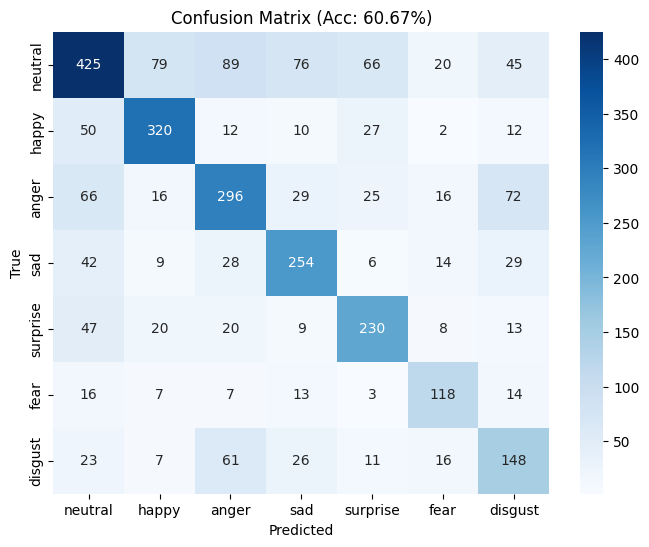


Classification Report:
              precision    recall  f1-score   support

     neutral       0.64      0.53      0.58       800
       happy       0.70      0.74      0.72       433
       anger       0.58      0.57      0.57       520
         sad       0.61      0.66      0.64       382
    surprise       0.62      0.66      0.64       347
        fear       0.61      0.66      0.63       178
     disgust       0.44      0.51      0.47       292

    accuracy                           0.61      2952
   macro avg       0.60      0.62      0.61      2952
weighted avg       0.61      0.61      0.61      2952

Train Loss: 0.3689, Accuracy: 0.8522
Val Loss: 1.4979, Accuracy: 0.6067

Epoch 10/10


100%|██████████| 93/93 [00:09<00:00,  9.67it/s]


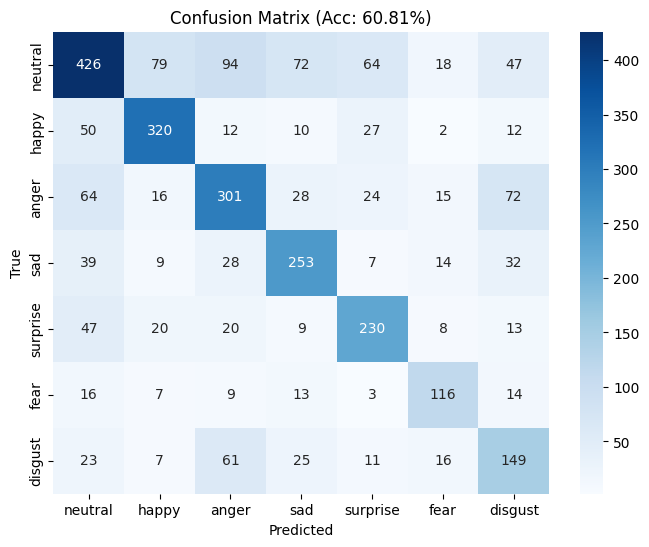


Classification Report:
              precision    recall  f1-score   support

     neutral       0.64      0.53      0.58       800
       happy       0.70      0.74      0.72       433
       anger       0.57      0.58      0.58       520
         sad       0.62      0.66      0.64       382
    surprise       0.63      0.66      0.65       347
        fear       0.61      0.65      0.63       178
     disgust       0.44      0.51      0.47       292

    accuracy                           0.61      2952
   macro avg       0.60      0.62      0.61      2952
weighted avg       0.61      0.61      0.61      2952

Train Loss: 0.3515, Accuracy: 0.8592
Val Loss: 1.5078, Accuracy: 0.6081
Model saved.


In [67]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 4
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_full_go_emotions_model.pt")
    print("Model saved.")
  # else:
  #   patience_counter += 1
  #   print(f"No improvement. Patience: {patience_counter}/{patience}")
  #   if patience_counter >= patience:
  #     print("Early stopping.")
  #     break

torch.save(model.state_dict(), "best_full_go_emotions_model_last.pt")
print("Model saved.")

##### Results analysis:

In [68]:
model.load_state_dict(torch.load("best_full_go_emotions_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs['logits'], dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.641


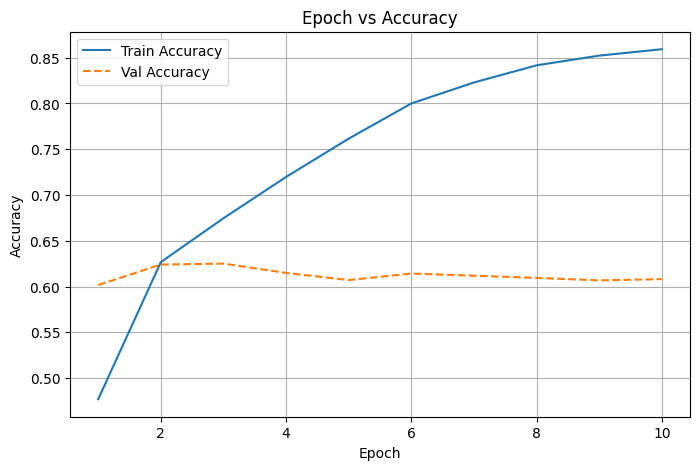

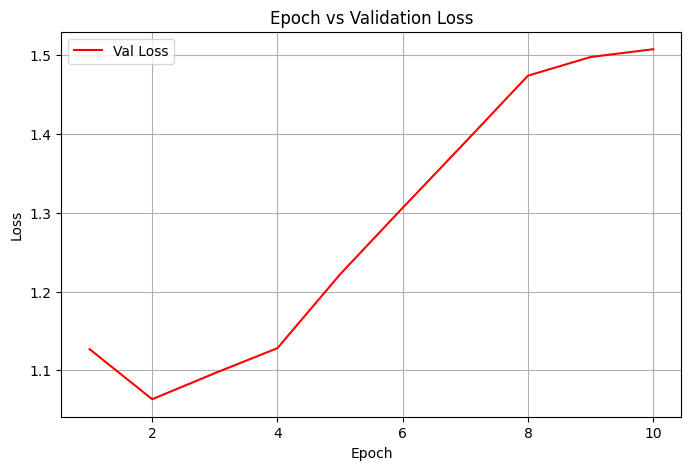

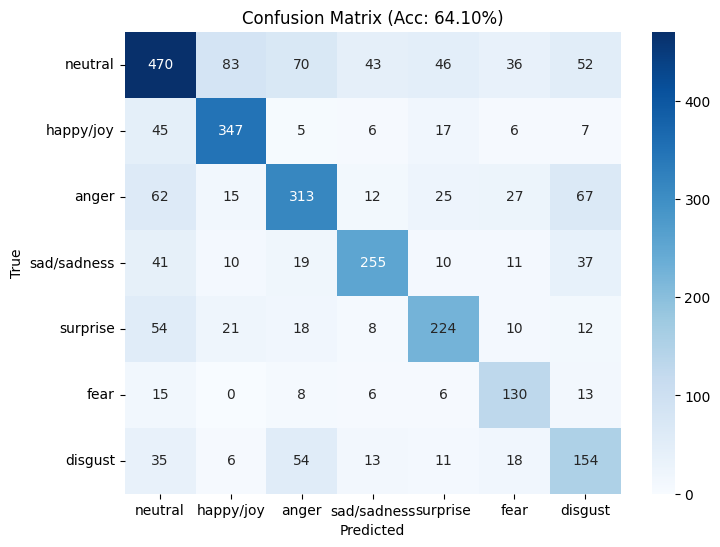

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

class_names = ["neutral", "happy/joy", "anger", "sad/sadness", "surprise", "fear", "disgust"]
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [70]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     neutral       0.65      0.59      0.62       800
   happy/joy       0.72      0.80      0.76       433
       anger       0.64      0.60      0.62       521
 sad/sadness       0.74      0.67      0.70       383
    surprise       0.66      0.65      0.65       347
        fear       0.55      0.73      0.62       178
     disgust       0.45      0.53      0.49       291

    accuracy                           0.64      2953
   macro avg       0.63      0.65      0.64      2953
weighted avg       0.65      0.64      0.64      2953



In [71]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     5          5
1     5          5
2     6          0
3     3          3
4     6          6

### Go-emotions normalized 2:

In [ ]:
!pip install -U datasets fsspec --quiet

In [ ]:
# rm -r ~/.cache/huggingface/datasets/go_emotions

rm: cannot remove '/root/.cache/huggingface/datasets/go_emotions': No such file or directory


In [ ]:
from datasets import load_dataset

dataset = load_dataset("go_emotions", name="raw", cache_dir="./hf_cache")

emotion_labels = [
  'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
  'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
  'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
  'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
  'remorse', 'sadness', 'surprise', 'neutral'
]

def convert_row(row):
  return {
    "text": row["text"],
    "labels": [emotion for emotion in emotion_labels if row[emotion] == 1]
  }

converted_dataset = dataset["train"].map(convert_row)
converted_dataset[0]

Map:   0%|          | 0/211225 [00:00<?, ? examples/s]

{'text': 'That game hurt.',
 'id': 'eew5j0j',
 'author': 'Brdd9',
 'subreddit': 'nrl',
 'link_id': 't3_ajis4z',
 'parent_id': 't1_eew18eq',
 'created_utc': 1548381056.0,
 'rater_id': 1,
 'example_very_unclear': False,
 'admiration': 0,
 'amusement': 0,
 'anger': 0,
 'annoyance': 0,
 'approval': 0,
 'caring': 0,
 'confusion': 0,
 'curiosity': 0,
 'desire': 0,
 'disappointment': 0,
 'disapproval': 0,
 'disgust': 0,
 'embarrassment': 0,
 'excitement': 0,
 'fear': 0,
 'gratitude': 0,
 'grief': 0,
 'joy': 0,
 'love': 0,
 'nervousness': 0,
 'optimism': 0,
 'pride': 0,
 'realization': 0,
 'relief': 0,
 'remorse': 0,
 'sadness': 1,
 'surprise': 0,
 'neutral': 0,
 'labels': ['sadness']}

In [72]:
target_classes = ['neutral', 'joy', 'anger', 'sadness', 'surprise', 'fear', 'disgust']

df = pd.DataFrame(dataset['train'])

def get_active_labels(row):
  return [label for label in emotion_labels if row[label] == 1]

df['labels'] = df.apply(get_active_labels, axis=1)
filtered_df = df[df['labels'].apply(lambda x: len(x) == 1 and x[0] in target_classes)].copy()

filtered_df['emotion'] = filtered_df['labels'].apply(lambda x: x[0])
filtered_df = filtered_df[['text', 'emotion']].rename(columns={"text": "utterance"})

print(filtered_df['emotion'].value_counts())
filtered_df.head()

emotion
neutral     55298
anger        5202
joy          4329
sadness      3827
surprise     3472
disgust      2914
fear         1778
Name: count, dtype: int64


utterance  emotion
0                                     That game hurt.  sadness
2      You do right, if you don't care then fuck 'em!  neutral
4   [NAME] was nowhere near them, he was by the Fa...  neutral
10  I have, and now that you mention it, I think t...  neutral
12                              BUT IT'S HER TURN! /s  neutral

In [73]:
neutral_df = filtered_df[filtered_df['emotion'] == 'neutral']
other_df = filtered_df[filtered_df['emotion'] != 'neutral']

neutral_downsampled = neutral_df.sample(n=5500, random_state=42)
balanced_df = pd.concat([neutral_downsampled, other_df], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['emotion'].value_counts()

emotion
neutral     5500
anger       5202
joy         4329
sadness     3827
surprise    3472
disgust     2914
fear        1778
Name: count, dtype: int64

In [74]:
emotion_to_label = {
  "neutral": 0,
  "happy": 1,
  "joy": 1,
  "anger": 2,
  "sad": 3,
  "sadness": 3,
  "surprise": 4,
  "fear": 5,
  "disgust": 6
}

balanced_df['emotion_label'] = balanced_df['emotion'].map(emotion_to_label)
# filtered_df = filtered_df.dropna(subset=['emotion_label'])
balanced_df['emotion_label'] = balanced_df['emotion_label'].astype(int)

balanced_df = balanced_df.drop(columns=['emotion'])

print(balanced_df.dtypes)
balanced_df.head()

utterance        object
emotion_label     int64
dtype: object


utterance  emotion_label
0                                           Woo hoo!              4
1   The fact that you think like this is terrifying.              5
2                        Gawd but [NAME] is a bitch.              2
3  I'm 35 was married for 10 years and now I'm no...              1
4  Break ups are painful and there’s no way to av...              3

In [75]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
  balanced_df, test_size=0.2, stratify=balanced_df['emotion_label'], random_state=42
)

val_df, test_df = train_test_split(
  temp_df, test_size=0.5, stratify=temp_df['emotion_label'], random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 21617
Validation size: 2702
Test size: 2703


In [76]:
print(train_df['emotion_label'].value_counts())
print(val_df['emotion_label'].value_counts())
print(test_df['emotion_label'].value_counts())

emotion_label
0    4400
2    4161
1    3463
3    3062
4    2778
6    2331
5    1422
Name: count, dtype: int64
emotion_label
0    550
2    520
1    433
3    382
4    347
6    292
5    178
Name: count, dtype: int64
emotion_label
0    550
2    521
1    433
3    383
4    347
6    291
5    178
Name: count, dtype: int64


#### Full model training:

In [77]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

###### Whole data:

In [78]:
train_labels = list(map(int, train_df["emotion_label"]))
val_labels = list(map(int, val_df["emotion_label"]))
test_labels = list(map(int, test_df["emotion_label"]))

In [81]:
set(balanced_df["emotion_label"])

{0, 1, 2, 3, 4, 5, 6}

In [82]:
train_df["emotion_label"].value_counts()

emotion_label
0    4400
2    4161
1    3463
3    3062
4    2778
6    2331
5    1422
Name: count, dtype: int64

In [83]:
max_len_chars = train_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 232


In [84]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [85]:
train_dataset = TextDataset(train_df["utterance"].tolist(), train_df["emotion_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_df["utterance"].tolist(), val_df["emotion_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["utterance"].tolist(), test_df["emotion_label"].tolist(), tokenizer)

In [86]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [87]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
  class_weight="balanced",
  classes=np.unique(train_labels),
  y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [88]:
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

In [89]:
from transformers import AutoModel, AutoConfig

class CustomClassifier(nn.Module):
  def __init__(self, model_name, num_labels, dropout_prob=0.3):
    super().__init__()
    self.base = AutoModel.from_pretrained(model_name)
    self.base.gradient_checkpointing_enable()
    hidden_size = self.base.config.hidden_size
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

  def forward(self, input_ids, attention_mask, labels=None):
    outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return {'logits': logits}

In [90]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7, ignore_mismatched_sizes=True)
model = CustomClassifier(MODEL_NAME, num_labels=7).to(device)
# config = AutoConfig.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, num_labels=7, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

In [91]:
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
  "cosine",
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_training_steps
)

In [92]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs["logits"]
    loss = loss_fn(logits, batch["labels"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      # logits = outputs.logits
      logits = outputs['logits']
      loss = loss_fn(logits, batch["labels"])

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  class_names = ["neutral", "happy", "anger", "sad", "surprise", "fear", "disgust"]
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix (Acc: {correct / total*100:.2f}%)")
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  return total_loss / len(dataloader), correct / total

In [93]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 85/85 [00:08<00:00,  9.68it/s]


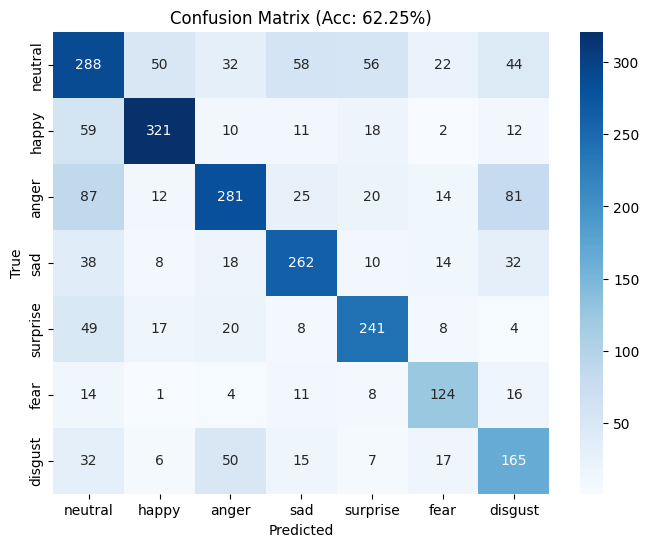


Classification Report:
              precision    recall  f1-score   support

     neutral       0.51      0.52      0.52       550
       happy       0.77      0.74      0.76       433
       anger       0.68      0.54      0.60       520
         sad       0.67      0.69      0.68       382
    surprise       0.67      0.69      0.68       347
        fear       0.62      0.70      0.65       178
     disgust       0.47      0.57      0.51       292

    accuracy                           0.62      2702
   macro avg       0.63      0.64      0.63      2702
weighted avg       0.63      0.62      0.62      2702

Train Loss: 1.4188, Accuracy: 0.4726
Val Loss: 1.0626, Accuracy: 0.6225
Model saved.

Epoch 2/10


100%|██████████| 85/85 [00:08<00:00,  9.70it/s]


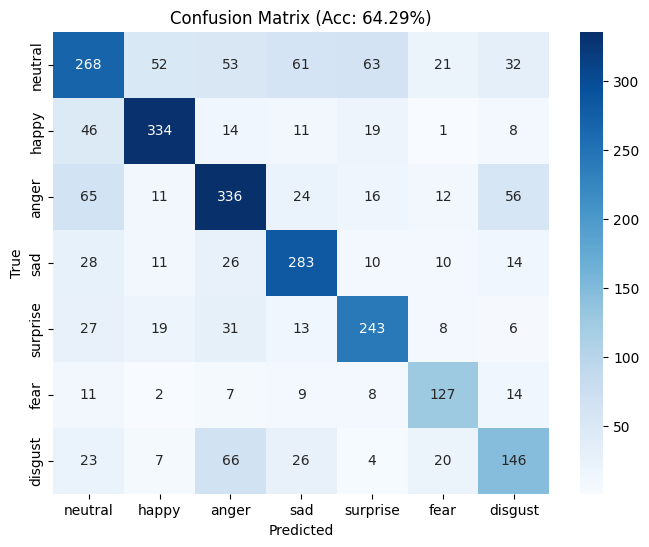


Classification Report:
              precision    recall  f1-score   support

     neutral       0.57      0.49      0.53       550
       happy       0.77      0.77      0.77       433
       anger       0.63      0.65      0.64       520
         sad       0.66      0.74      0.70       382
    surprise       0.67      0.70      0.68       347
        fear       0.64      0.71      0.67       178
     disgust       0.53      0.50      0.51       292

    accuracy                           0.64      2702
   macro avg       0.64      0.65      0.64      2702
weighted avg       0.64      0.64      0.64      2702

Train Loss: 1.0374, Accuracy: 0.6339
Val Loss: 1.0230, Accuracy: 0.6429
Model saved.

Epoch 3/10


100%|██████████| 85/85 [00:08<00:00,  9.70it/s]


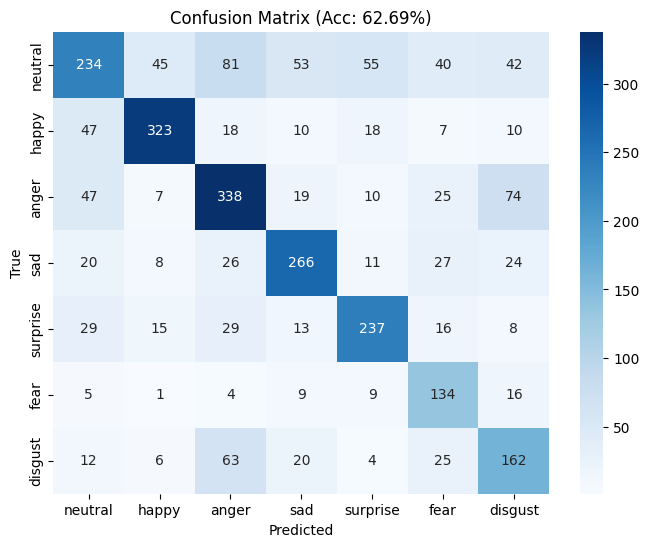


Classification Report:
              precision    recall  f1-score   support

     neutral       0.59      0.43      0.50       550
       happy       0.80      0.75      0.77       433
       anger       0.60      0.65      0.63       520
         sad       0.68      0.70      0.69       382
    surprise       0.69      0.68      0.69       347
        fear       0.49      0.75      0.59       178
     disgust       0.48      0.55      0.52       292

    accuracy                           0.63      2702
   macro avg       0.62      0.64      0.63      2702
weighted avg       0.63      0.63      0.63      2702

Train Loss: 0.8807, Accuracy: 0.6855
Val Loss: 1.0536, Accuracy: 0.6269

Epoch 4/10


100%|██████████| 85/85 [00:08<00:00,  9.69it/s]


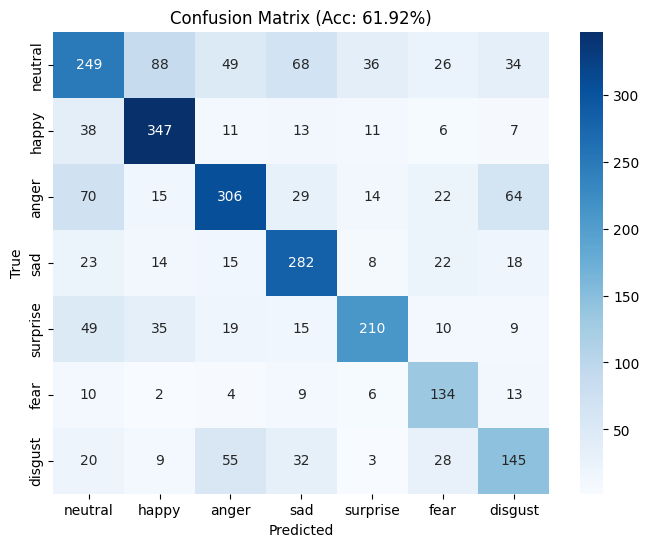


Classification Report:
              precision    recall  f1-score   support

     neutral       0.54      0.45      0.49       550
       happy       0.68      0.80      0.74       433
       anger       0.67      0.59      0.63       520
         sad       0.63      0.74      0.68       382
    surprise       0.73      0.61      0.66       347
        fear       0.54      0.75      0.63       178
     disgust       0.50      0.50      0.50       292

    accuracy                           0.62      2702
   macro avg       0.61      0.63      0.62      2702
weighted avg       0.62      0.62      0.62      2702

Train Loss: 0.7366, Accuracy: 0.7361
Val Loss: 1.1409, Accuracy: 0.6192

Epoch 5/10


100%|██████████| 85/85 [00:08<00:00,  9.68it/s]


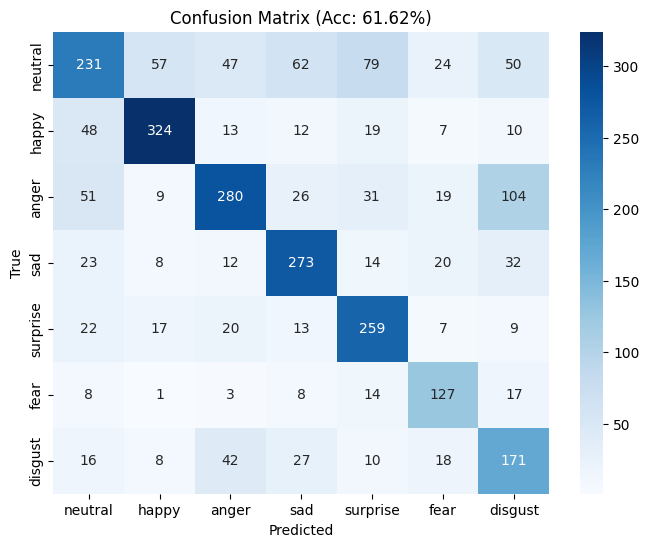


Classification Report:
              precision    recall  f1-score   support

     neutral       0.58      0.42      0.49       550
       happy       0.76      0.75      0.76       433
       anger       0.67      0.54      0.60       520
         sad       0.65      0.71      0.68       382
    surprise       0.61      0.75      0.67       347
        fear       0.57      0.71      0.64       178
     disgust       0.44      0.59      0.50       292

    accuracy                           0.62      2702
   macro avg       0.61      0.64      0.62      2702
weighted avg       0.62      0.62      0.61      2702

Train Loss: 0.6124, Accuracy: 0.7786
Val Loss: 1.2001, Accuracy: 0.6162

Epoch 6/10


100%|██████████| 85/85 [00:08<00:00,  9.68it/s]


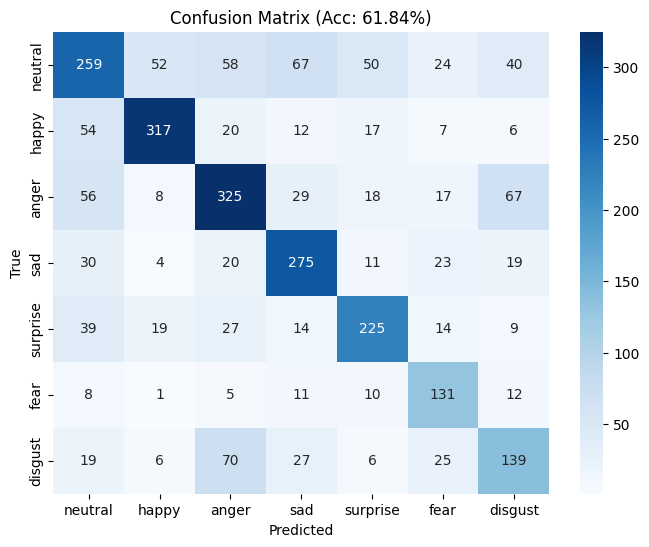


Classification Report:
              precision    recall  f1-score   support

     neutral       0.56      0.47      0.51       550
       happy       0.78      0.73      0.75       433
       anger       0.62      0.62      0.62       520
         sad       0.63      0.72      0.67       382
    surprise       0.67      0.65      0.66       347
        fear       0.54      0.74      0.63       178
     disgust       0.48      0.48      0.48       292

    accuracy                           0.62      2702
   macro avg       0.61      0.63      0.62      2702
weighted avg       0.62      0.62      0.62      2702

Train Loss: 0.5135, Accuracy: 0.8134
Val Loss: 1.3200, Accuracy: 0.6184

Epoch 7/10


100%|██████████| 85/85 [00:08<00:00,  9.70it/s]


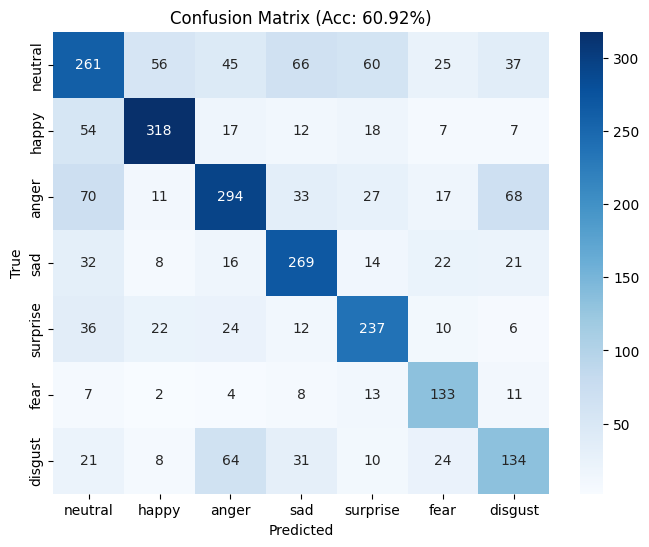


Classification Report:
              precision    recall  f1-score   support

     neutral       0.54      0.47      0.51       550
       happy       0.75      0.73      0.74       433
       anger       0.63      0.57      0.60       520
         sad       0.62      0.70      0.66       382
    surprise       0.63      0.68      0.65       347
        fear       0.56      0.75      0.64       178
     disgust       0.47      0.46      0.47       292

    accuracy                           0.61      2702
   macro avg       0.60      0.62      0.61      2702
weighted avg       0.61      0.61      0.61      2702

Train Loss: 0.4416, Accuracy: 0.8375
Val Loss: 1.3722, Accuracy: 0.6092

Epoch 8/10


100%|██████████| 85/85 [00:08<00:00,  9.74it/s]


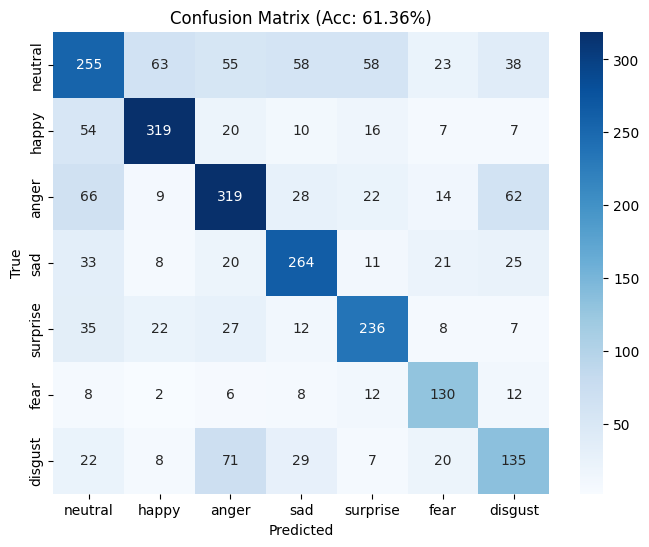


Classification Report:
              precision    recall  f1-score   support

     neutral       0.54      0.46      0.50       550
       happy       0.74      0.74      0.74       433
       anger       0.62      0.61      0.61       520
         sad       0.65      0.69      0.67       382
    surprise       0.65      0.68      0.67       347
        fear       0.58      0.73      0.65       178
     disgust       0.47      0.46      0.47       292

    accuracy                           0.61      2702
   macro avg       0.61      0.63      0.61      2702
weighted avg       0.61      0.61      0.61      2702

Train Loss: 0.3897, Accuracy: 0.8540
Val Loss: 1.4333, Accuracy: 0.6136

Epoch 9/10


100%|██████████| 85/85 [00:08<00:00,  9.69it/s]


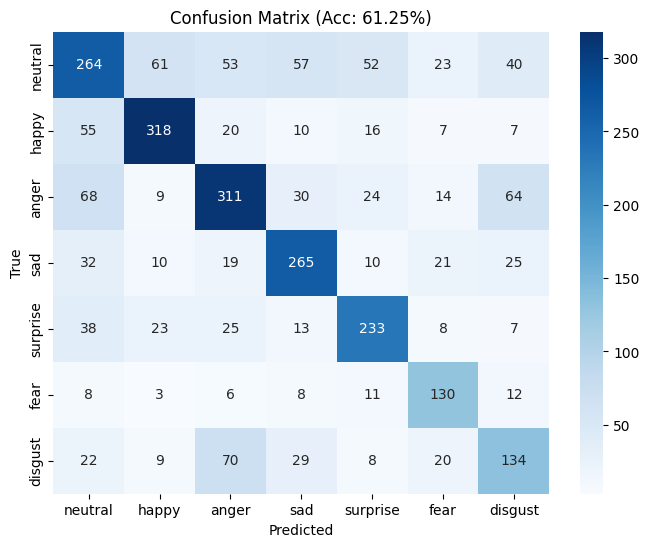


Classification Report:
              precision    recall  f1-score   support

     neutral       0.54      0.48      0.51       550
       happy       0.73      0.73      0.73       433
       anger       0.62      0.60      0.61       520
         sad       0.64      0.69      0.67       382
    surprise       0.66      0.67      0.66       347
        fear       0.58      0.73      0.65       178
     disgust       0.46      0.46      0.46       292

    accuracy                           0.61      2702
   macro avg       0.61      0.62      0.61      2702
weighted avg       0.61      0.61      0.61      2702

Train Loss: 0.3547, Accuracy: 0.8677
Val Loss: 1.4606, Accuracy: 0.6125

Epoch 10/10


100%|██████████| 85/85 [00:08<00:00,  9.71it/s]


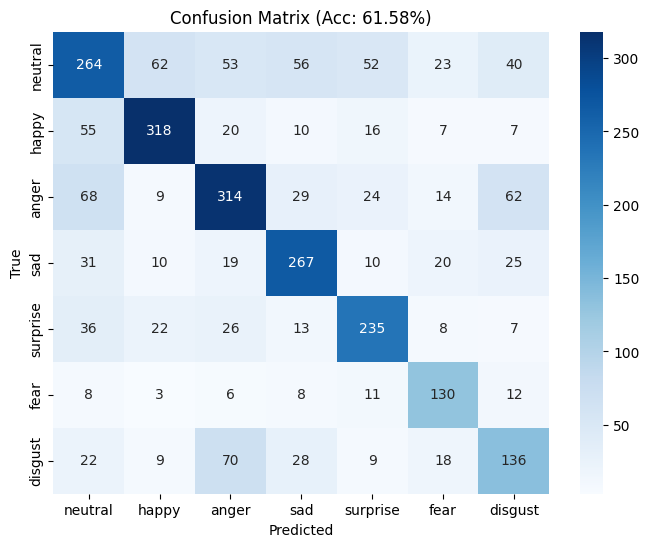


Classification Report:
              precision    recall  f1-score   support

     neutral       0.55      0.48      0.51       550
       happy       0.73      0.73      0.73       433
       anger       0.62      0.60      0.61       520
         sad       0.65      0.70      0.67       382
    surprise       0.66      0.68      0.67       347
        fear       0.59      0.73      0.65       178
     disgust       0.47      0.47      0.47       292

    accuracy                           0.62      2702
   macro avg       0.61      0.63      0.62      2702
weighted avg       0.61      0.62      0.61      2702

Train Loss: 0.3410, Accuracy: 0.8712
Val Loss: 1.4669, Accuracy: 0.6158
Model saved.


In [94]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 4
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_full_go_emotions_model.pt")
    print("Model saved.")
  # else:
  #   patience_counter += 1
  #   print(f"No improvement. Patience: {patience_counter}/{patience}")
  #   if patience_counter >= patience:
  #     print("Early stopping.")
  #     break

torch.save(model.state_dict(), "best_full_go_emotions_model_last.pt")
print("Model saved.")

##### Results analysis:

In [95]:
model.load_state_dict(torch.load("best_full_go_emotions_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs['logits'], dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.651


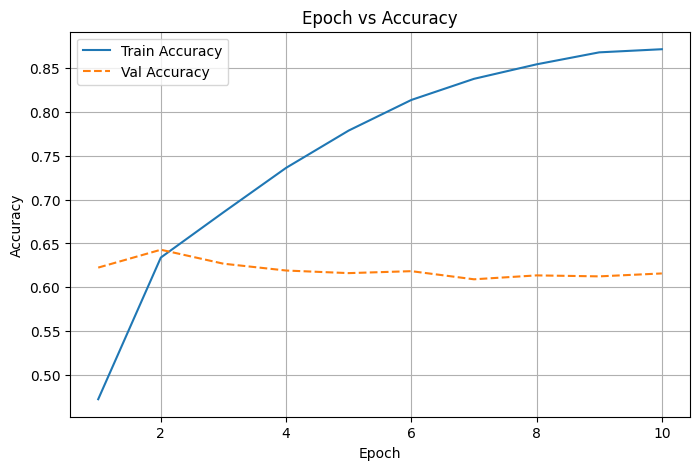

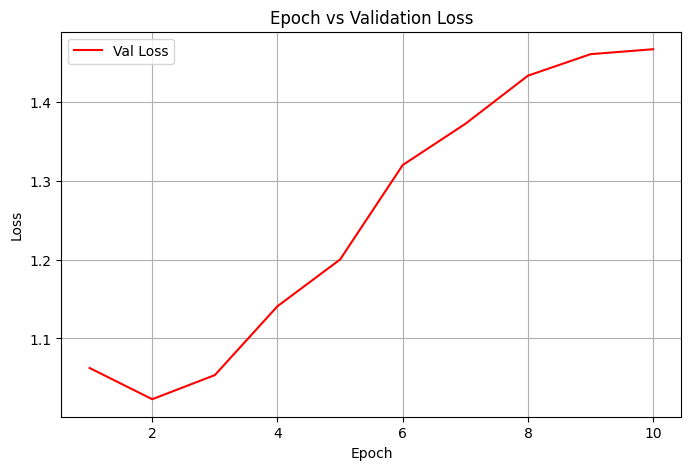

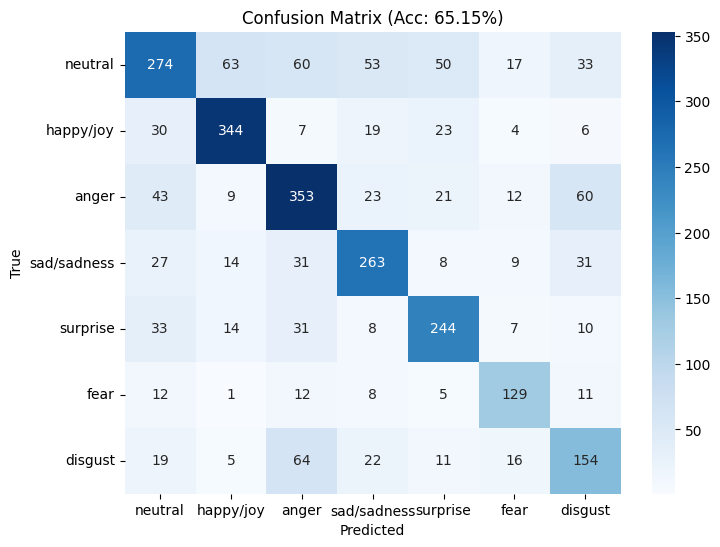

In [96]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

class_names = ["neutral", "happy/joy", "anger", "sad/sadness", "surprise", "fear", "disgust"]
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [97]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     neutral       0.63      0.50      0.55       550
   happy/joy       0.76      0.79      0.78       433
       anger       0.63      0.68      0.65       521
 sad/sadness       0.66      0.69      0.68       383
    surprise       0.67      0.70      0.69       347
        fear       0.66      0.72      0.69       178
     disgust       0.50      0.53      0.52       291

    accuracy                           0.65      2703
   macro avg       0.65      0.66      0.65      2703
weighted avg       0.65      0.65      0.65      2703



In [98]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     4          4
1     2          2
2     3          3
3     4          4
4     2          2

### Draft:

In [1]:
non_neutral_to_label = {
    "happy": 0, "anger": 1, "sad": 2,
    "surprise": 3, "fear": 4, "disgust": 5
}

In [4]:
df = pd.read_csv('./MC-EIU-processed_final.csv')
df.head()

audio_file  \
0  gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3   
1  gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3   
2  gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3   
3  gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3   
4  gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3   

                       audio_file_local  \
0  /content/mc-eiu-data/dia_1_utt_0.mp3   
1  /content/mc-eiu-data/dia_1_utt_1.mp3   
2  /content/mc-eiu-data/dia_1_utt_2.mp3   
3  /content/mc-eiu-data/dia_1_utt_3.mp3   
4  /content/mc-eiu-data/dia_1_utt_4.mp3   

                                                text  emotion       intent  \
0  Ross:  Hi... There she is. Hi Emma. Oh my God,...    happy  questioning   
1  Rachel: That was one time, Ross, and they were...  neutral      neutral   
2  Ross: Ooh hey, Emma, daddy has some presents f...  neutral      wishing   
3  Rachel: Aaah... Ross, actually there's somethi...    anger      neutral   
4                             Ross:  Okay, shoot! \n  neutral     agreeing   

   speaker  dialogue_id  utterance_id  emotion_label  binary_label  
0        0            1             0              1             1  
1        1            1             1              0             0  
2        0            1             2              0             0  
3        1            1             3              2             1  
4        0            1             4              0             0

In [5]:
df['emotion'].value_counts()

emotion
neutral     21428
happy       12622
anger        4476
sad          2649
surprise     1732
fear         1256
disgust       844
Name: count, dtype: int64

In [6]:
df = df[df['text'] != '-'].reset_index(drop=True)

In [7]:
df['emotion'].value_counts()

emotion
neutral     12488
happy        5081
anger        2029
sad          1052
fear          902
surprise      844
disgust       344
Name: count, dtype: int64

In [15]:
disgust_df = df[df['emotion'] == 'disgust']
disgust_df = disgust_df[['text', 'emotion']]

disgust_df.head()

text  emotion
27    Precious: Screw you, Mike. You're a coward and...  disgust
1110              Chandler: Oh, what a crappy night! \n  disgust
1911                          MONICA: I'm a twinkie. \n  disgust
1935  JOEY: Naa, you keep it, you need the practice. \n  disgust
1959  PHOEBE: No. This game is grotesque. Twenty arm...  disgust

In [19]:
disgust_df['text'] = disgust_df['text'].str.replace(r'^[^:]+:\s*', '', regex=True)
disgust_df['text'] = disgust_df['text'].str.replace(r'[\r\n]+', ' ', regex=True)

disgust_df.head()

text  emotion
27    Screw you, Mike. You're a coward and a bastard...  disgust
1110                         Oh, what a crappy night!    disgust
1911                                   I'm a twinkie.    disgust
1935         Naa, you keep it, you need the practice.    disgust
1959  No. This game is grotesque. Twenty armless guy...  disgust

In [16]:
fear_df = df[df['emotion'] == 'fear']
fear_df = fear_df[['text', 'emotion']]

fear_df.head()

text emotion
23   Phoebe: But he didn't really know, you know. H...    fear
45   Joey: But what you saw, that is the extent of ...    fear
64   Frank Jr.: Oh, no! I would never do that. No. ...    fear
81   Frank Jr. : Look at them! Aw. I love you so mu...    fear
116  Ross: One Mississipi, two Mississipi, Three Mi...    fear

In [20]:
fear_df['text'] = fear_df['text'].str.replace(r'^[^:]+:\s*', '', regex=True)
fear_df['text'] = fear_df['text'].str.replace(r'[\r\n]+', ' ', regex=True)

fear_df.head()

text emotion
23   But he didn't really know, you know. He wasn't...    fear
45   But what you saw, that is the extent of it, ok...    fear
64   Oh, no! I would never do that. No. I just was ...    fear
81   Look at them! Aw. I love you so much.  Oh crap...    fear
116  One Mississipi, two Mississipi, Three Mis... W...    fear

In [25]:
disgust_df = disgust_df.rename(columns={'text': 'utterance'})
fear_df = fear_df.rename(columns={'text': 'utterance'})

train_df = train_df[['utterance', 'emotion']]
train_df = pd.concat([train_df, disgust_df, fear_df], ignore_index=True)

train_df.head(20)

utterance   emotion
0   also I was the point person on my company’s tr...   neutral
1                    You must’ve had your hands full.   neutral
2                             That I did. That I did.   neutral
3       So let’s talk a little bit about your duties.   neutral
4                              My duties?  All right.  surprise
5   Now you’ll be heading a whole division, so you...   neutral
6                                              I see.   neutral
7   But there’ll be perhaps 30 people under you so...   neutral
8                                       Good to know.   neutral
9                               We can go into detail   neutral
10                             No don’t I beg of you!      fear
11  All right then, we’ll have a definite answer f...   neutral
12                                           Really?!  surprise
13                         Absolutely.  You can relax   neutral
14  But then who? The waitress I went out with las...  surprise
15                               You know? Forget it!   sadness
16  No-no-no-no, no! Who, who were you talking about?  surprise
17           No, I-I-I-I don't, I actually don't know      fear
18                                                Ok!   neutral
19                                 All right, well...   neutral

In [26]:
train_df['emotion'].value_counts()

emotion
neutral     4710
joy         1743
surprise    1205
fear        1170
anger       1109
sadness      683
disgust      615
Name: count, dtype: int64

In [29]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

train_disgust = train_df[train_df['emotion'] == 'disgust']['utterance'].tolist()
disgust_utterances = disgust_df['utterance'].tolist()

train_embeddings = model.encode(train_disgust, convert_to_tensor=True)
disgust_embeddings = model.encode(disgust_utterances, convert_to_tensor=True)

cosine_scores = util.cos_sim(train_embeddings, disgust_embeddings)


best_pair = torch.argmax(cosine_scores)
row = best_pair // cosine_scores.size(1)
col = best_pair % cosine_scores.size(1)

print(f"\nMost similar utterances:")
print(f"- train_df: {train_disgust[row]}")
print(f"- disgust:  {disgust_utterances[col]}")
print(f"Similarity: {cosine_scores[row][col].item():.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Most similar utterances:
- train_df: Oh well that’s what I thought about my first husband, now I’m lucky if my kid gets to spend the weekend with her father and the twins and little Ms. New Boobs.
- disgust:  Oh well that’s what I thought about my first husband, now I’m lucky if my kid gets to spend the weekend with her father and the twins and little Ms. New Boobs.  
Similarity: 1.0000


In [30]:
train_df['emotion'].value_counts()

emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64

In [45]:
train_disgust = train_df[train_df['emotion'] == 'disgust']['utterance'].tolist()
new_disgust = disgust_df['utterance'].tolist()

train_embeddings = model.encode(train_disgust, convert_to_tensor=True)
new_embeddings = model.encode(new_disgust, convert_to_tensor=True)

idx = 0
to_add = []
for i, new_emb in enumerate(new_embeddings):
  cosine_scores = util.cos_sim(new_emb, train_embeddings)
  max_score = float(cosine_scores.max())

  if max_score < 0.7:
    idx += 1
    to_add.append({'utterance': new_disgust[i], 'emotion': 'disgust'})
  if idx % 10 == 0:
    print("idx =", idx)

train_df = pd.concat([train_df, pd.DataFrame(to_add)], ignore_index=True)

idx = 10
idx = 20
idx = 30
idx = 40
idx = 50
idx = 60
idx = 70
idx = 80
idx = 90
idx = 100
idx = 110
idx = 120
idx = 130
idx = 140
idx = 150
idx = 160
idx = 170
idx = 180
idx = 190
idx = 200
idx = 210
idx = 220
idx = 230
idx = 240
idx = 250
idx = 260
idx = 270
idx = 280
idx = 290
idx = 300
idx = 310
idx = 320


In [46]:
train_df['emotion'].value_counts()

emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      599
fear         268
Name: count, dtype: int64

In [47]:
train_fear = train_df[train_df['emotion'] == 'fear']['utterance'].tolist()
new_fear = fear_df['utterance'].tolist()

train_embeddings = model.encode(train_fear, convert_to_tensor=True)
new_embeddings = model.encode(new_fear, convert_to_tensor=True)

idx = 0
to_add = []
for i, new_emb in enumerate(new_embeddings):
  cosine_scores = util.cos_sim(new_emb, train_embeddings)
  max_score = float(cosine_scores.max())

  if max_score < 0.5:
    idx += 1
    to_add.append({'utterance': new_fear[i], 'emotion': 'fear'})
  if idx % 10 == 0:
    print("idx =", idx)

train_df = pd.concat([train_df, pd.DataFrame(to_add)], ignore_index=True)

idx = 10
idx = 20
idx = 20
idx = 20
idx = 30
idx = 40
idx = 40
idx = 50
idx = 60
idx = 70
idx = 80
idx = 90
idx = 100
idx = 110
idx = 120
idx = 120
idx = 130
idx = 130
idx = 140
idx = 150
idx = 160
idx = 170
idx = 170
idx = 180
idx = 190
idx = 200
idx = 210
idx = 220
idx = 230
idx = 240
idx = 250
idx = 260
idx = 270
idx = 280
idx = 290
idx = 300
idx = 300
idx = 310
idx = 320
idx = 330
idx = 340
idx = 350
idx = 360
idx = 370
idx = 380
idx = 390
idx = 400
idx = 410
idx = 420
idx = 430
idx = 430
idx = 430
idx = 430
idx = 440
idx = 450
idx = 460
idx = 470
idx = 480
idx = 490
idx = 500
idx = 510
idx = 520
idx = 530
idx = 540
idx = 550
idx = 560
idx = 570
idx = 580
idx = 590
idx = 600
idx = 610
idx = 620
idx = 620
idx = 630
idx = 640
idx = 650
idx = 660
idx = 670
idx = 680
idx = 690
idx = 700


In [48]:
train_df['emotion'].value_counts()

emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
fear         976
sadness      683
disgust      599
Name: count, dtype: int64

###### Non-neutral emotions data:

In [ ]:
emotion_df = df[['text', 'emotion_label']].copy()
emotion_df = emotion_df[emotion_df['emotion_label'] != 0].reset_index(drop=True)

emotion_df['emotion_label'], _ = pd.factorize(emotion_df['emotion_label'])
emotion_df.head()

text  emotion_label
0  Ross:  Hi... There she is. Hi Emma. Oh my God,...              0
1  Rachel: Aaah... Ross, actually there's somethi...              1
2                                   Ross:  OH NO! \n              1
3  Ross: Oh, it's all over everything. Why? Why m...              1
4  Rachel: Because you took three hundred bottles...              2

In [ ]:
emotion_df = emotion_df[emotion_df['text'] != '-'].reset_index(drop=True)

In [ ]:
emotion_df['emotion_label'].value_counts()

emotion_label
0    5081
1    2029
2    1052
3     902
5     844
4     344
Name: count, dtype: int64

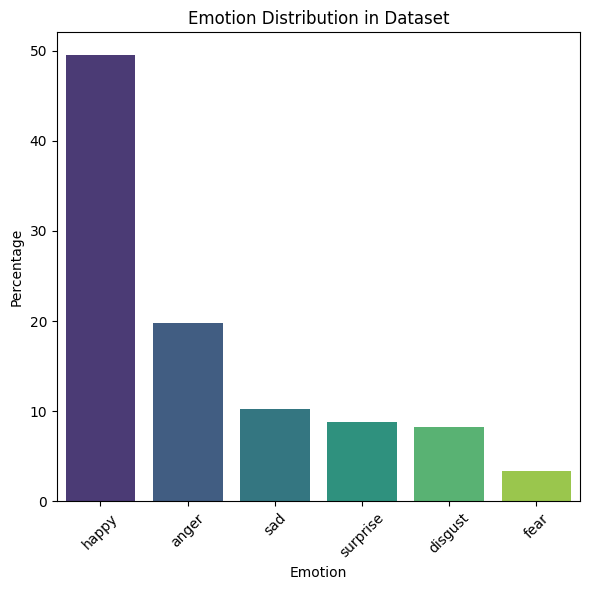

In [ ]:
label_to_emotion = {v: k for k, v in non_neutral_to_label.items()}
emotion_counts_i = emotion_df['emotion_label'].value_counts(normalize=True) * 100

plot_df = pd.DataFrame({
    "Emotion": [label_to_emotion[label] for label in emotion_counts_i.index],
    "Percentage": emotion_counts_i.values
})

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=plot_df, x="Emotion", y="Percentage", hue="Emotion", palette="viridis", ax=ax, legend=False)

ax.set_title('Emotion Distribution in Dataset')
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
happy_df = emotion_df[emotion_df['emotion_label'] == 0]
happy_df_reduced = happy_df.sample(frac=0.5, random_state=42)

others_df = emotion_df[emotion_df['emotion_label'] != 0]

emotion_df_reduced = pd.concat([happy_df_reduced, others_df], ignore_index=True)
emotion_df = emotion_df_reduced.sample(frac=1, random_state=42).reset_index(drop=True)
emotion_df.head()

text  emotion_label
0  Chandler: But it's all so overwhelming. I don'...              2
1  Gloria : Well, batman doesn't get picked on, a...              1
2  Rachel: No. No, I don't. Could you be a dear a...              2
3                               Joey: I think so. \n              2
4         Ross: Hmm?  Oh, a student I don’t know. \n              3

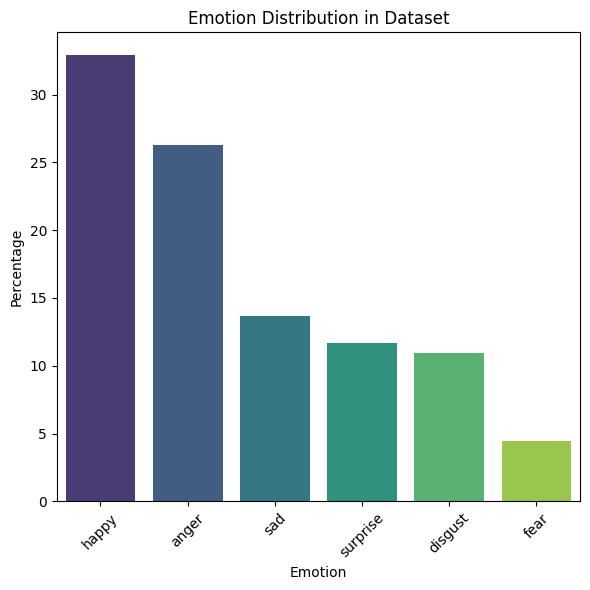

In [ ]:
label_to_emotion = {v: k for k, v in non_neutral_to_label.items()}
emotion_counts_i = emotion_df['emotion_label'].value_counts(normalize=True) * 100

plot_df = pd.DataFrame({
    "Emotion": [label_to_emotion[label] for label in emotion_counts_i.index],
    "Percentage": emotion_counts_i.values
})

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=plot_df, x="Emotion", y="Percentage", hue="Emotion", palette="viridis", ax=ax, legend=False)

ax.set_title('Emotion Distribution in Dataset')
ax.set_xlabel('Emotion')
ax.set_ylabel('Percentage')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
emotion_df['emotion_label'].value_counts()

emotion_label
0    2540
1    2029
2    1052
3     902
5     844
4     344
Name: count, dtype: int64

### Go-emotions draft:

In [1]:
!pip install -U datasets fsspec --quiet

In [135]:
# rm -r ~/.cache/huggingface/datasets/go_emotions

rm: cannot remove '/root/.cache/huggingface/datasets/go_emotions': No such file or directory


In [4]:
from datasets import load_dataset

dataset = load_dataset("go_emotions", name="raw", cache_dir="./hf_cache")

emotion_labels = [
  'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
  'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
  'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
  'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
  'remorse', 'sadness', 'surprise', 'neutral'
]

def convert_row(row):
  return {
    "text": row["text"],
    "labels": [emotion for emotion in emotion_labels if row[emotion] == 1]
  }

converted_dataset = dataset["train"].map(convert_row)
converted_dataset[0]

Map:   0%|          | 0/211225 [00:00<?, ? examples/s]

{'text': 'That game hurt.',
 'id': 'eew5j0j',
 'author': 'Brdd9',
 'subreddit': 'nrl',
 'link_id': 't3_ajis4z',
 'parent_id': 't1_eew18eq',
 'created_utc': 1548381056.0,
 'rater_id': 1,
 'example_very_unclear': False,
 'admiration': 0,
 'amusement': 0,
 'anger': 0,
 'annoyance': 0,
 'approval': 0,
 'caring': 0,
 'confusion': 0,
 'curiosity': 0,
 'desire': 0,
 'disappointment': 0,
 'disapproval': 0,
 'disgust': 0,
 'embarrassment': 0,
 'excitement': 0,
 'fear': 0,
 'gratitude': 0,
 'grief': 0,
 'joy': 0,
 'love': 0,
 'nervousness': 0,
 'optimism': 0,
 'pride': 0,
 'realization': 0,
 'relief': 0,
 'remorse': 0,
 'sadness': 1,
 'surprise': 0,
 'neutral': 0,
 'labels': ['sadness']}

In [20]:
target_classes = ['neutral', 'joy', 'anger', 'sadness', 'surprise', 'fear', 'disgust']

df = pd.DataFrame(dataset['train'])

def get_active_labels(row):
  return [label for label in emotion_labels if row[label] == 1]

df['labels'] = df.apply(get_active_labels, axis=1)
filtered_df = df[df['labels'].apply(lambda x: len(x) == 1 and x[0] in target_classes)].copy()

filtered_df['emotion'] = filtered_df['labels'].apply(lambda x: x[0])
filtered_df = filtered_df[['text', 'emotion']].rename(columns={"text": "utterance"})

print(filtered_df['emotion'].value_counts())
filtered_df.head()

emotion
neutral     55298
anger        5202
joy          4329
sadness      3827
surprise     3472
disgust      2914
fear         1778
Name: count, dtype: int64


utterance  emotion
0                                     That game hurt.  sadness
2      You do right, if you don't care then fuck 'em!  neutral
4   [NAME] was nowhere near them, he was by the Fa...  neutral
10  I have, and now that you mention it, I think t...  neutral
12                              BUT IT'S HER TURN! /s  neutral

In [21]:
emotion_to_label = {
  "neutral": 0,
  "happy": 1,
  "joy": 1,
  "anger": 2,
  "sad": 3,
  "sadness": 3,
  "surprise": 4,
  "fear": 5,
  "disgust": 6
}

filtered_df['emotion_label'] = filtered_df['emotion'].map(emotion_to_label)
# filtered_df = filtered_df.dropna(subset=['emotion_label'])
filtered_df['emotion_label'] = filtered_df['emotion_label'].astype(int)

filtered_df = filtered_df.drop(columns=['emotion'])

print(filtered_df.dtypes)
filtered_df.head()

utterance        object
emotion_label     int64
dtype: object


utterance  emotion_label
0                                     That game hurt.              3
2      You do right, if you don't care then fuck 'em!              0
4   [NAME] was nowhere near them, he was by the Fa...              0
10  I have, and now that you mention it, I think t...              0
12                              BUT IT'S HER TURN! /s              0

In [22]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
  filtered_df, test_size=0.2, stratify=filtered_df['emotion_label'], random_state=42
)

val_df, test_df = train_test_split(
  temp_df, test_size=0.5, stratify=temp_df['emotion_label'], random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 61456
Validation size: 7682
Test size: 7682


In [23]:
print(train_df['emotion_label'].value_counts())
print(val_df['emotion_label'].value_counts())
print(test_df['emotion_label'].value_counts())

emotion_label
0    44238
2     4162
1     3463
3     3062
4     2778
6     2331
5     1422
Name: count, dtype: int64
emotion_label
0    5530
2     520
1     433
3     382
4     347
6     292
5     178
Name: count, dtype: int64
emotion_label
0    5530
2     520
1     433
3     383
4     347
6     291
5     178
Name: count, dtype: int64


#### Full model training:

In [10]:
MODEL_NAME = "bhadresh-savani/distilbert-base-uncased-emotion"
# MODEL_NAME = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

###### Whole data:

In [24]:
train_labels = list(map(int, train_df["emotion_label"]))
val_labels = list(map(int, val_df["emotion_label"]))
test_labels = list(map(int, test_df["emotion_label"]))

In [25]:
set(filtered_df["emotion_label"])

{0, 1, 2, 3, 4, 5, 6}

In [26]:
train_df["emotion_label"].value_counts()

emotion_label
0    44238
2     4162
1     3463
3     3062
4     2778
6     2331
5     1422
Name: count, dtype: int64

In [28]:
max_len_chars = train_df["utterance"].str.len().max()
print(f"Max character length: {max_len_chars}")

Max character length: 542


In [29]:
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=max_length)
    self.labels = labels

  def __getitem__(self, idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

def collate_fn(batch):
  return {
    "input_ids": torch.stack([item["input_ids"] for item in batch]),
    "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
    "labels": torch.stack([item["labels"] for item in batch]),
  }

In [30]:
train_dataset = TextDataset(train_df["utterance"].tolist(), train_df["emotion_label"].tolist(), tokenizer)
val_dataset = TextDataset(val_df["utterance"].tolist(), val_df["emotion_label"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["utterance"].tolist(), test_df["emotion_label"].tolist(), tokenizer)

In [31]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

###### Training:

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

class_weights = compute_class_weight(
  class_weight="balanced",
  classes=np.unique(train_labels),
  y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [33]:
# loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

In [34]:
from transformers import AutoModel, AutoConfig

class CustomClassifier(nn.Module):
  def __init__(self, model_name, num_labels, dropout_prob=0.3):
    super().__init__()
    self.base = AutoModel.from_pretrained(model_name)
    self.base.gradient_checkpointing_enable()
    hidden_size = self.base.config.hidden_size
    self.dropout = nn.Dropout(dropout_prob)
    self.classifier = nn.Linear(hidden_size, num_labels)

  def forward(self, input_ids, attention_mask, labels=None):
    outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
    x = self.dropout(pooled_output)
    logits = self.classifier(x)
    return {'logits': logits}

In [35]:
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7, ignore_mismatched_sizes=True)
model = CustomClassifier(MODEL_NAME, num_labels=7).to(device)
# config = AutoConfig.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config, num_labels=7, ignore_mismatched_sizes=True)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

In [36]:
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_scheduler(
  "cosine",
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_training_steps
)

In [37]:
def train_one_epoch(model, dataloader, optimizer):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    logits = outputs["logits"]
    loss = loss_fn(logits, batch["labels"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    total_loss += loss.item()
    preds = torch.argmax(logits, dim=1)
    correct += (preds == batch["labels"]).sum().item()
    total += batch["labels"].size(0)

  return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      # logits = outputs.logits
      logits = outputs['logits']
      loss = loss_fn(logits, batch["labels"])

      total_loss += loss.item()
      preds = torch.argmax(logits, dim=1)
      correct += (preds == batch["labels"]).sum().item()
      total += batch["labels"].size(0)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(batch["labels"].cpu().tolist())

  class_names = ["neutral", "happy", "anger", "sad", "surprise", "fear", "disgust"]
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(f"Confusion Matrix (Acc: {correct / total*100:.2f}%)")
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  return total_loss / len(dataloader), correct / total

In [38]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()


Epoch 1/10


100%|██████████| 241/241 [00:24<00:00,  9.72it/s]


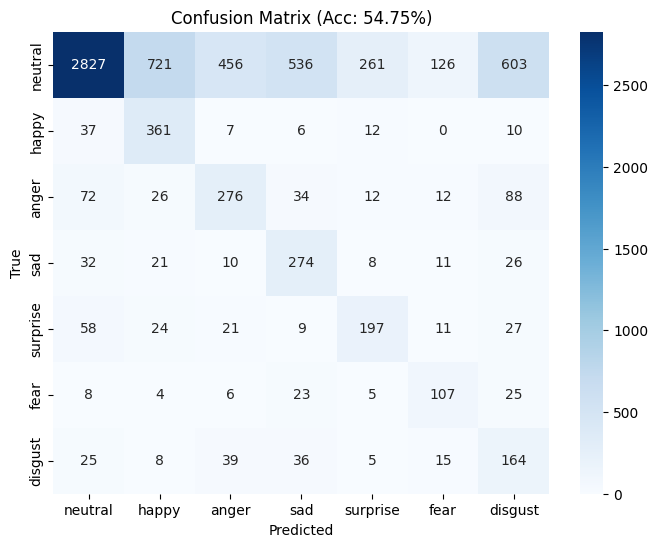


Classification Report:
              precision    recall  f1-score   support

     neutral       0.92      0.51      0.66      5530
       happy       0.31      0.83      0.45       433
       anger       0.34      0.53      0.41       520
         sad       0.30      0.72      0.42       382
    surprise       0.39      0.57      0.47       347
        fear       0.38      0.60      0.47       178
     disgust       0.17      0.56      0.27       292

    accuracy                           0.55      7682
   macro avg       0.40      0.62      0.45      7682
weighted avg       0.75      0.55      0.59      7682

Train Loss: 1.3493, Accuracy: 0.4563
Val Loss: 1.1389, Accuracy: 0.5475
Model saved.

Epoch 2/10


100%|██████████| 241/241 [00:24<00:00,  9.71it/s]


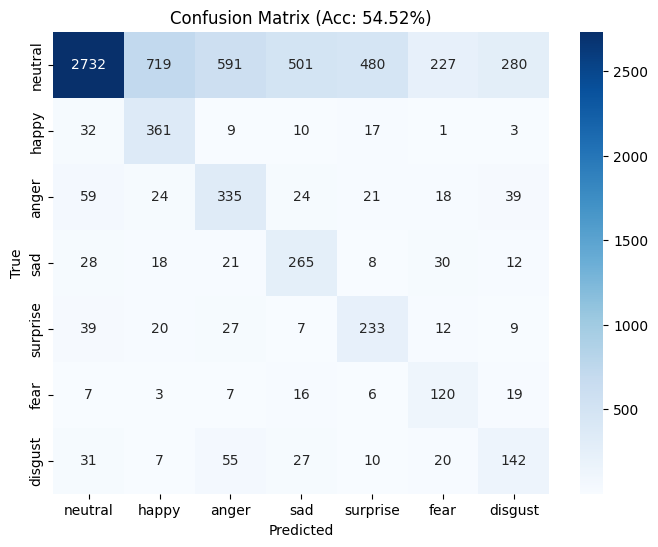


Classification Report:
              precision    recall  f1-score   support

     neutral       0.93      0.49      0.65      5530
       happy       0.31      0.83      0.46       433
       anger       0.32      0.64      0.43       520
         sad       0.31      0.69      0.43       382
    surprise       0.30      0.67      0.42       347
        fear       0.28      0.67      0.40       178
     disgust       0.28      0.49      0.36       292

    accuracy                           0.55      7682
   macro avg       0.39      0.64      0.45      7682
weighted avg       0.76      0.55      0.58      7682

Train Loss: 1.0277, Accuracy: 0.5623
Val Loss: 1.0555, Accuracy: 0.5452
Model saved.

Epoch 3/10


100%|██████████| 241/241 [00:24<00:00,  9.68it/s]


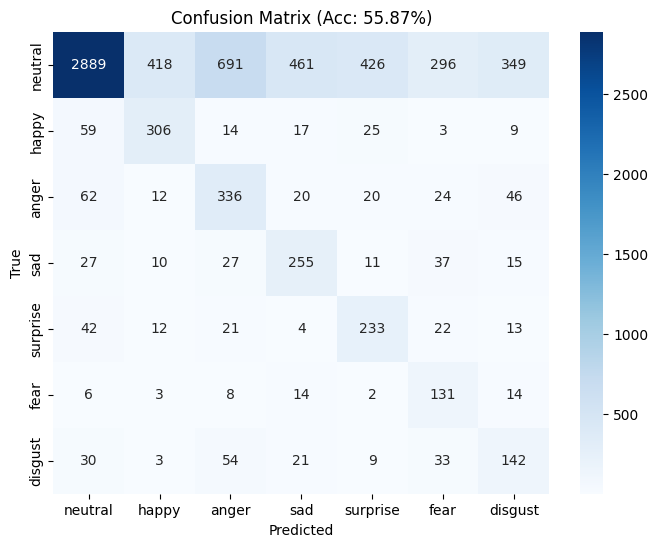


Classification Report:
              precision    recall  f1-score   support

     neutral       0.93      0.52      0.67      5530
       happy       0.40      0.71      0.51       433
       anger       0.29      0.65      0.40       520
         sad       0.32      0.67      0.43       382
    surprise       0.32      0.67      0.43       347
        fear       0.24      0.74      0.36       178
     disgust       0.24      0.49      0.32       292

    accuracy                           0.56      7682
   macro avg       0.39      0.63      0.45      7682
weighted avg       0.76      0.56      0.60      7682

Train Loss: 0.8663, Accuracy: 0.5955
Val Loss: 1.1077, Accuracy: 0.5587

Epoch 4/10


100%|██████████| 241/241 [00:24<00:00,  9.66it/s]


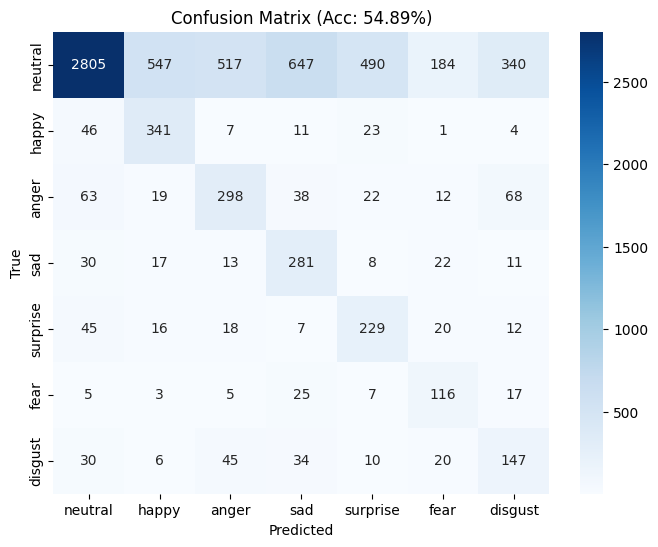


Classification Report:
              precision    recall  f1-score   support

     neutral       0.93      0.51      0.66      5530
       happy       0.36      0.79      0.49       433
       anger       0.33      0.57      0.42       520
         sad       0.27      0.74      0.39       382
    surprise       0.29      0.66      0.40       347
        fear       0.31      0.65      0.42       178
     disgust       0.25      0.50      0.33       292

    accuracy                           0.55      7682
   macro avg       0.39      0.63      0.45      7682
weighted avg       0.75      0.55      0.59      7682

Train Loss: 0.7201, Accuracy: 0.6365
Val Loss: 1.1992, Accuracy: 0.5489

Epoch 5/10


100%|██████████| 241/241 [00:24<00:00,  9.67it/s]


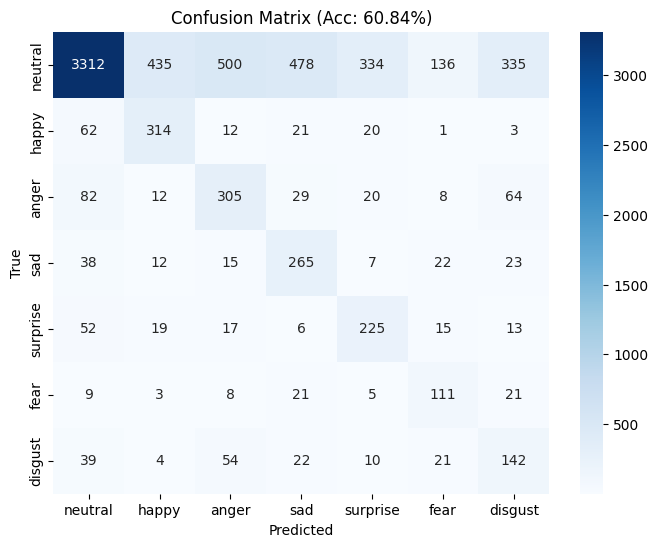


Classification Report:
              precision    recall  f1-score   support

     neutral       0.92      0.60      0.73      5530
       happy       0.39      0.73      0.51       433
       anger       0.33      0.59      0.43       520
         sad       0.31      0.69      0.43       382
    surprise       0.36      0.65      0.46       347
        fear       0.35      0.62      0.45       178
     disgust       0.24      0.49      0.32       292

    accuracy                           0.61      7682
   macro avg       0.42      0.62      0.48      7682
weighted avg       0.76      0.61      0.65      7682

Train Loss: 0.5885, Accuracy: 0.6800
Val Loss: 1.3379, Accuracy: 0.6084

Epoch 6/10


100%|██████████| 241/241 [00:24<00:00,  9.65it/s]


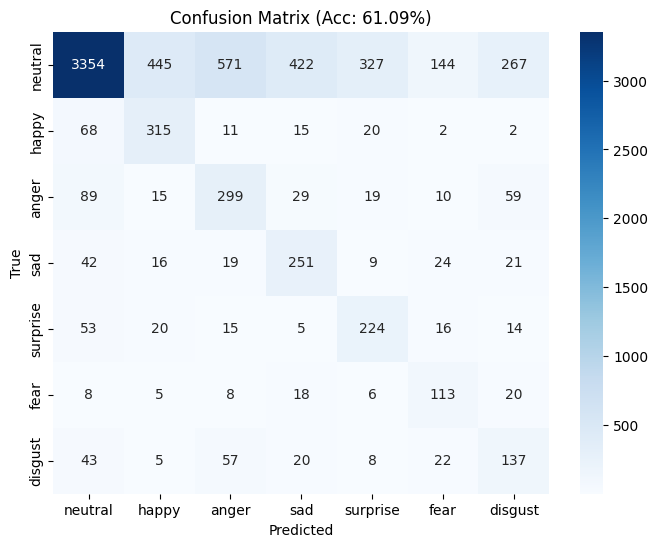


Classification Report:
              precision    recall  f1-score   support

     neutral       0.92      0.61      0.73      5530
       happy       0.38      0.73      0.50       433
       anger       0.31      0.57      0.40       520
         sad       0.33      0.66      0.44       382
    surprise       0.37      0.65      0.47       347
        fear       0.34      0.63      0.44       178
     disgust       0.26      0.47      0.34       292

    accuracy                           0.61      7682
   macro avg       0.42      0.62      0.47      7682
weighted avg       0.75      0.61      0.65      7682

Train Loss: 0.4934, Accuracy: 0.7174
Val Loss: 1.4462, Accuracy: 0.6109

Epoch 7/10


100%|██████████| 241/241 [00:24<00:00,  9.68it/s]


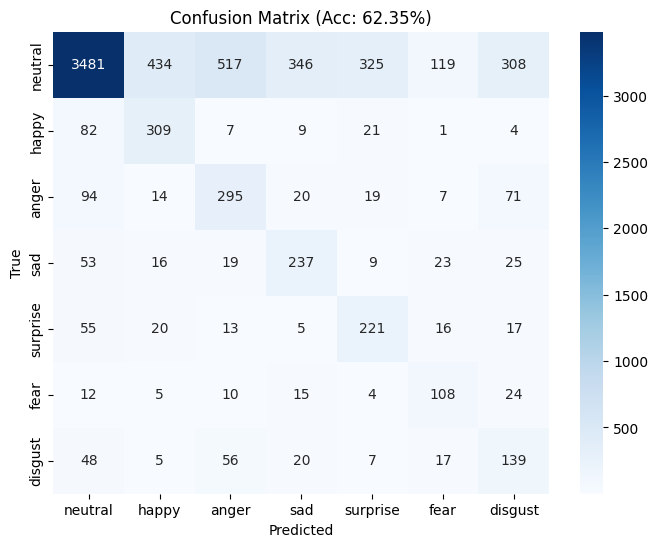


Classification Report:
              precision    recall  f1-score   support

     neutral       0.91      0.63      0.74      5530
       happy       0.38      0.71      0.50       433
       anger       0.32      0.57      0.41       520
         sad       0.36      0.62      0.46       382
    surprise       0.36      0.64      0.46       347
        fear       0.37      0.61      0.46       178
     disgust       0.24      0.48      0.32       292

    accuracy                           0.62      7682
   macro avg       0.42      0.61      0.48      7682
weighted avg       0.75      0.62      0.66      7682

Train Loss: 0.4249, Accuracy: 0.7460
Val Loss: 1.5686, Accuracy: 0.6235

Epoch 8/10


100%|██████████| 241/241 [00:24<00:00,  9.66it/s]


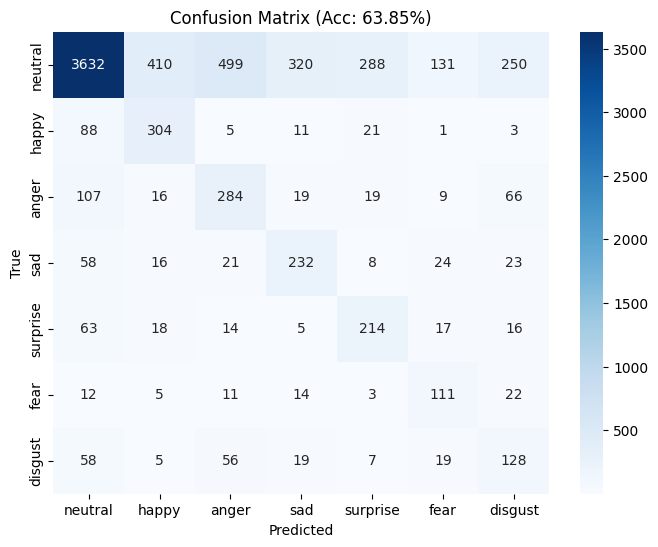


Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.66      0.76      5530
       happy       0.39      0.70      0.50       433
       anger       0.32      0.55      0.40       520
         sad       0.37      0.61      0.46       382
    surprise       0.38      0.62      0.47       347
        fear       0.36      0.62      0.45       178
     disgust       0.25      0.44      0.32       292

    accuracy                           0.64      7682
   macro avg       0.43      0.60      0.48      7682
weighted avg       0.75      0.64      0.67      7682

Train Loss: 0.3739, Accuracy: 0.7669
Val Loss: 1.7132, Accuracy: 0.6385

Epoch 9/10


100%|██████████| 241/241 [00:24<00:00,  9.67it/s]


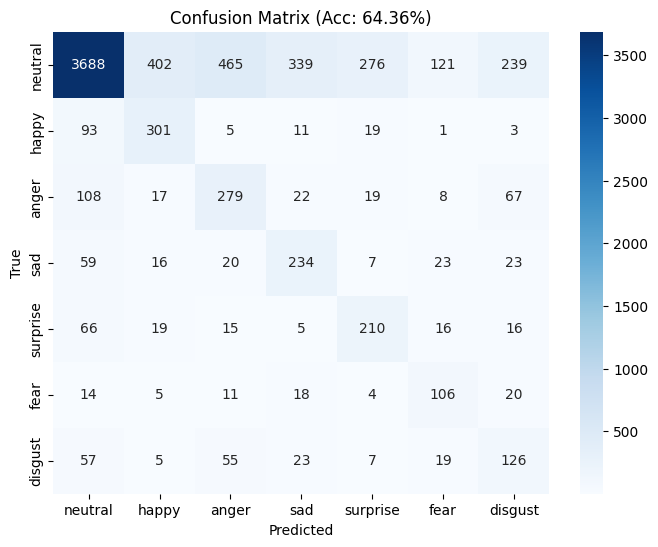


Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.67      0.77      5530
       happy       0.39      0.70      0.50       433
       anger       0.33      0.54      0.41       520
         sad       0.36      0.61      0.45       382
    surprise       0.39      0.61      0.47       347
        fear       0.36      0.60      0.45       178
     disgust       0.26      0.43      0.32       292

    accuracy                           0.64      7682
   macro avg       0.43      0.59      0.48      7682
weighted avg       0.75      0.64      0.67      7682

Train Loss: 0.3428, Accuracy: 0.7779
Val Loss: 1.7657, Accuracy: 0.6436

Epoch 10/10


100%|██████████| 241/241 [00:24<00:00,  9.66it/s]


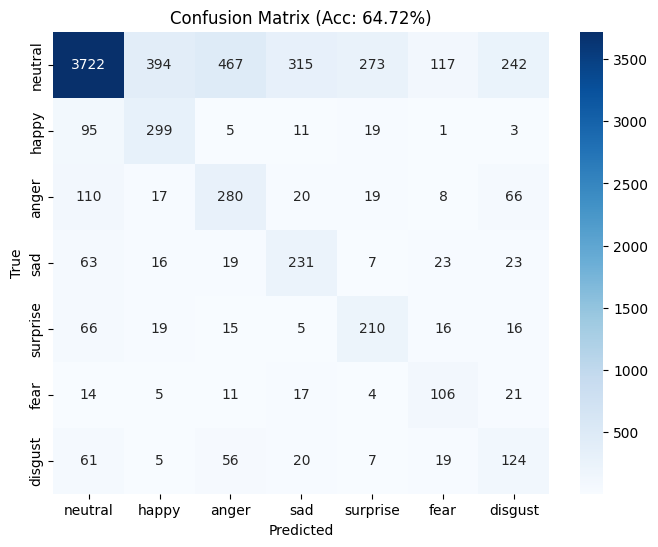


Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.67      0.77      5530
       happy       0.40      0.69      0.50       433
       anger       0.33      0.54      0.41       520
         sad       0.37      0.60      0.46       382
    surprise       0.39      0.61      0.47       347
        fear       0.37      0.60      0.45       178
     disgust       0.25      0.42      0.32       292

    accuracy                           0.65      7682
   macro avg       0.43      0.59      0.48      7682
weighted avg       0.75      0.65      0.68      7682

Train Loss: 0.3277, Accuracy: 0.7838
Val Loss: 1.7848, Accuracy: 0.6472


In [39]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float("inf")
patience = 4
patience_counter = 0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(10):
  print(f"\nEpoch {epoch+1}/10")
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
  val_loss, val_acc = evaluate(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)

  print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model.state_dict(), "best_full_go_emotions_model.pt")
    print("Model saved.")
  # else:
  #   patience_counter += 1
  #   print(f"No improvement. Patience: {patience_counter}/{patience}")
  #   if patience_counter >= patience:
  #     print("Early stopping.")
  #     break

torch.save(model.state_dict(), "best_full_go_emotions_model_last.pt")
print("Model saved.")

##### Results analysis:

In [40]:
model.load_state_dict(torch.load("best_full_go_emotions_model.pt"))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
  for batch in test_loader:
    batch = {k: v.squeeze(0).to(device) for k, v in batch.items()}
    labels = batch["labels"]

    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=labels)
    preds = torch.argmax(outputs['logits'], dim=1)

    test_correct += preds.eq(labels.to(device)).sum().item()
    test_total += labels.size(0)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_accuracy:.3f}")


Final Test Accuracy: 0.553


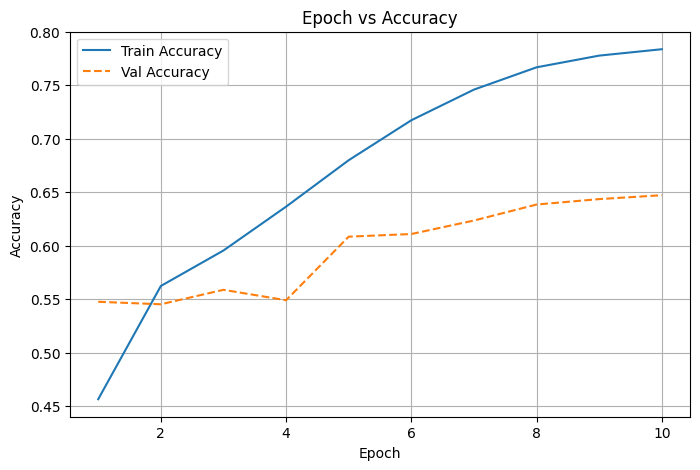

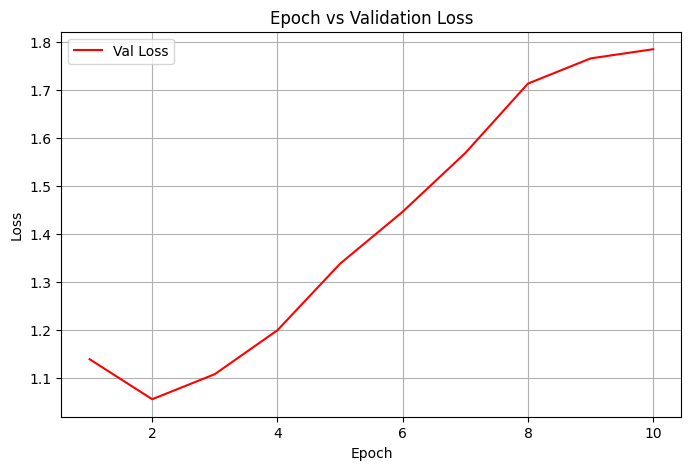

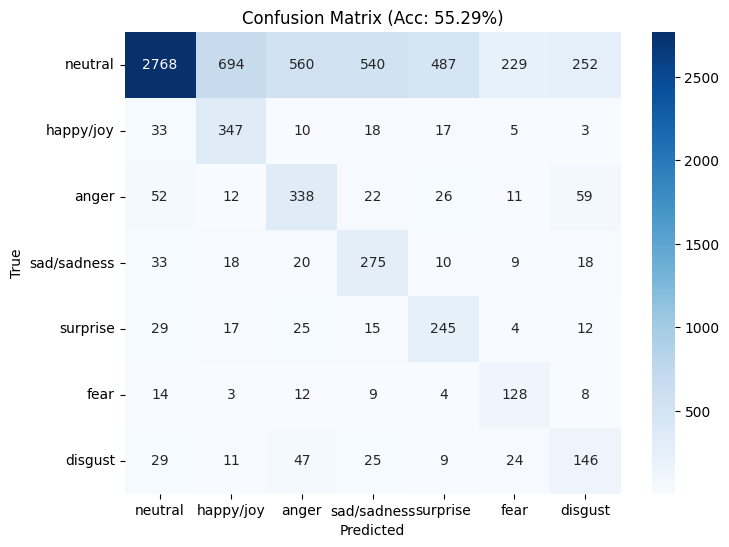

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(train_accuracies)) + 1, train_accuracies, label="Train Accuracy")
plt.plot(np.arange(len(val_accuracies)) + 1, val_accuracies, label="Val Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(val_losses)) + 1, val_losses, label="Val Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

class_names = ["neutral", "happy/joy", "anger", "sad/sadness", "surprise", "fear", "disgust"]
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Acc: {test_accuracy*100:.2f}%)")
plt.show()

In [42]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     neutral       0.94      0.50      0.65      5530
   happy/joy       0.31      0.80      0.45       433
       anger       0.33      0.65      0.44       520
 sad/sadness       0.30      0.72      0.43       383
    surprise       0.31      0.71      0.43       347
        fear       0.31      0.72      0.44       178
     disgust       0.29      0.50      0.37       291

    accuracy                           0.55      7682
   macro avg       0.40      0.66      0.46      7682
weighted avg       0.76      0.55      0.59      7682



In [ ]:
df_results = pd.DataFrame({
  "Real": all_labels,
  "Predicted": all_predictions
})
df_results.head()

Real  Predicted
0     4          0
1     2          3
2     0          0
3     0          0
4     1          2

##### Results analysis: